### Introduction

#### This project aims to develop a predictive model that assesses the probability of insurance claims for car insurance policies. Understanding the factors influencing claim frequency and severity over a period of six months will enable insurance companies to better assess risk and determine appropriate premiums for policyholders.

### Objective

#### The primary objective of this project is to build a robust predictive model to estimate the likelihood of an insurance claim. By analyzing comprehensive car policy features and safety ratings, the model will provide insights into key factors affecting claims, helping insurance companies make data-driven decisions for risk assessment and premium determination.

In [1]:
# Import necessary libraries
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Define colors and plot sizes
colors = ['dodgerblue', 'gold', 'salmon']
palettes = sns.color_palette(colors)
plot_sizes = [(12, 6), (12, 12), (6, 6), (24, 24), (24, 12)]

# Set the overall palette
sns.set_palette(sns.color_palette(colors))

In [3]:
# Load the dataset
file_path = 'datasets/BFSIData.csv'
data = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the dataset
data.head(2)

policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   

   population_density  make segment model fuel_type    max_torque  \
0                4990     1       A    M1       CNG  60Nm@3500rpm   
1               27003     1       A    M1       CNG  60Nm@3500rpm   

          max_power        engine_type  airbags is_esc is_adjustable_steering  \
0  40.36bhp@6000rpm  F8D Petrol Engine        2     No                     No   
1  40.36bhp@6000rpm  F8D Petrol Engine        2     No                     No   

  is_tpms is_parking_sensors is_parking_camera rear_brakes_type  displacement  \
0      No                Yes                No             Drum           796   
1      No                Yes                No             Drum           796   

   cylinder transmission_type  gear_box steering_type  turning_radius  length  \
0         3            Manual         5         Power             4.6    3445   
1         3            Manual         5         Power             4.6    3445   

   width  height  gross_weight is_front_fog_lights is_rear_window_wiper  \
0   1515    1475          1185                  No                   No   
1   1515    1475          1185                  No                   No   

  is_rear_window_washer is_rear_window_defogger is_brake_assist  \
0                    No                      No              No   
1                    No                      No              No   

  is_power_door_locks is_central_locking is_power_steering  \
0                  No                 No               Yes   
1                  No                 No               Yes   

  is_driver_seat_height_adjustable is_day_night_rear_view_mirror is_ecw  \
0                               No                            No     No   
1                               No                            No     No   

  is_speed_alert  ncap_rating  is_claim  
0            Yes            0         0  
1            Yes            0         0

In [5]:
# Structure of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

#### There are 58592 entries and 44 columns. There are no missing values.

In [6]:
# Unique value counts in each column
data.nunique()

policy_id                           58592
policy_tenure                       58592
age_of_car                             49
age_of_policyholder                    75
area_cluster                           22
population_density                     22
make                                    5
segment                                 6
model                                  11
fuel_type                               3
max_torque                              9
max_power                               9
engine_type                            11
airbags                                 3
is_esc                                  2
is_adjustable_steering                  2
is_tpms                                 2
is_parking_sensors                      2
is_parking_camera                       2
rear_brakes_type                        2
displacement                            9
cylinder                                2
transmission_type                       2
gear_box                          

In [7]:
# Unique values in each column
data.apply(pd.unique)

policy_id                           [ID00001, ID00002, ID00003, ID00004, ID00005, ...
policy_tenure                       [0.515873589958172, 0.672618513547733, 0.84111...
age_of_car                          [0.05, 0.02, 0.11, 0.07, 0.16, 0.14, 0.04, 0.0...
age_of_policyholder                 [0.644230769230769, 0.375, 0.384615384615385, ...
area_cluster                        [C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11,...
population_density                  [4990, 27003, 4076, 21622, 34738, 13051, 6112,...
make                                                                  [1, 2, 3, 4, 5]
segment                                                  [A, C1, C2, B2, B1, Utility]
model                                  [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, M11]
fuel_type                                                       [CNG, Petrol, Diesel]
max_torque                          [60Nm@3500rpm, 113Nm@4400rpm, 91Nm@4250rpm, 25...
max_power                           [40.36bhp@6000rpm,

In [8]:
# Getting summary statistics of the dataset
data.describe().T

count          mean           std          min  \
policy_tenure        58592.0      0.611246      0.414156     0.002735   
age_of_car           58592.0      0.069424      0.056721     0.000000   
age_of_policyholder  58592.0      0.469420      0.122886     0.288462   
population_density   58592.0  18826.858667  17660.174792   290.000000   
make                 58592.0      1.763722      1.136988     1.000000   
airbags              58592.0      3.137066      1.832641     1.000000   
displacement         58592.0   1162.355851    266.304786   796.000000   
cylinder             58592.0      3.626963      0.483616     3.000000   
gear_box             58592.0      5.245443      0.430353     5.000000   
turning_radius       58592.0      4.852893      0.228061     4.500000   
length               58592.0   3850.476891    311.457119  3445.000000   
width                58592.0   1672.233667    112.089135  1475.000000   
height               58592.0   1553.335370     79.622270  1475.000000   
gross_weight         58592.0   1385.276813    212.423085  1051.000000   
ncap_rating          58592.0      1.759950      1.389576     0.000000   
is_claim             58592.0      0.063968      0.244698     0.000000   

                             25%          50%           75%           max  
policy_tenure           0.210250     0.573792      1.039104      1.396641  
age_of_car              0.020000     0.060000      0.110000      1.000000  
age_of_policyholder     0.365385     0.451923      0.548077      1.000000  
population_density   6112.000000  8794.000000  27003.000000  73430.000000  
make                    1.000000     1.000000      3.000000      5.000000  
airbags                 2.000000     2.000000      6.000000      6.000000  
displacement          796.000000  1197.000000   1493.000000   1498.000000  
cylinder                3.000000     4.000000      4.000000      4.000000  
gear_box                5.000000     5.000000      5.000000      6.000000  
turning_radius          4.600000     4.800000      5.000000      5.200000  
length               3445.000000  3845.000000   3995.000000   4300.000000  
width                1515.000000  1735.000000   1755.000000   1811.000000  
height               1475.000000  1530.000000   1635.000000   1825.000000  
gross_weight         1185.000000  1335.000000   1510.000000   1720.000000  
ncap_rating             0.000000     2.000000      3.000000      5.000000  
is_claim                0.000000     0.000000      0.000000      1.000000

In [9]:
# Remove duplicates from the dataset
data.drop_duplicates(inplace=True)
print(data.shape[0])

58592


In [10]:
# Extract values from the 'max_torque' column
data['torque_value'] = data['max_torque'].str.extract(r'(\d+\.?\d*)').astype(float)

# Extract values from the 'max_power' column
data['power_value'] = data['max_power'].str.extract(r'(\d+\.?\d*)').astype(float)

In [11]:
# Drop irrelevant columns from the data
columns_to_drop = ['policy_id', 'max_torque', 'max_power']
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(data.shape[1])

43


In [12]:
# Define the target column
target_col = ['is_claim']

# Identify binary columns
binary_col = [col for col in data.columns if data[col].dropna().isin(['Yes', 'No']).all()]

# Identify non-binary columns
nonbinary_col = [col for col in data.columns if not data[col].dropna().isin(['Yes', 'No']).all()]
# Remove the target column from binary columns if it exists
nonbinary_col = [col for col in nonbinary_col if col not in target_col]

# Identify categorical columns with unique values <= 22
categorical_col = [col for col in nonbinary_col if data[col].nunique(dropna=True) <= 22]

# Identify the remaining numerical columns
numerical_col = [col for col in nonbinary_col if col not in categorical_col]

# Display the identified columns
print("Binary Columns (excluding target):", binary_col)
print("Categorical Columns:", categorical_col)
print("Numerical Columns:", numerical_col)
print("Target Column:", target_col)

Binary Columns (excluding target): ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']
Categorical Columns: ['area_cluster', 'population_density', 'make', 'segment', 'model', 'fuel_type', 'engine_type', 'airbags', 'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'ncap_rating', 'torque_value', 'power_value']
Numerical Columns: ['policy_tenure', 'age_of_car', 'age_of_policyholder']
Target Column: ['is_claim']


In [13]:
# Function to plot the distribution (histogram) of a specified column with optional hue
def plot_distribution(df, column_name, hue=None, palette=None, color='salmon', plot_size=(12, 6), rotation=None, annotate=False):
    if df is not None:
        if column_name in df.columns:
            plt.figure(figsize=plot_size)
            if hue:
                sns.histplot(df, x=column_name, hue=hue, kde=True, bins=30, palette=palette if palette else None)
            else:
                sns.histplot(df, x=column_name, kde=True, bins=30, color=color)
            plt.title(f'Distribution of {column_name.replace("_", " ").title()}')
            plt.xlabel(column_name.replace('_', ' ').title())
            plt.ylabel('Frequency')
            plt.xticks(rotation=rotation)
            
            if annotate:
                total = len(df)
                for p in plt.gca().patches:
                    height = p.get_height()
                    if height > 0:
                        plt.gca().annotate(f'{height / total:.1%}', (p.get_x() + p.get_width() / 2., height), 
                                        ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), 
                                        textcoords='offset points')
            
            plt.show()
        else:
            print(f"Column '{column_name}' not found in the dataframe.")
    else:
        print("DataFrame is None. Cannot plot distribution.")

In [14]:
# Function to plot the count (countplot) of a specified column with optional hue
def plot_count(df, column_name, hue=None, palette=None, color='salmon', plot_size=(12, 6), rotation=None, annotate=False):
    if df is not None:
        if column_name in df.columns:
            plt.figure(figsize=plot_size)
            if hue:
                sns.countplot(x=column_name, hue=hue, data=df, palette=palette if palette else None, order=df[column_name].value_counts().index)
            else:
                sns.countplot(x=column_name, data=df, color=color, order=df[column_name].value_counts().index)
                
            plt.title(f'Count Plot of {column_name.replace("_", " ").title()}')
            plt.xlabel(column_name.replace('_', ' ').title())
            plt.ylabel('Count')
            plt.xticks(rotation=rotation)
            
            if annotate:
                total = len(df)
                for p in plt.gca().patches:
                    height = p.get_height()
                    if height > 0:
                        plt.gca().annotate(f'{height / total:.1%}', (p.get_x() + p.get_width() / 2., height), 
                                           ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), 
                                           textcoords='offset points')
            
            plt.show()
        else:
            print(f"Column '{column_name}' not found in the dataframe.")
    else:
        print("DataFrame is None. Cannot create count plot.")

In [15]:
# Function to plot the boxplot of a specified column with optional hue
def plot_box(df, y_column, x_column='is_claim', palette=None, plot_size=(12, 6), rotation=None):
    # Check if DataFrame is not None
    if df is not None:
        # Check if x_column and y_column are in the DataFrame
        if x_column in df.columns and y_column in df.columns:
            plt.figure(figsize=plot_size)
            
            # Plot boxplot
            sns.boxplot(x=df[x_column], y=df[y_column], palette=palette if palette else 'Set2')
            
            # Set plot titles and labels
            plt.title(f'Box Plot of {y_column.replace("_", " ").title()} by {x_column.replace("_", " ").title()}')
            plt.xlabel(x_column.replace('_', ' ').title())
            plt.ylabel(y_column.replace('_', ' ').title())
            
            # Rotate x-axis labels if specified
            if rotation:
                plt.xticks(rotation=rotation)
            
            # Show plot
            plt.show()
        else:
            missing_columns = [col for col in [x_column, y_column] if col not in df.columns]
            print(f"Column(s) {', '.join(missing_columns)} not found in the DataFrame.")
    else:
        print("DataFrame is None. Cannot create box plot.")

In [16]:
# Function to plot the KDE of a specified column with hue
def plot_kde(df, column_name, hue, palette="Paired", plot_size=(12, 6), linewidth=2):
    if df is not None:
        # Check if both columns are in the DataFrame
        if column_name in df.columns and hue in df.columns:
            plt.figure(figsize=plot_size)
            
            # KDE plot
            sns.kdeplot(x=df[column_name], hue=df[hue], palette=palette, linewidth=linewidth)
            plt.title(f'{hue.capitalize()} Wise {column_name.replace("_", " ").title()} Distribution')
            plt.xlabel(column_name.replace('_', ' ').title())
            plt.ylabel('Density')
            
            plt.show()
        else:
            print(f"Column '{column_name}' or '{hue}' not found in the DataFrame.")
    else:
        print("DataFrame is None. Cannot create plot.")

In [17]:
# Check the distribution of the target variable
data['is_claim'].value_counts(normalize=True)

is_claim
0    0.936032
1    0.063968
Name: proportion, dtype: float64

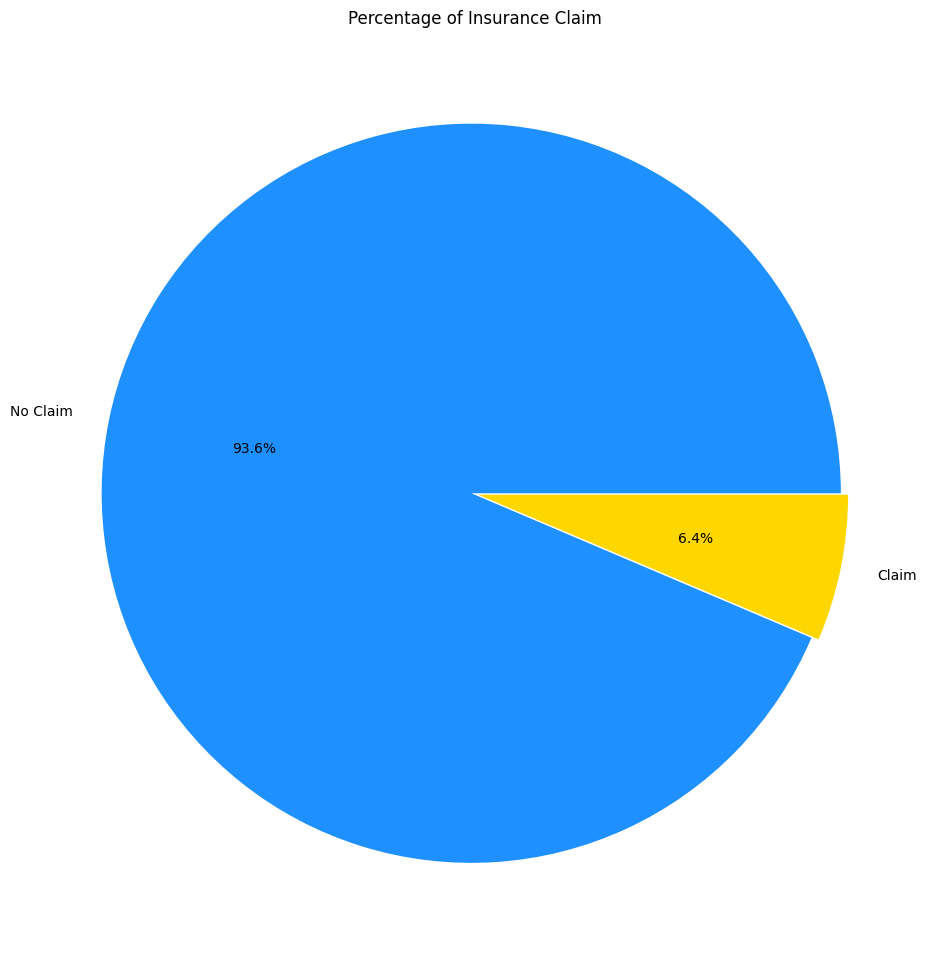

In [18]:
# Pie plot of the target variable
labels = {0: 'No Claim', 1: 'Claim'}
mapped_labels = [labels[i] for i in data['is_claim'].value_counts().index]

plt.figure(figsize=plot_sizes[1])
plt.pie(data[target_col].value_counts(), labels=mapped_labels, autopct='%1.1f%%', explode=[0.01] * 2, colors=palettes)
plt.title('Percentage of Insurance Claim')
plt.show()

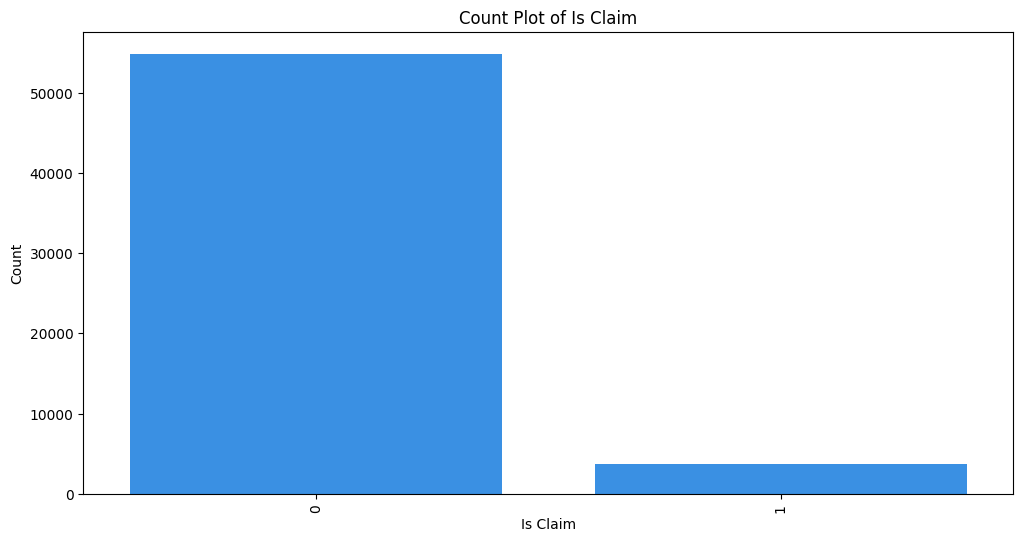

In [19]:
# plot the count plot of target column
plot_count(data,'is_claim', color=colors[0], rotation=90)

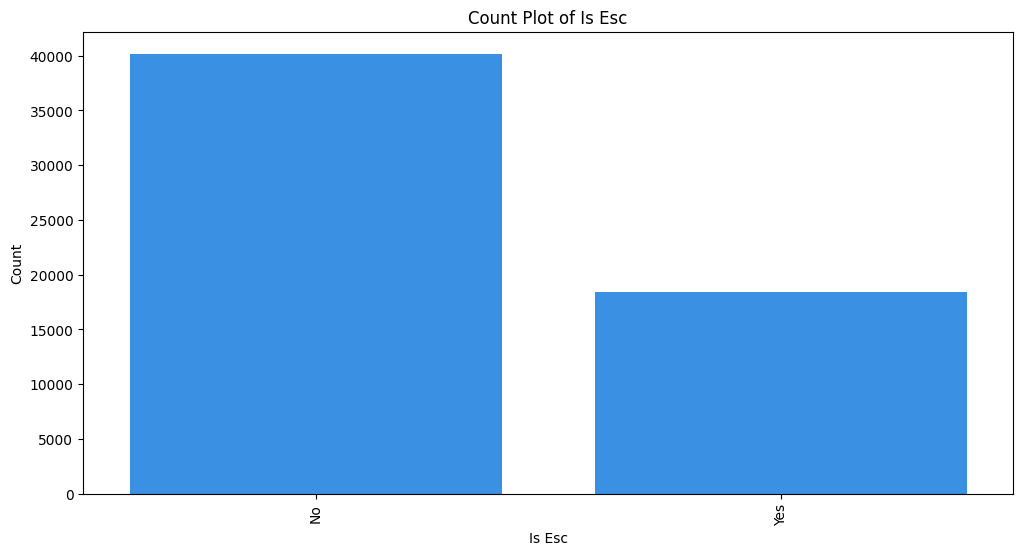

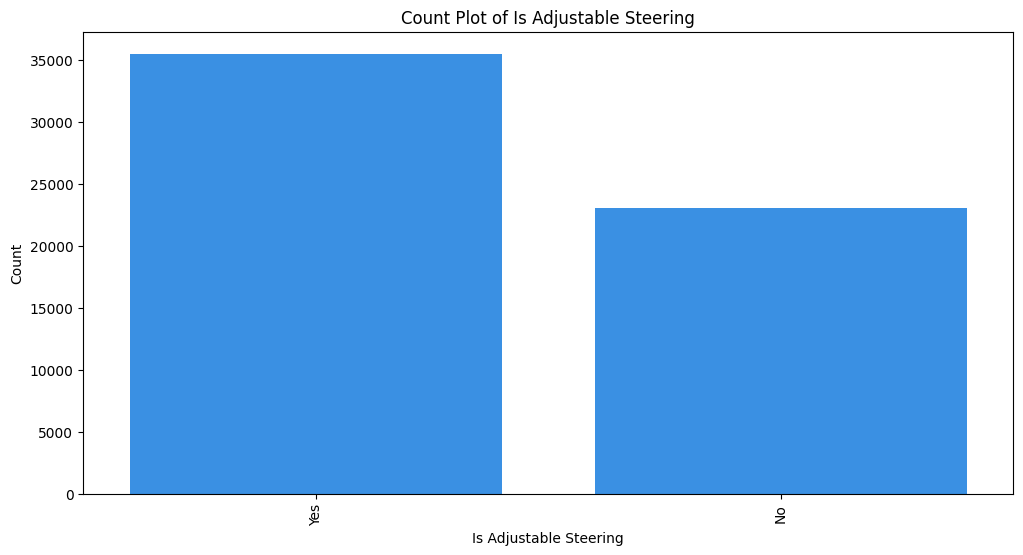

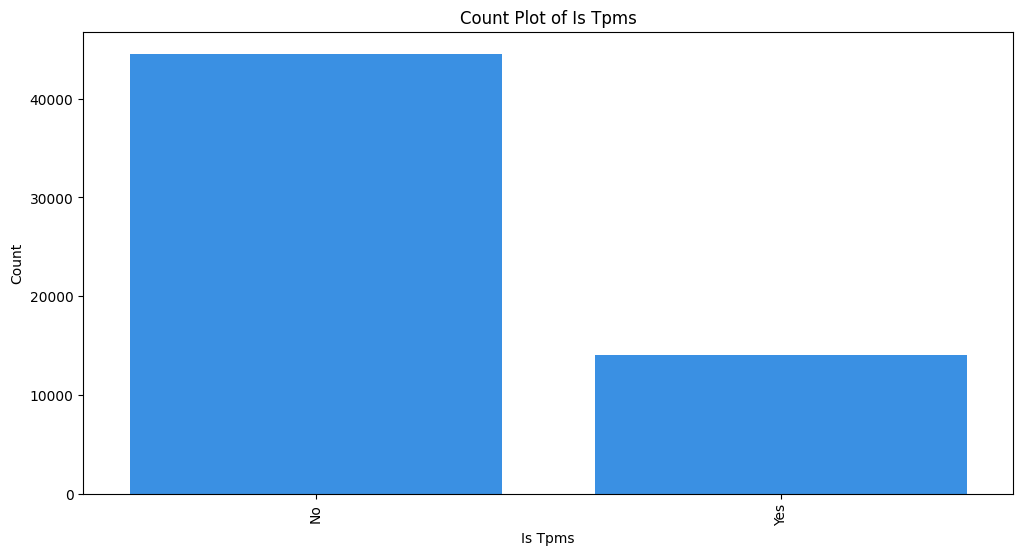

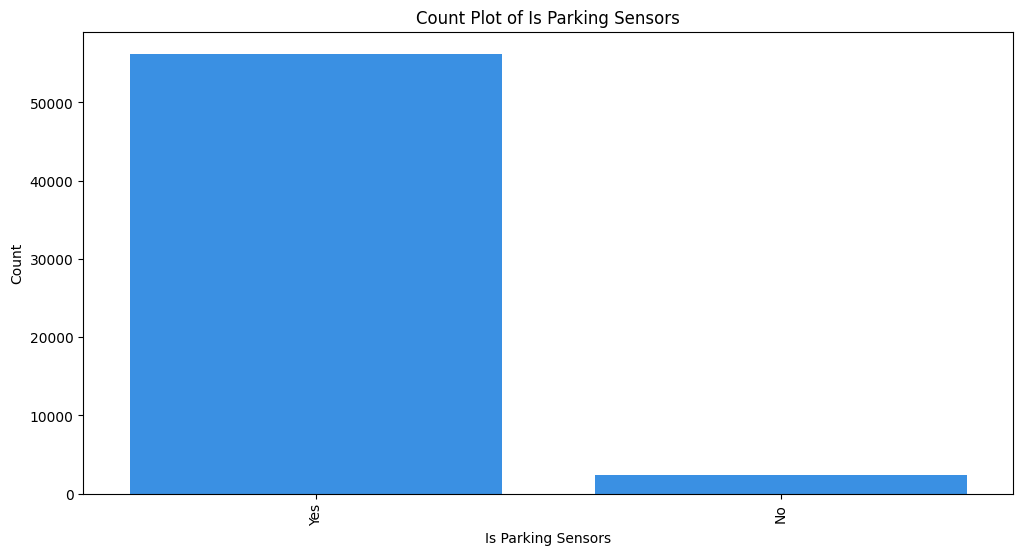

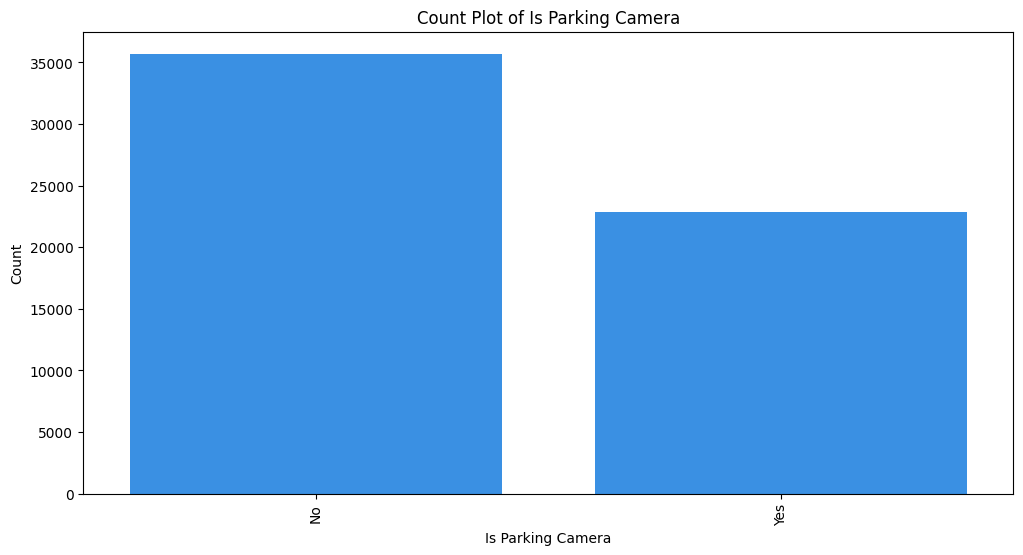

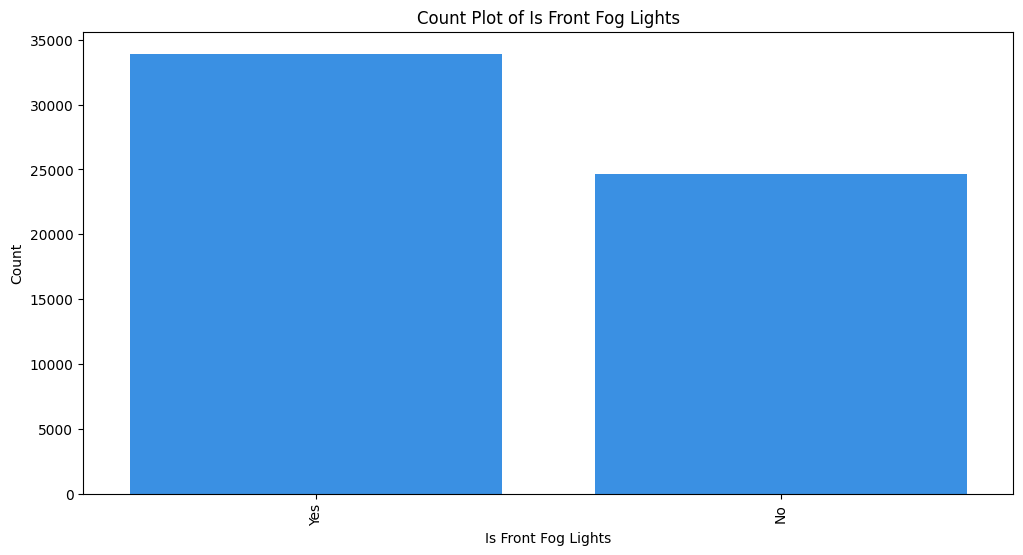

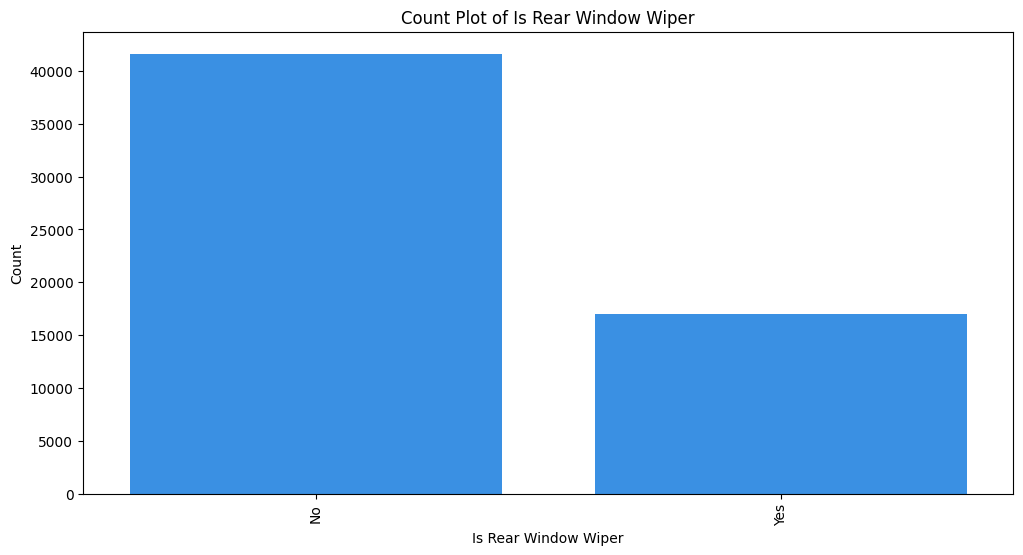

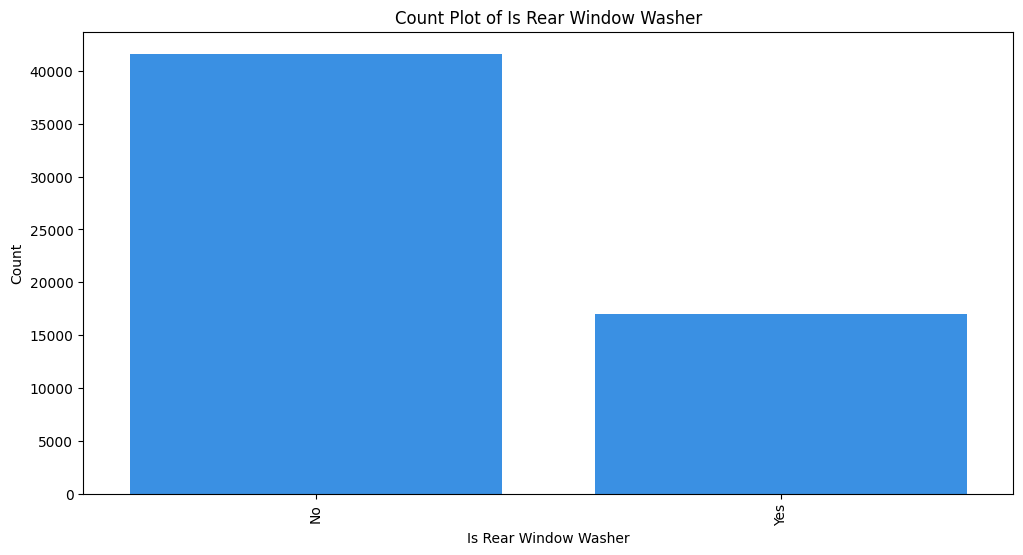

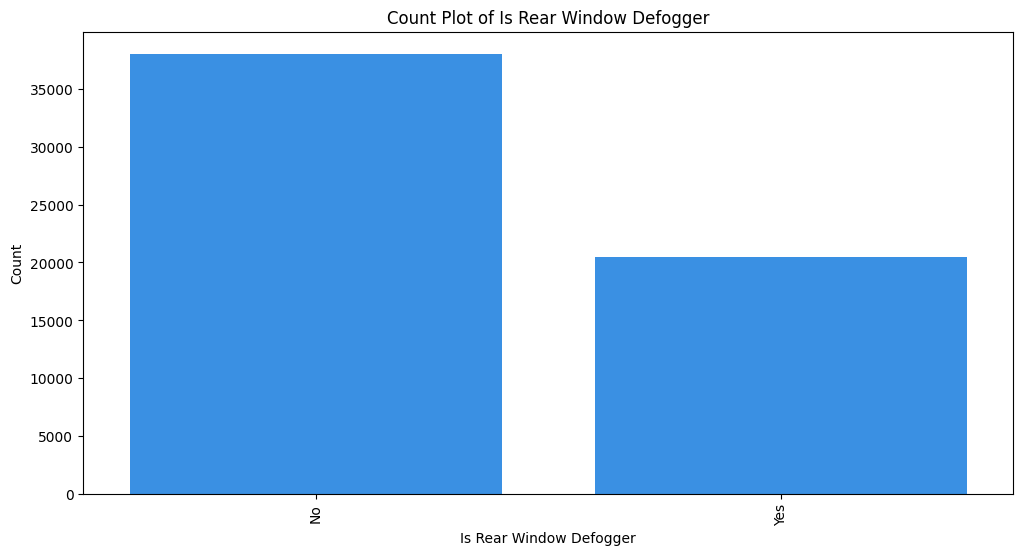

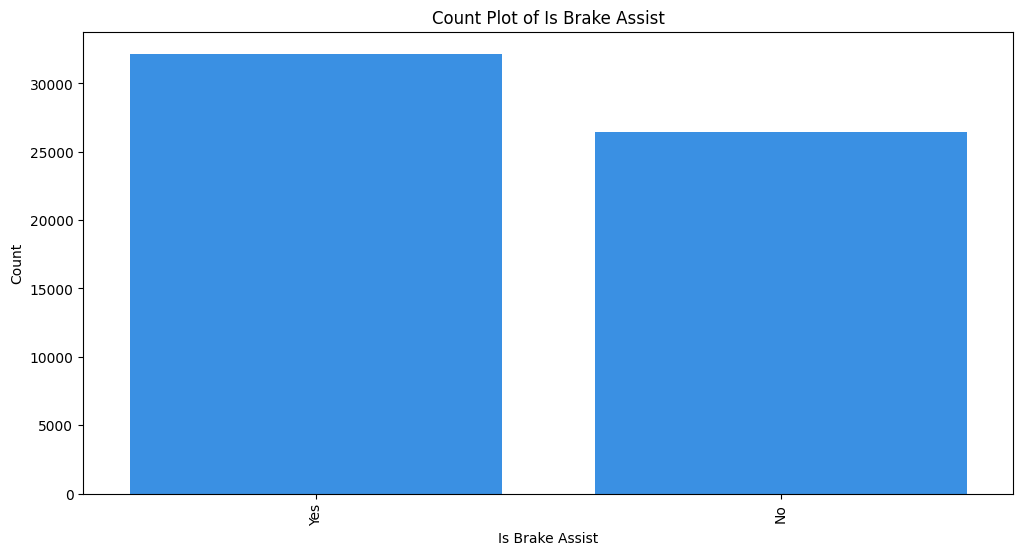

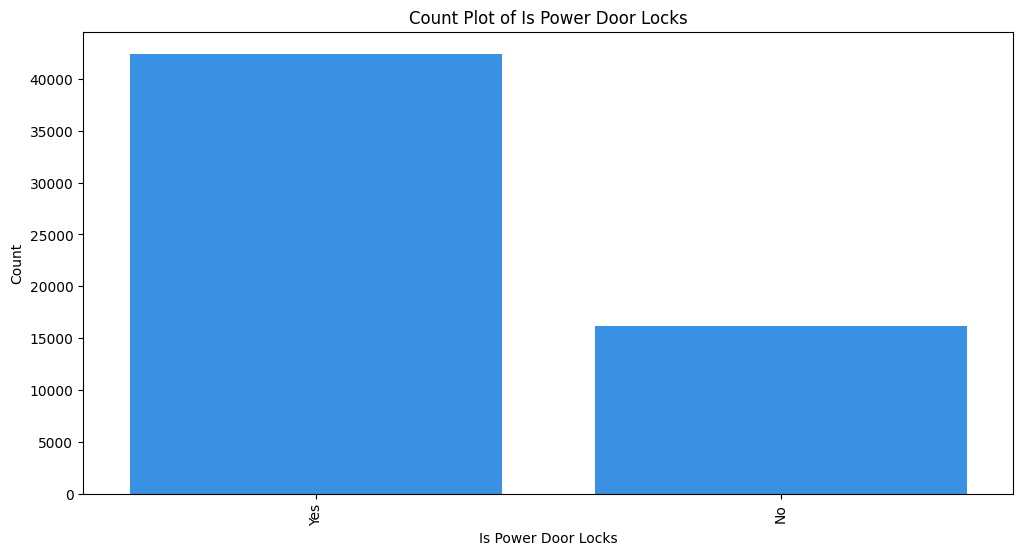

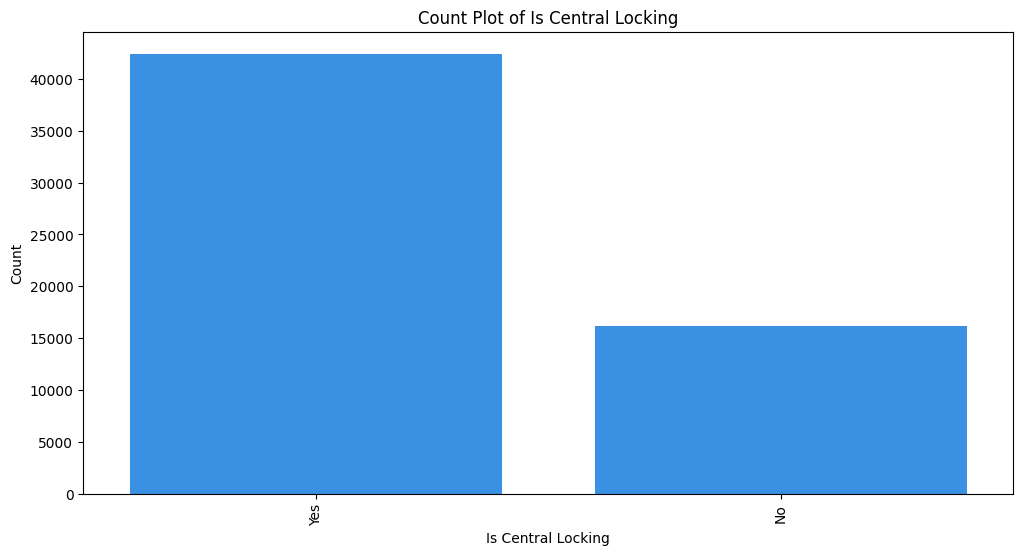

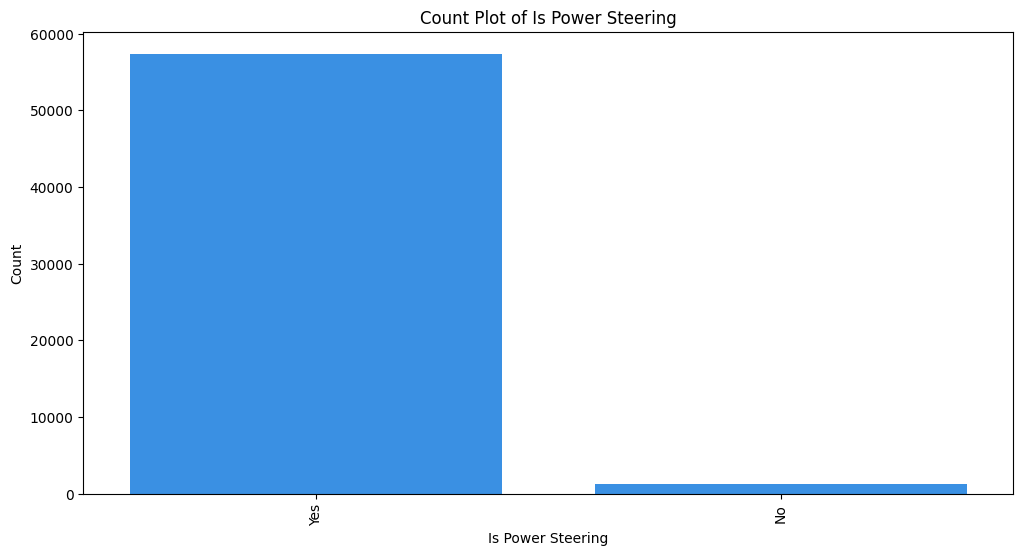

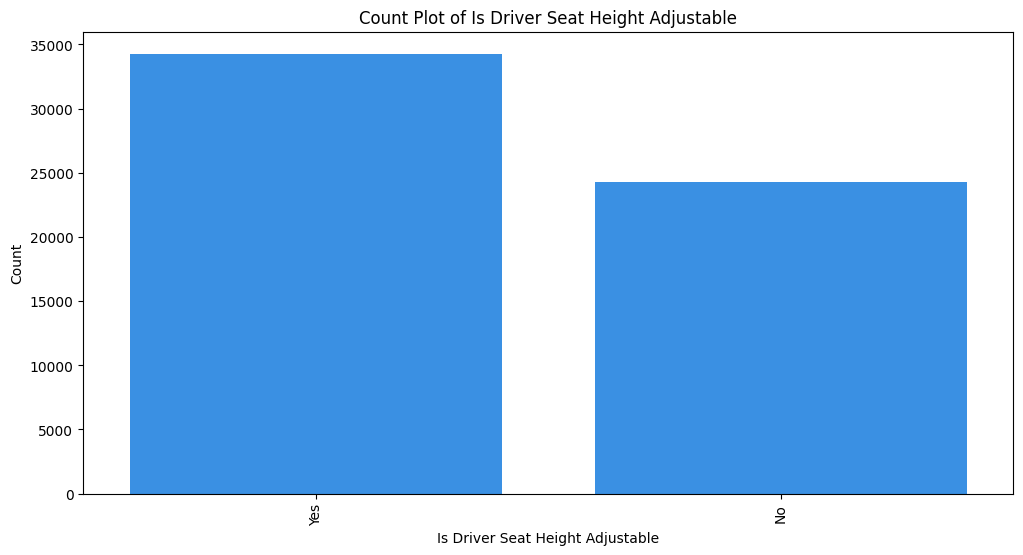

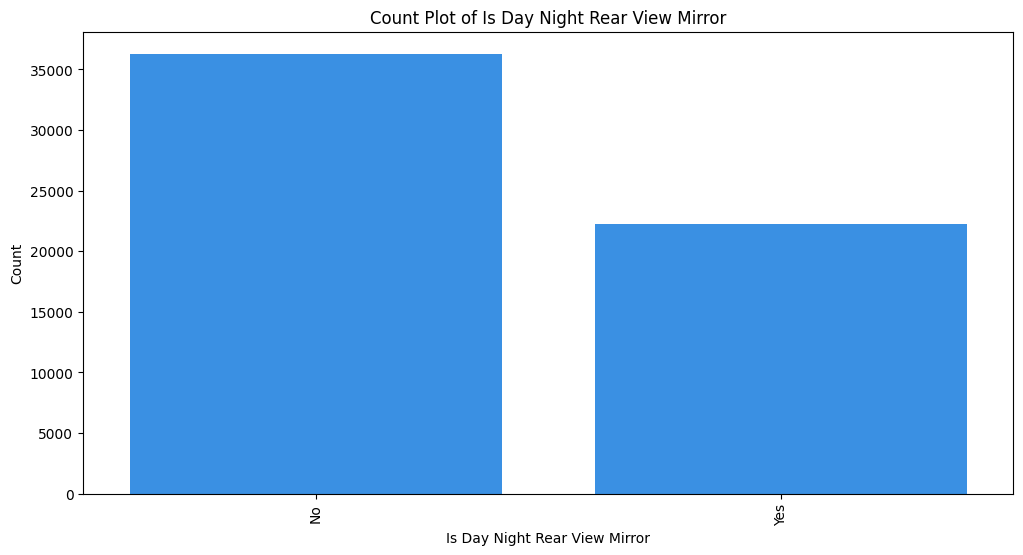

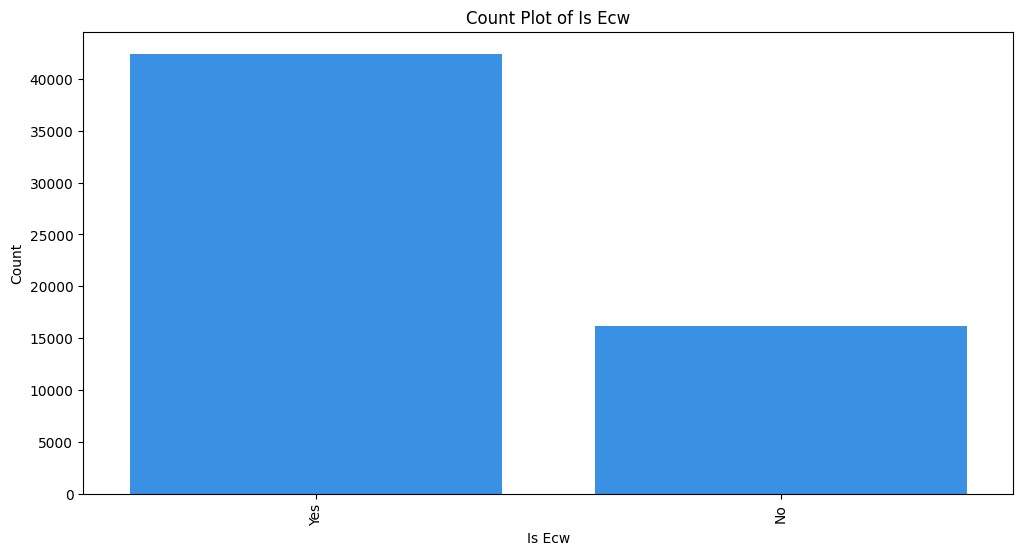

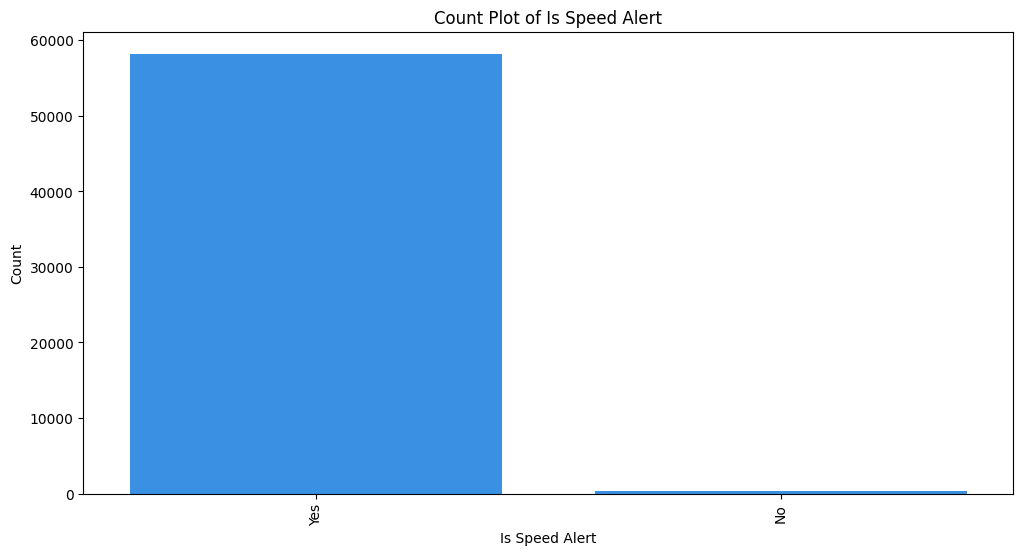

In [20]:
# Loop through each binary column and plot the count plot
for column in binary_col:
    plot_count(data, column, color=colors[0], rotation=90)

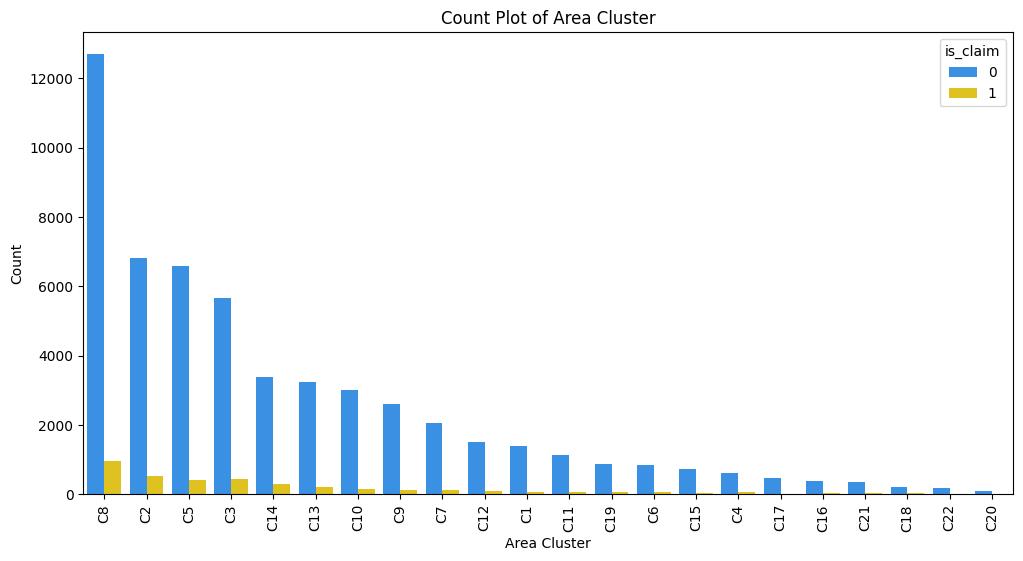

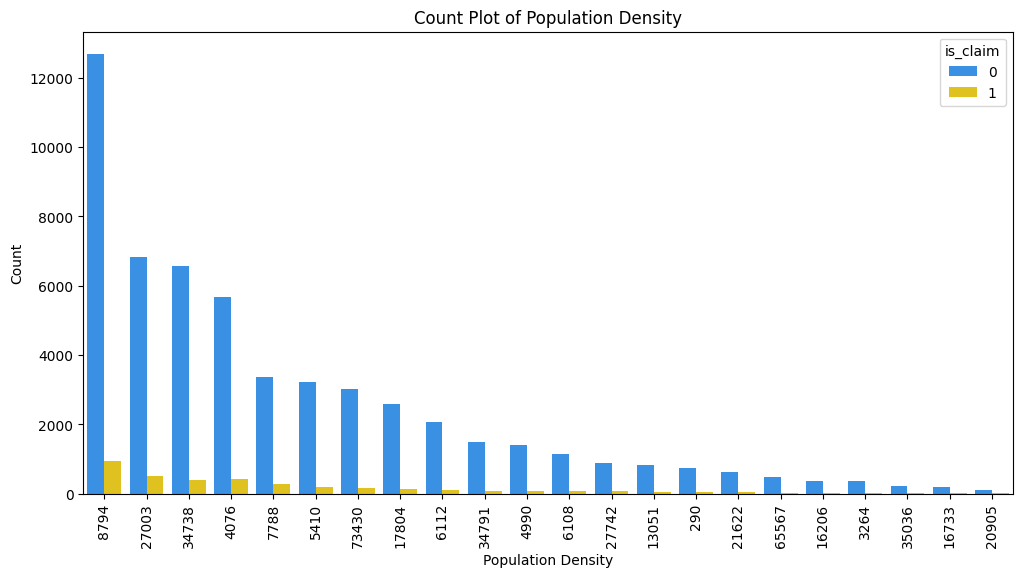

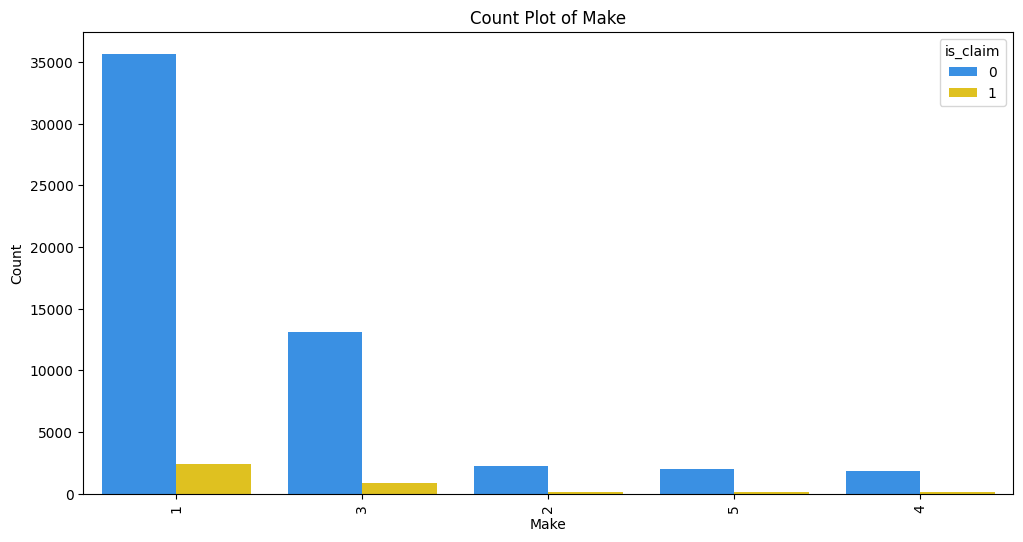

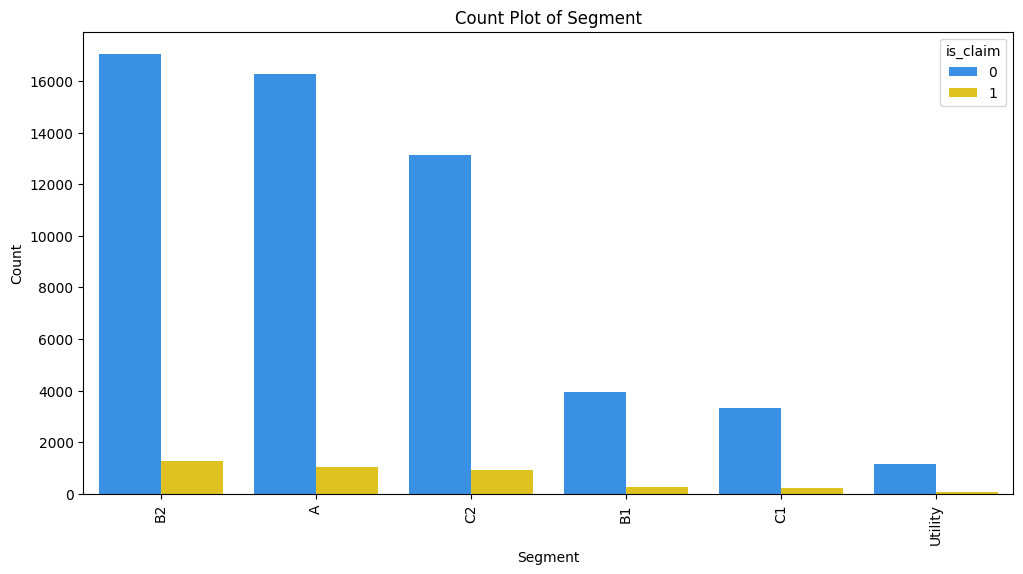

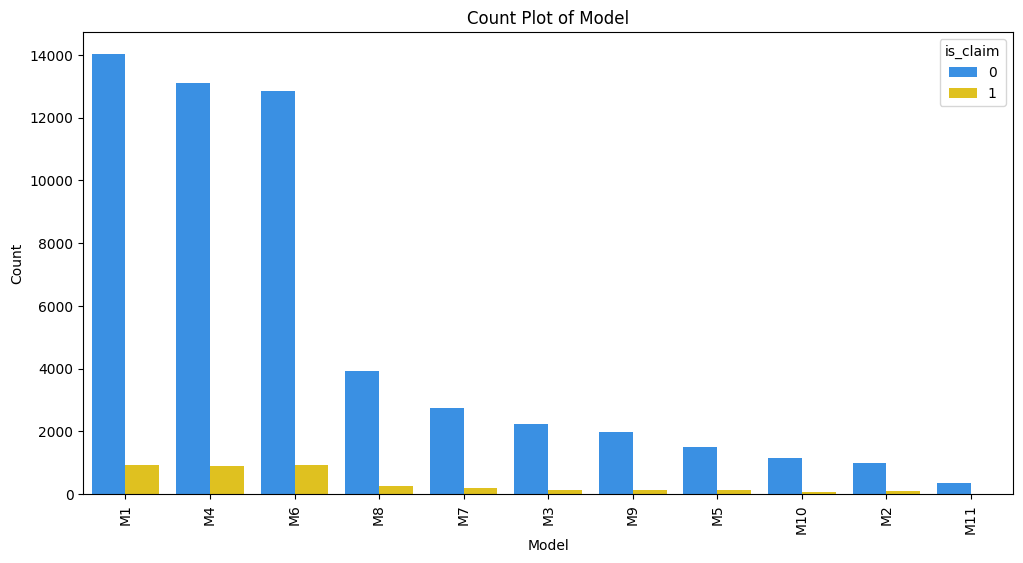

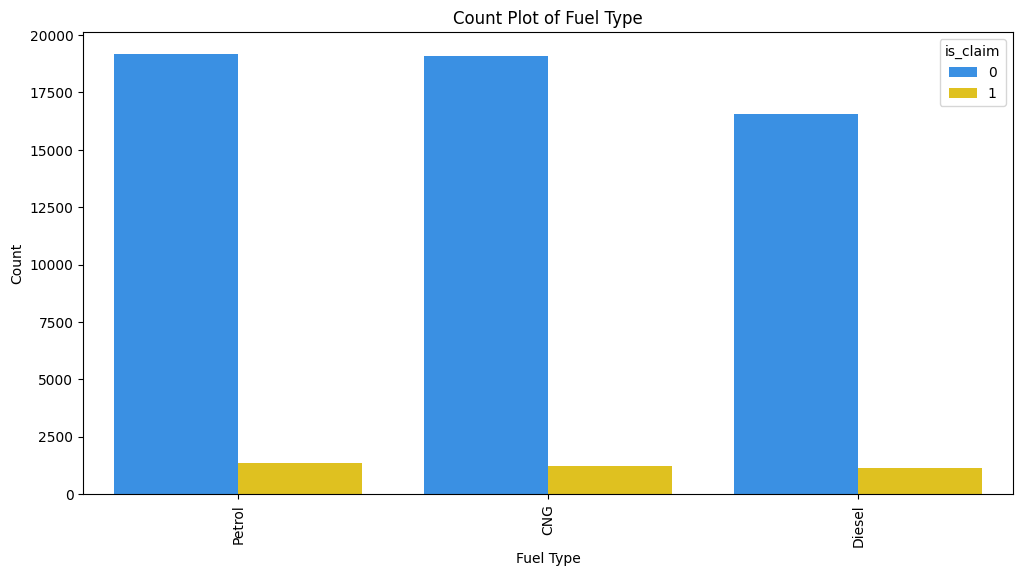

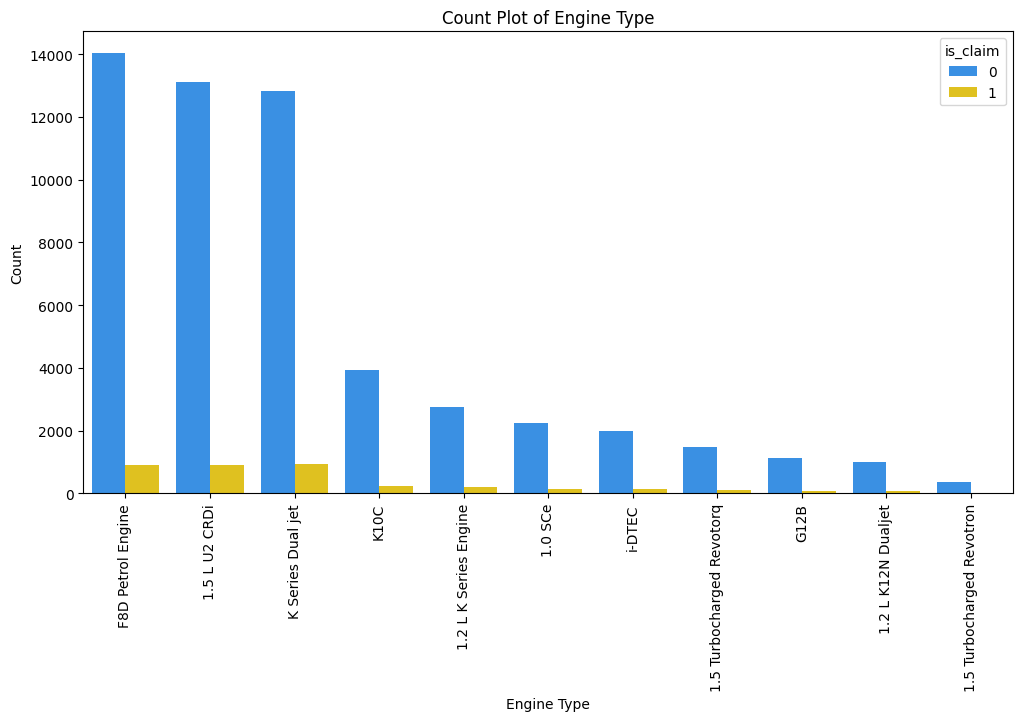

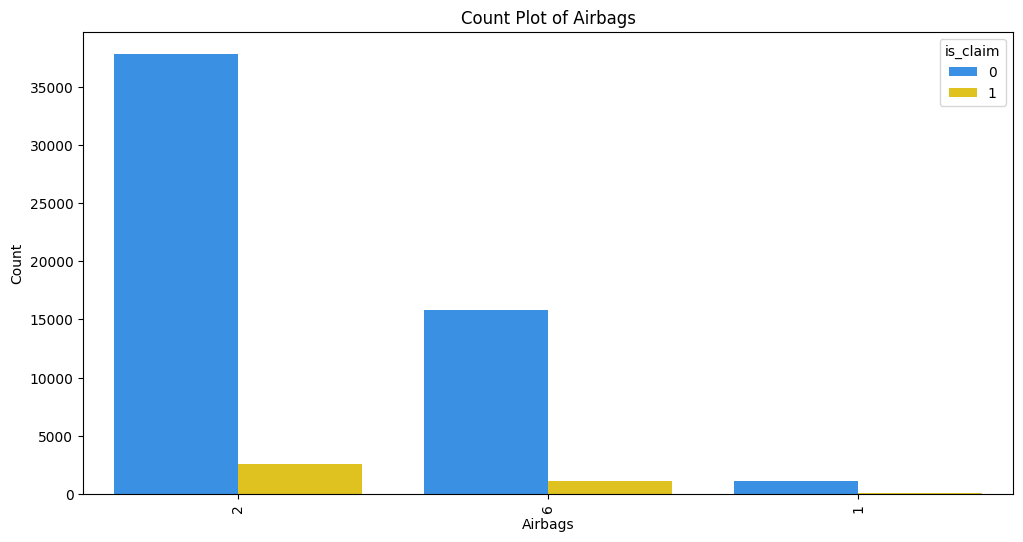

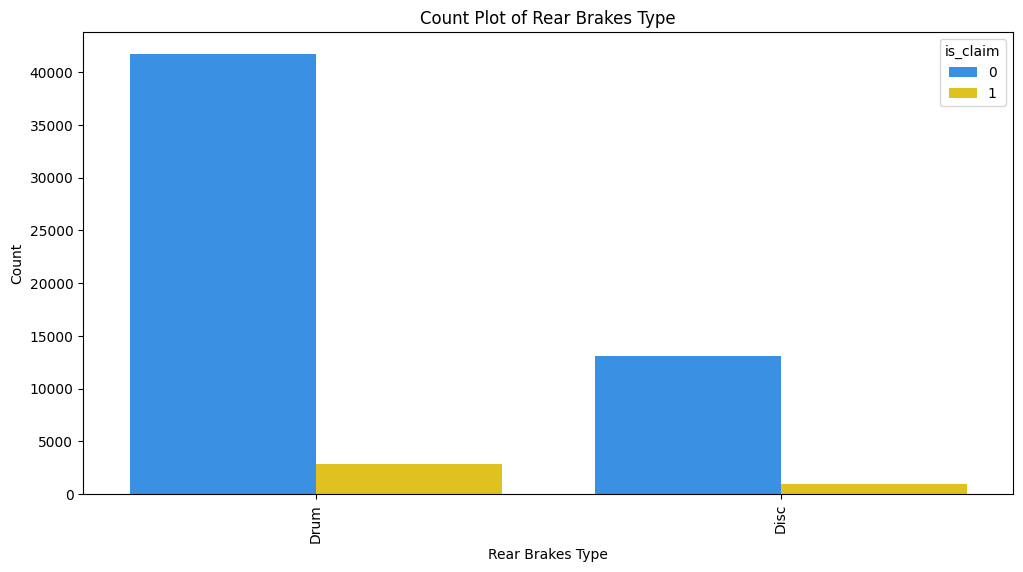

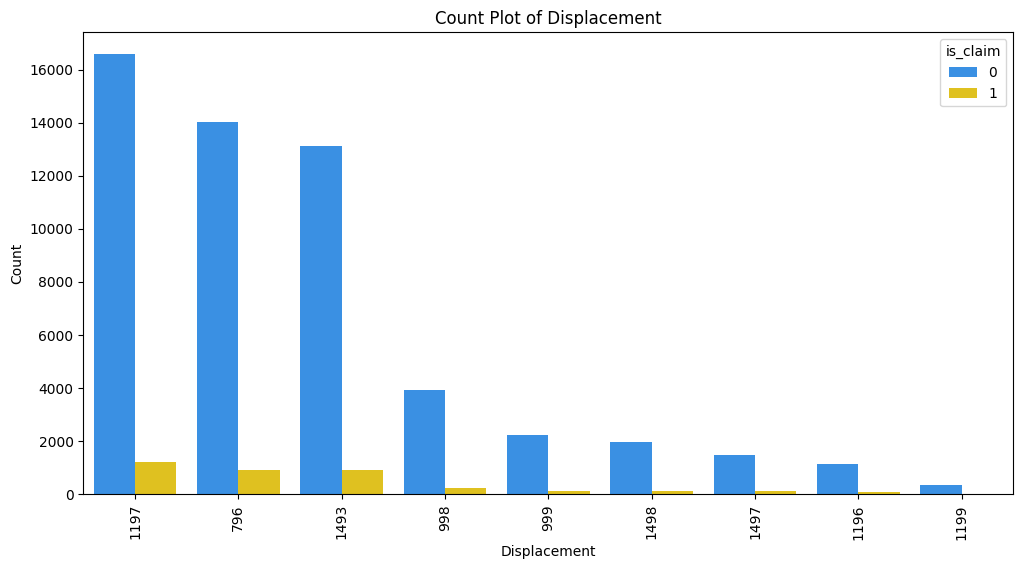

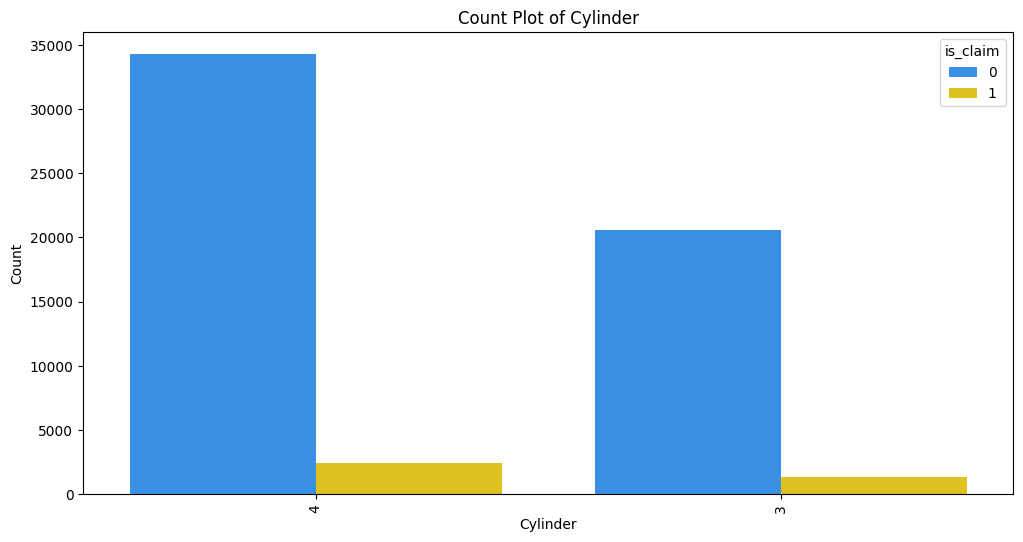

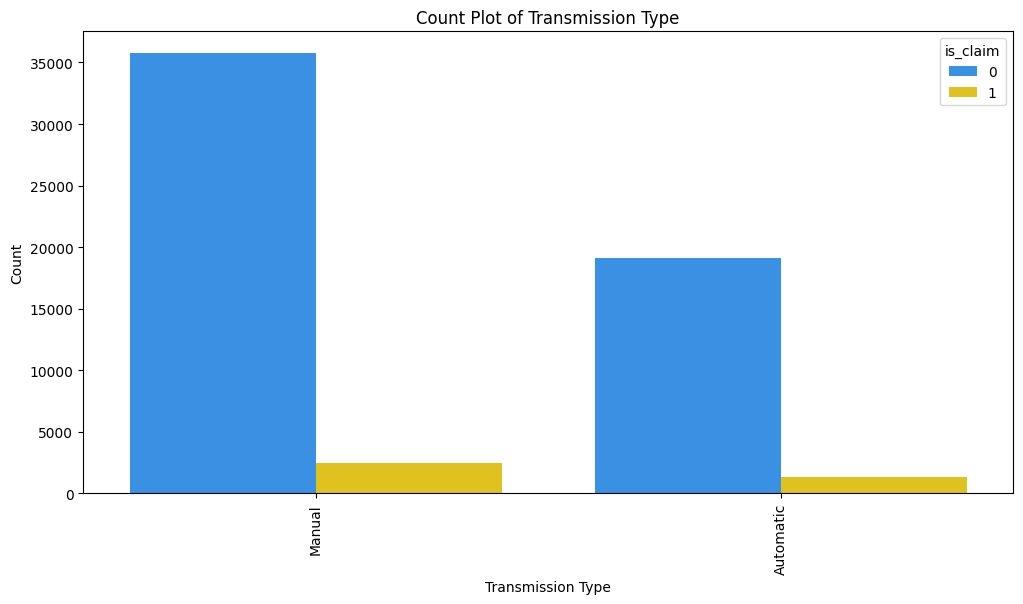

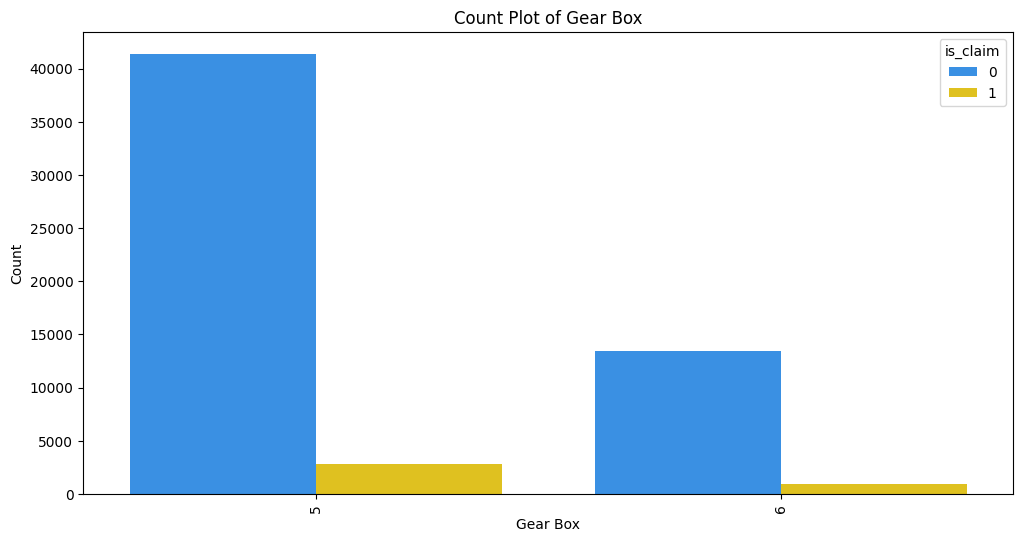

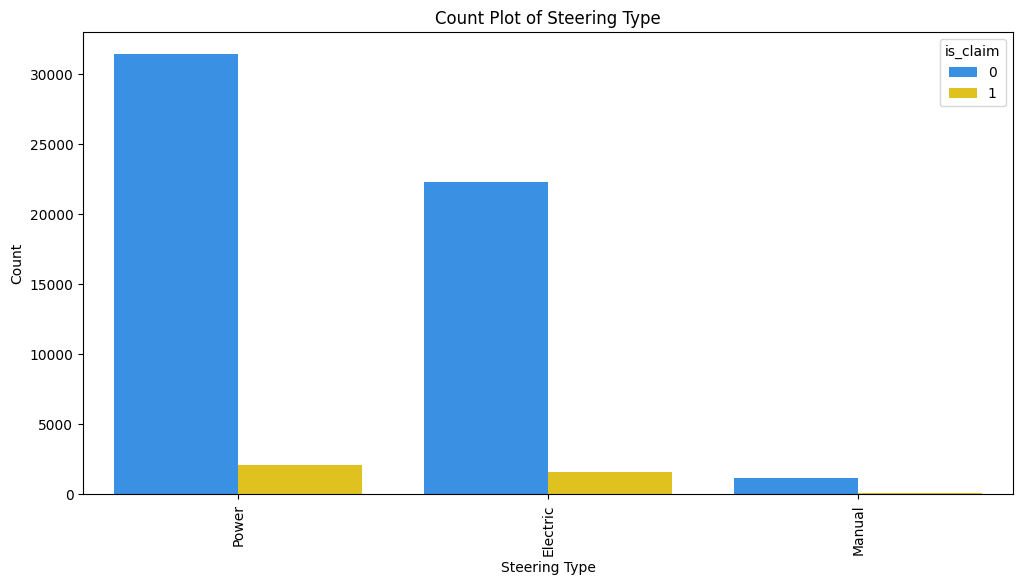

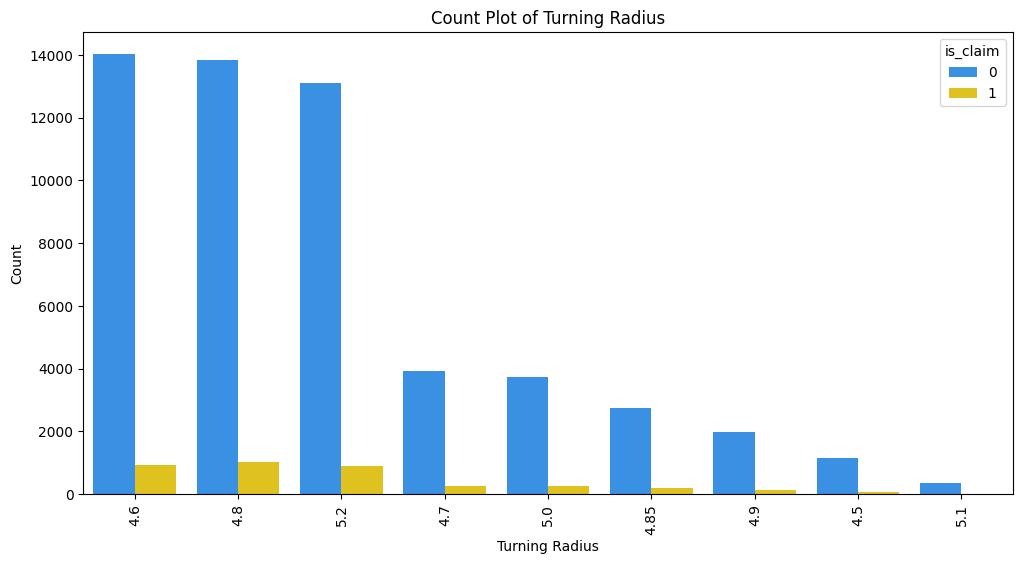

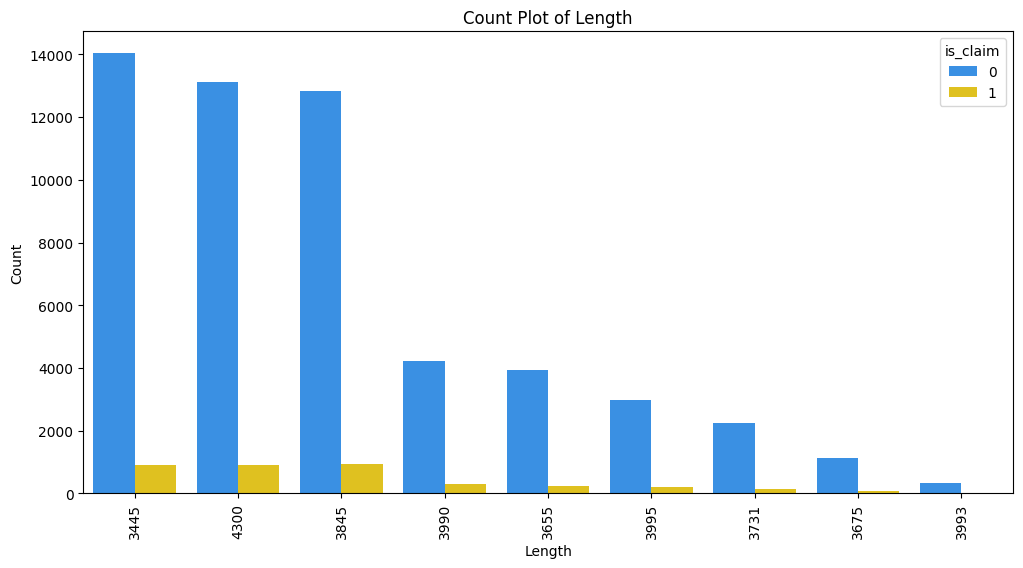

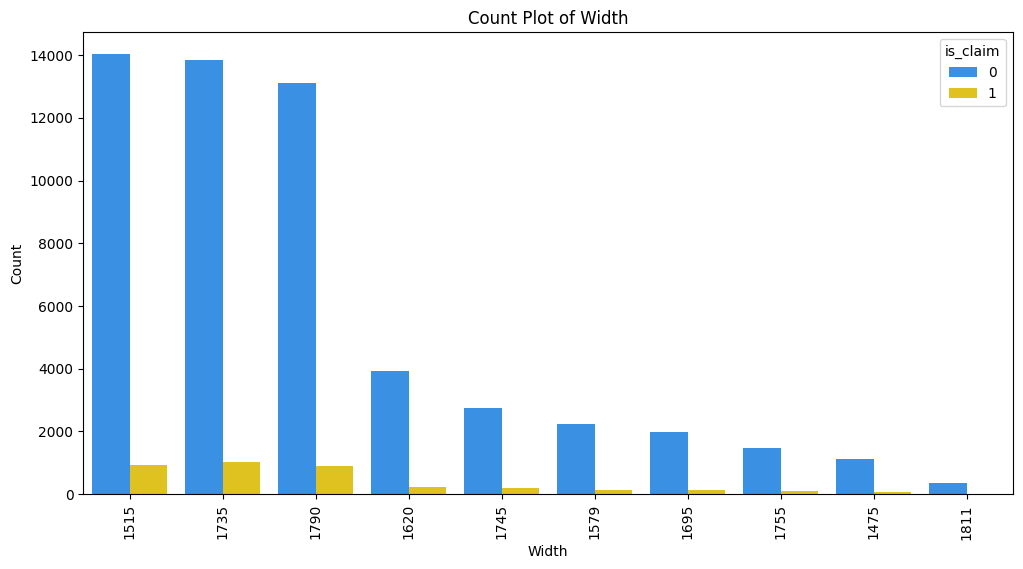

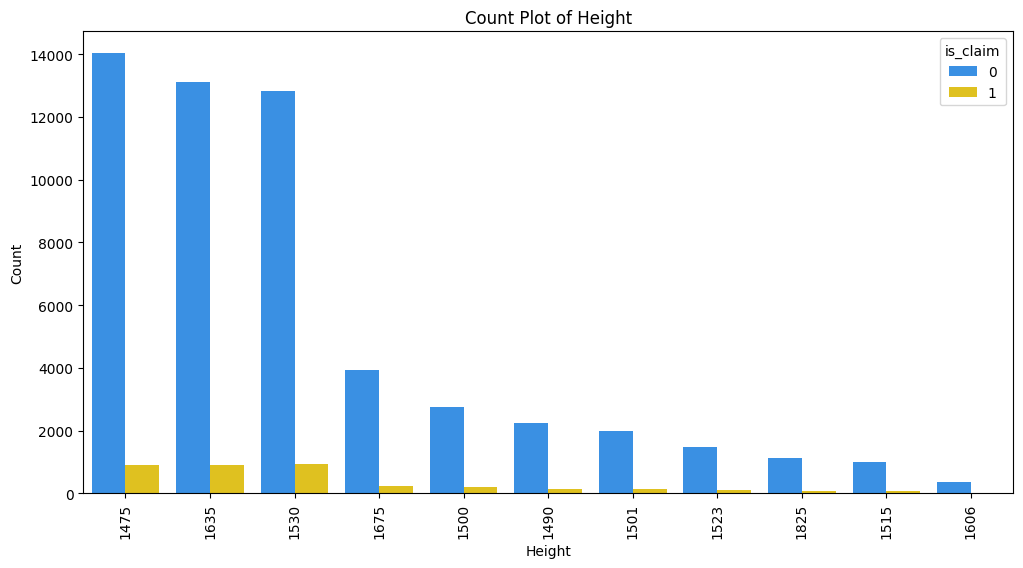

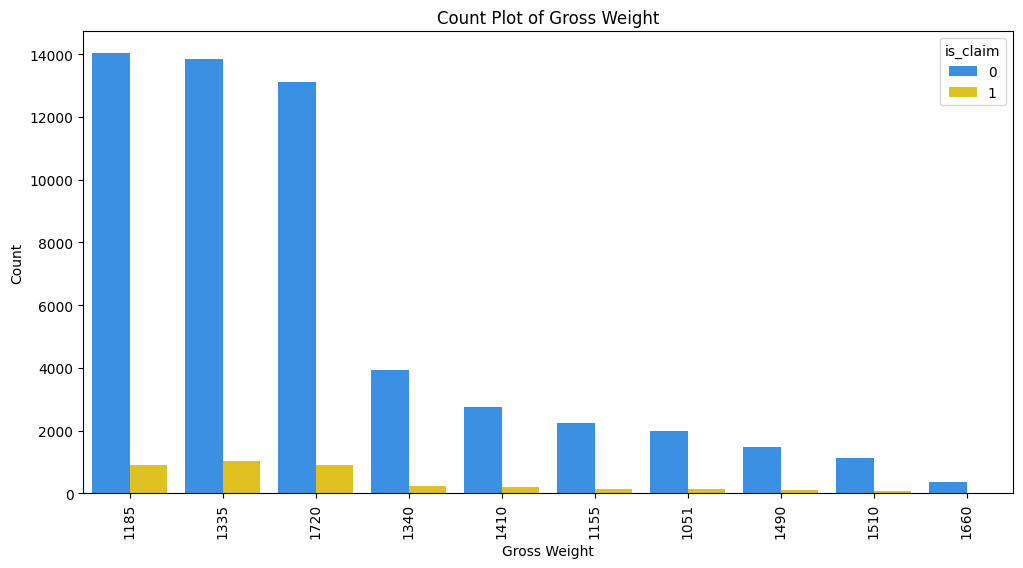

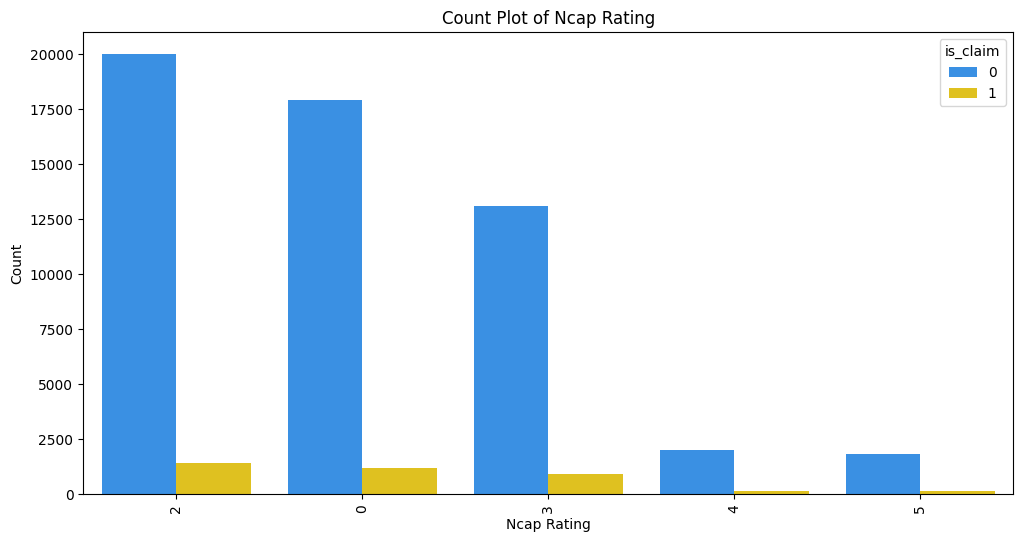

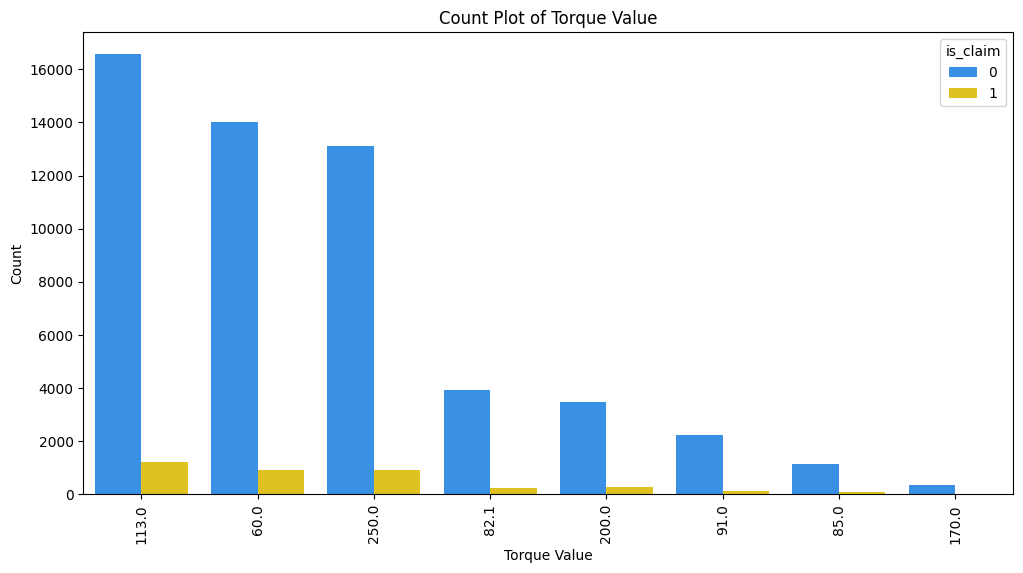

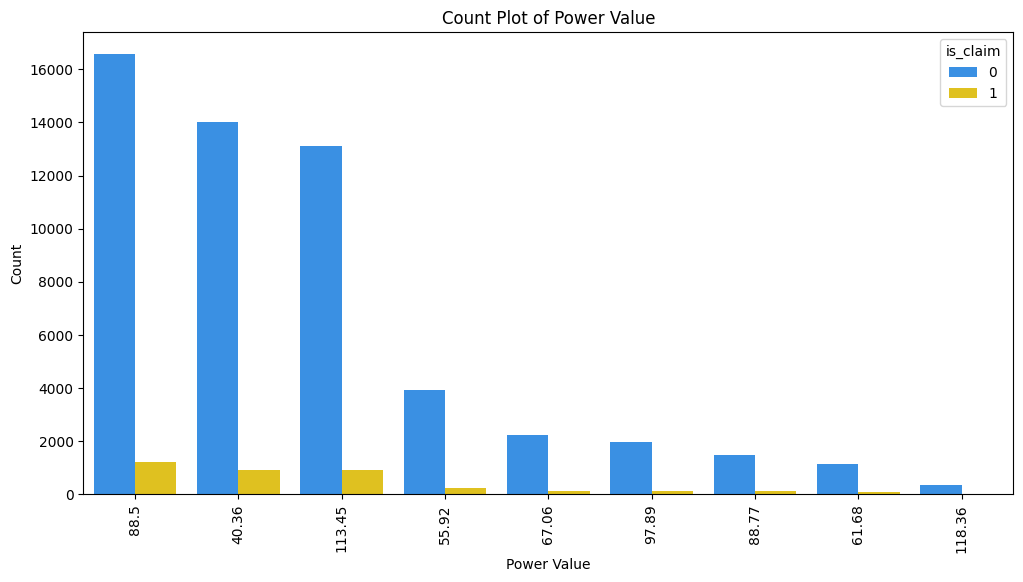

In [21]:
# Loop through each categorical column and plot the count plot
for column in categorical_col:
    plot_count(data, column, hue='is_claim', palette=palettes, rotation=90)

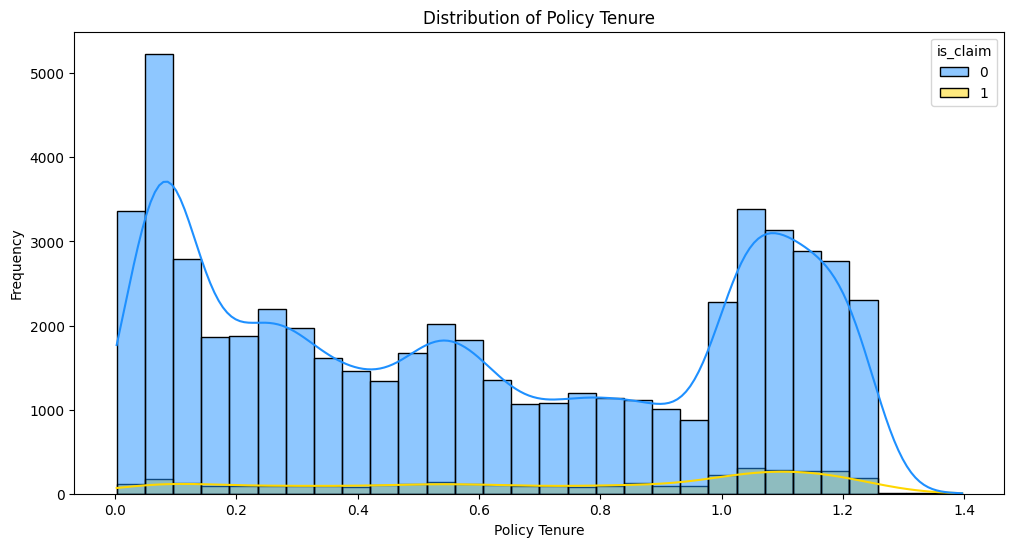

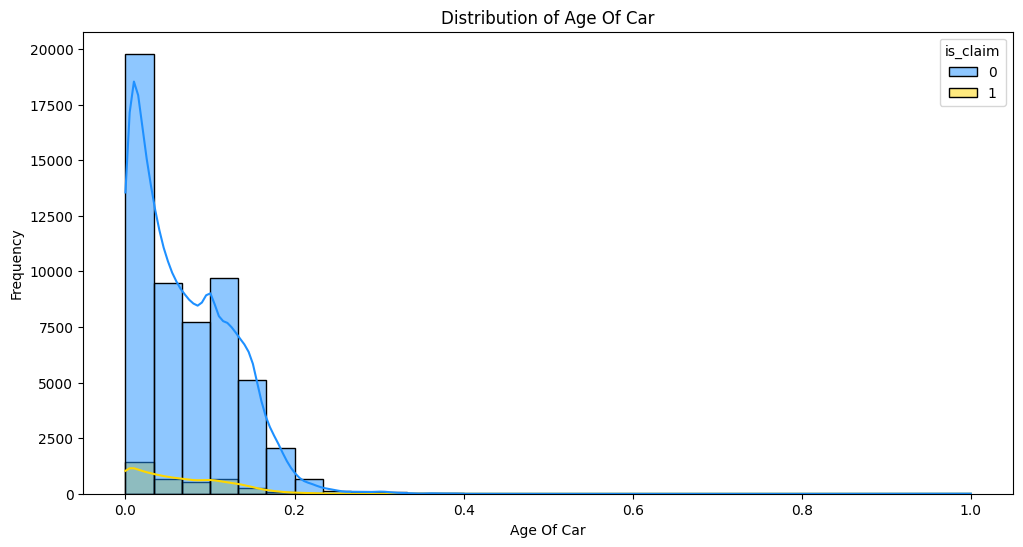

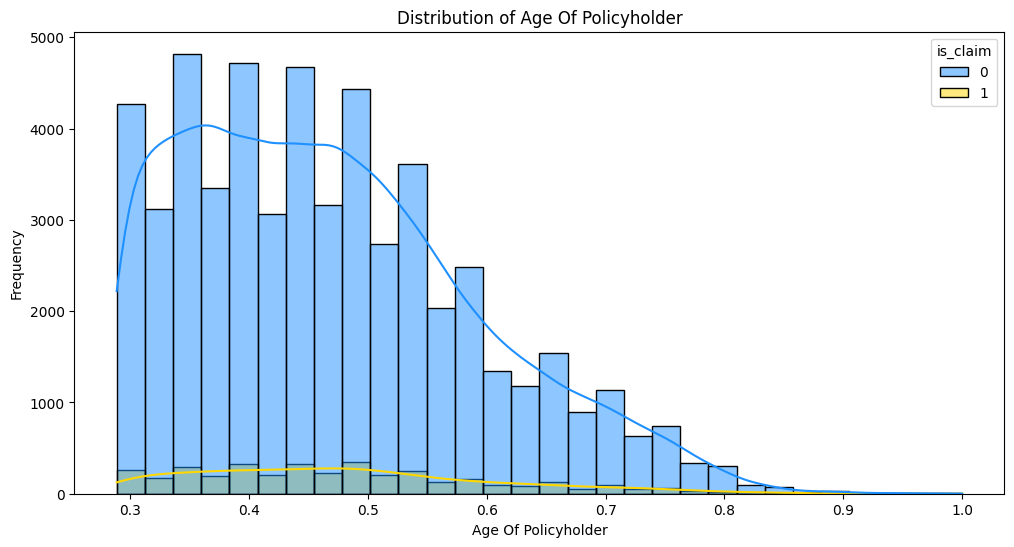

In [22]:
# Loop through each numerical column and plot the distribution plot
for column in numerical_col:
    plot_distribution(data, column, hue='is_claim', palette=palettes)

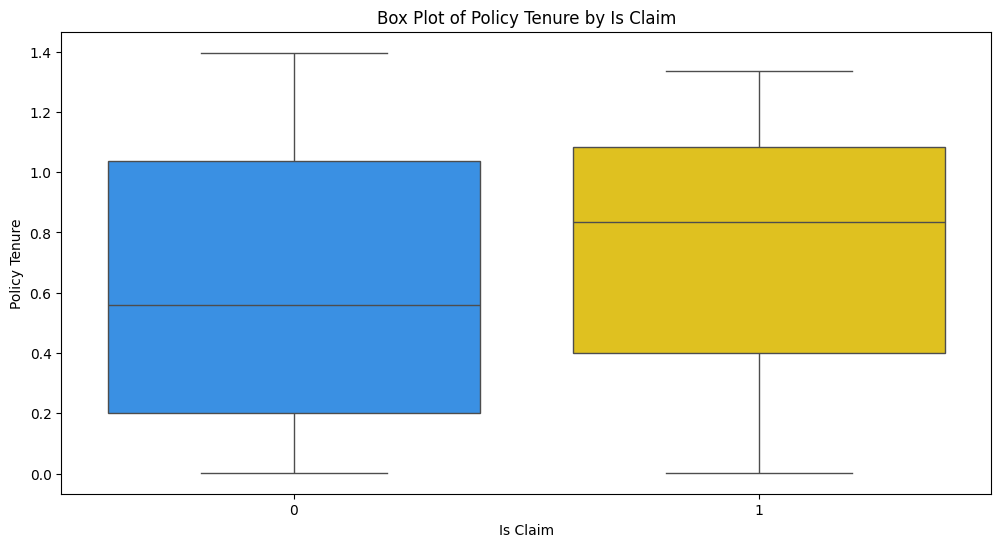

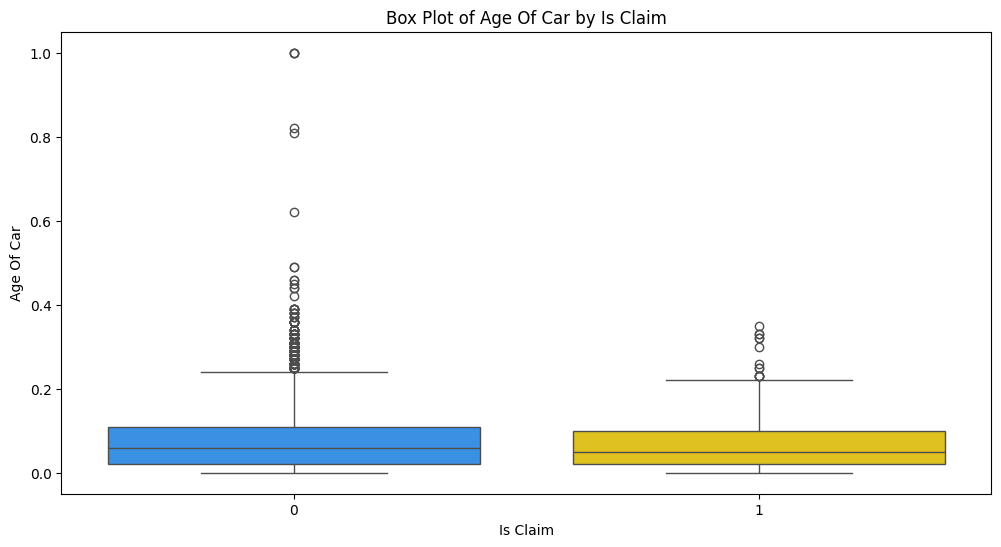

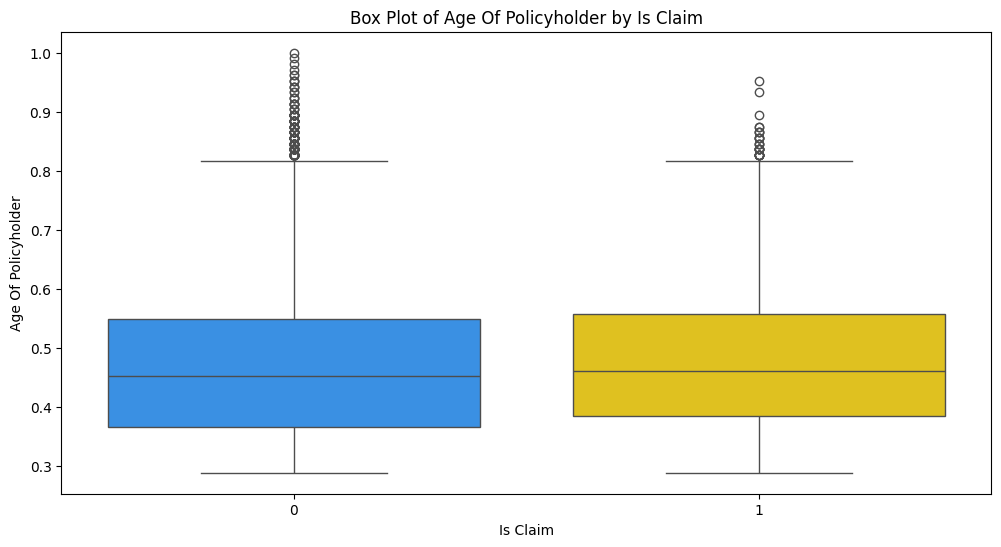

In [23]:
# Loop through each numerical column and plot the box plot
for y_column in numerical_col:
    plot_box(data, y_column, palette=palettes)

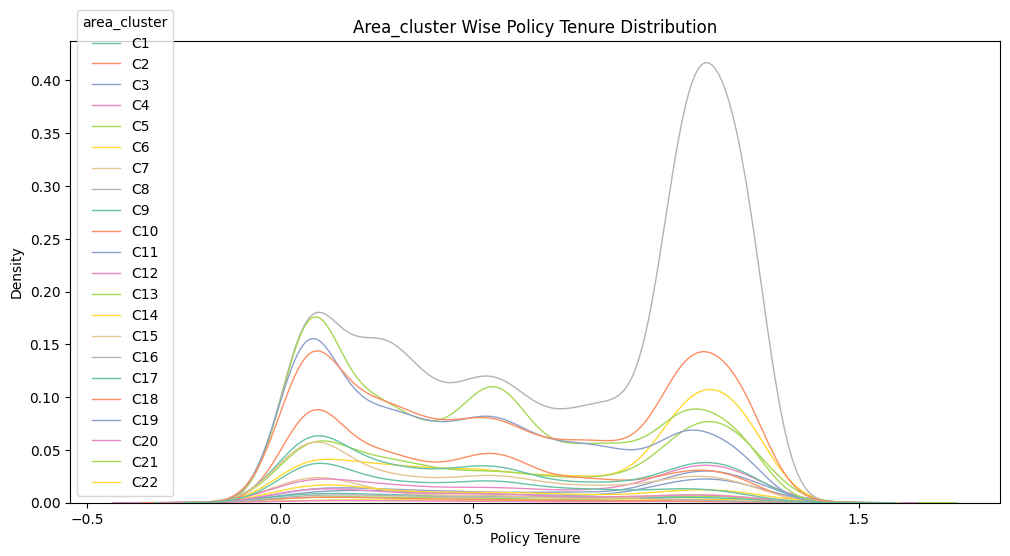

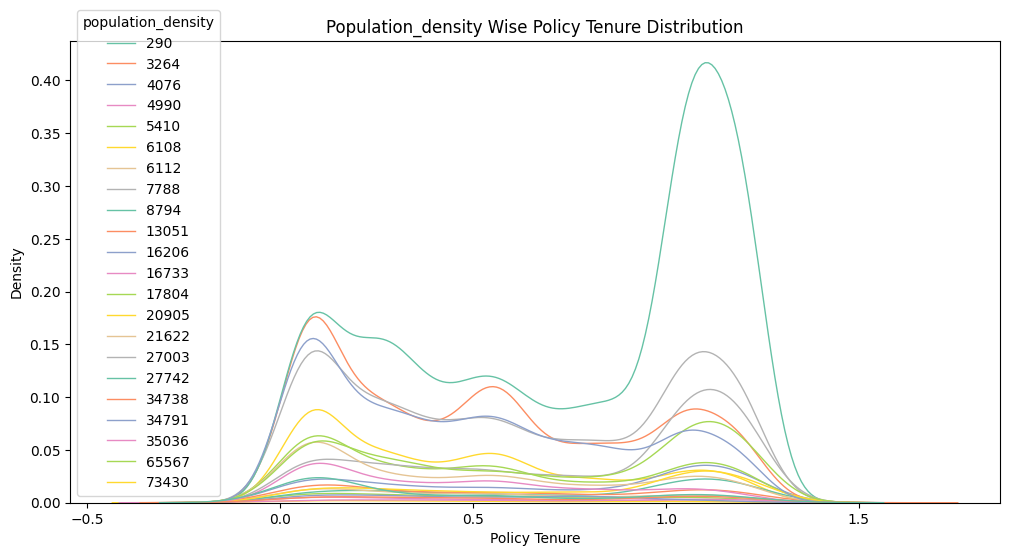

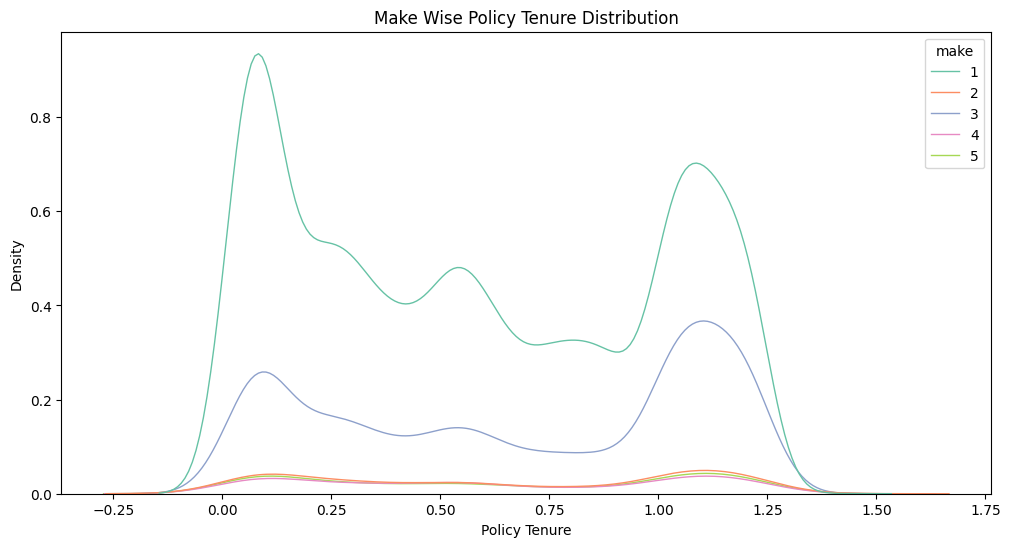

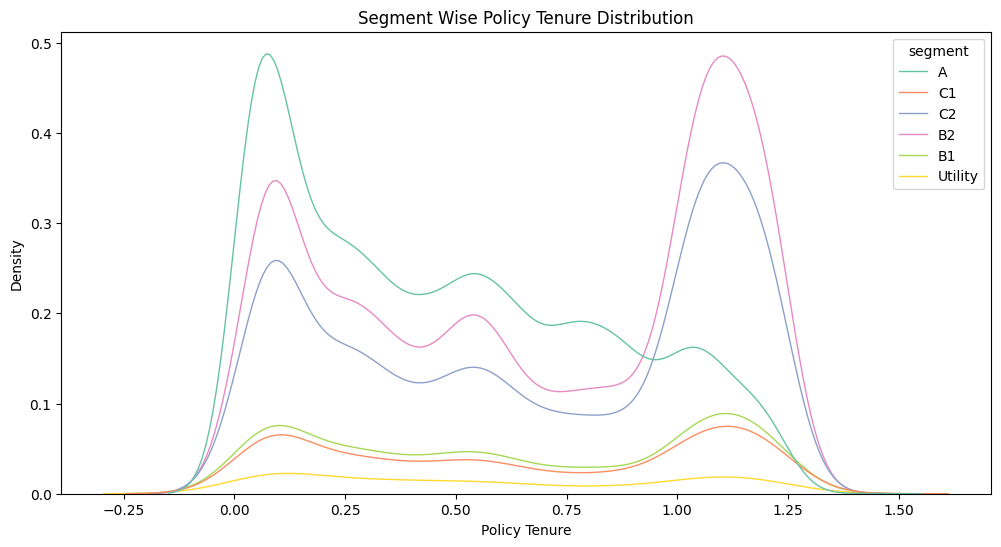

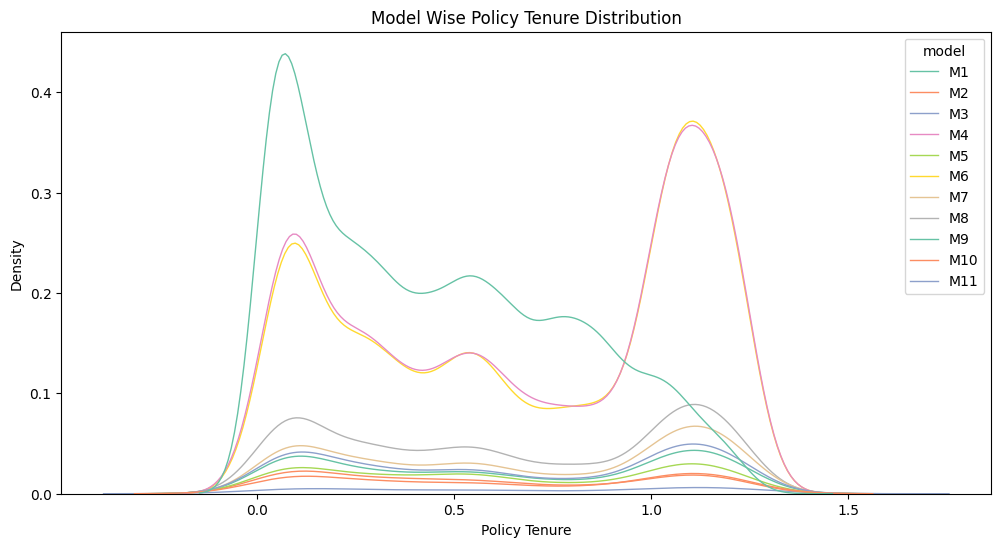

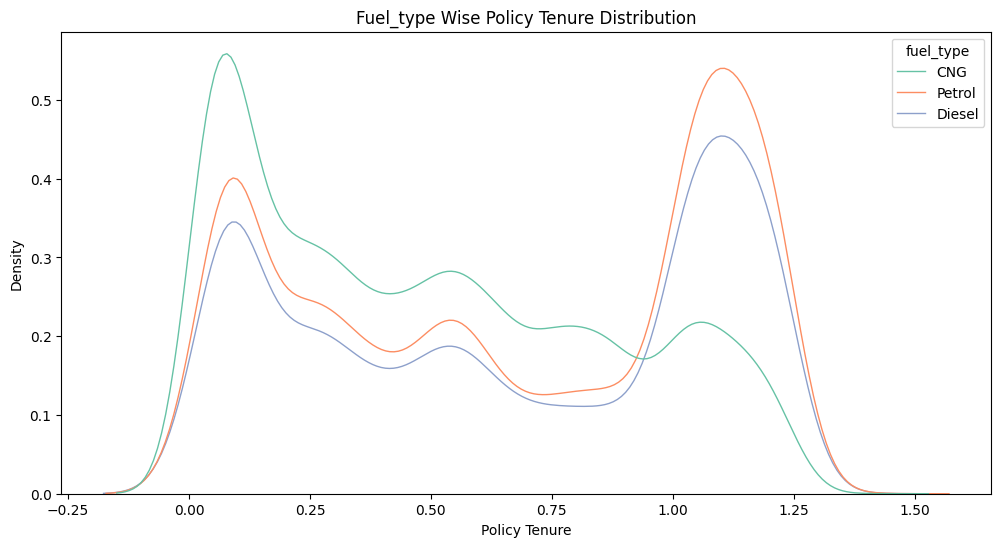

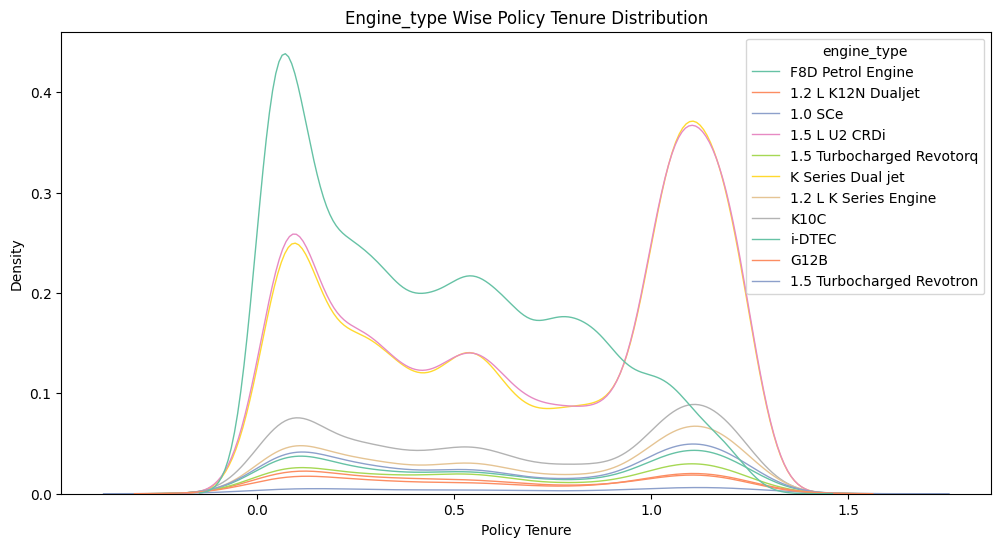

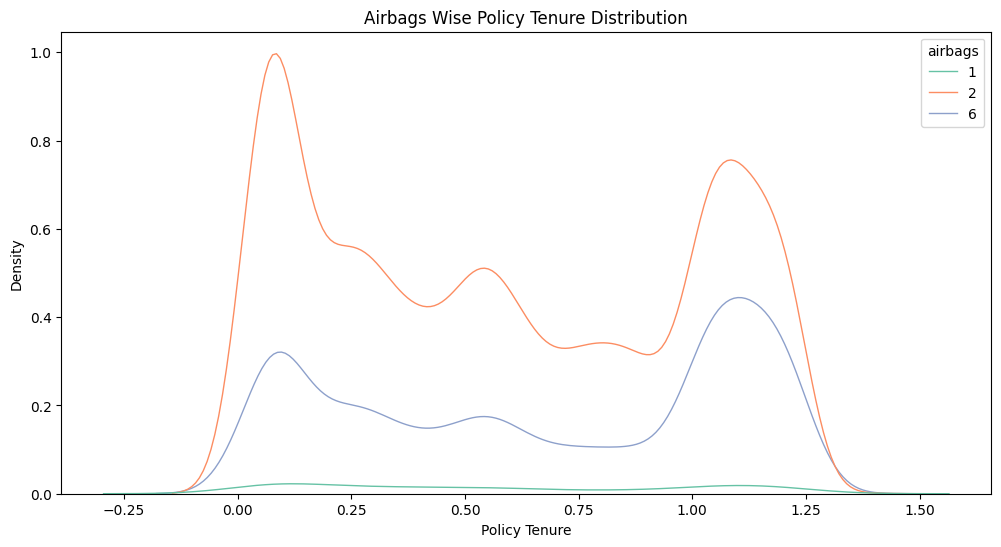

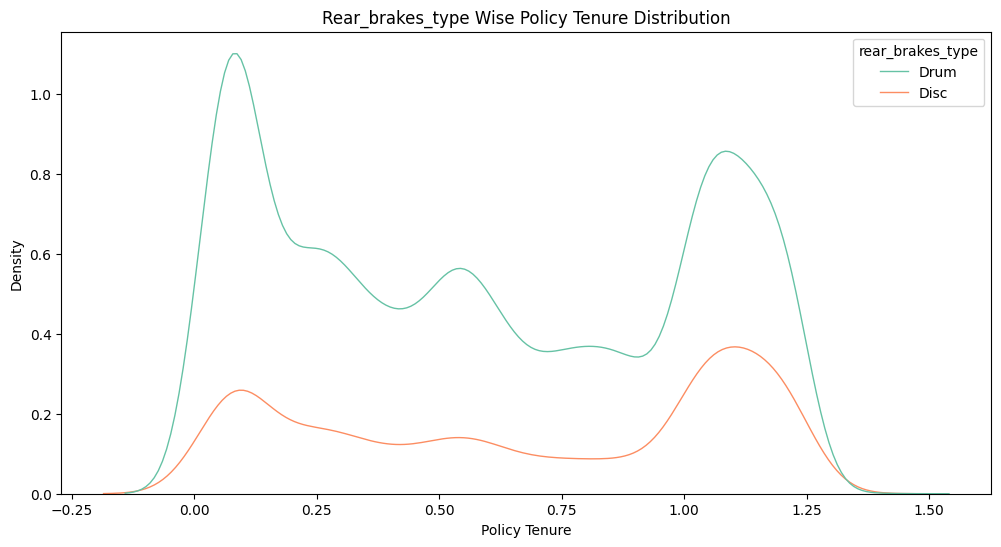

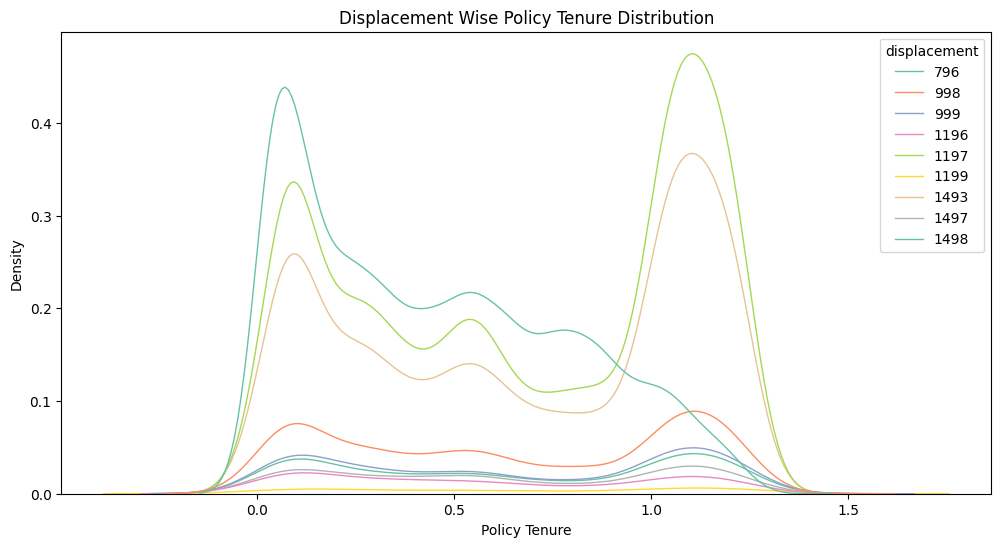

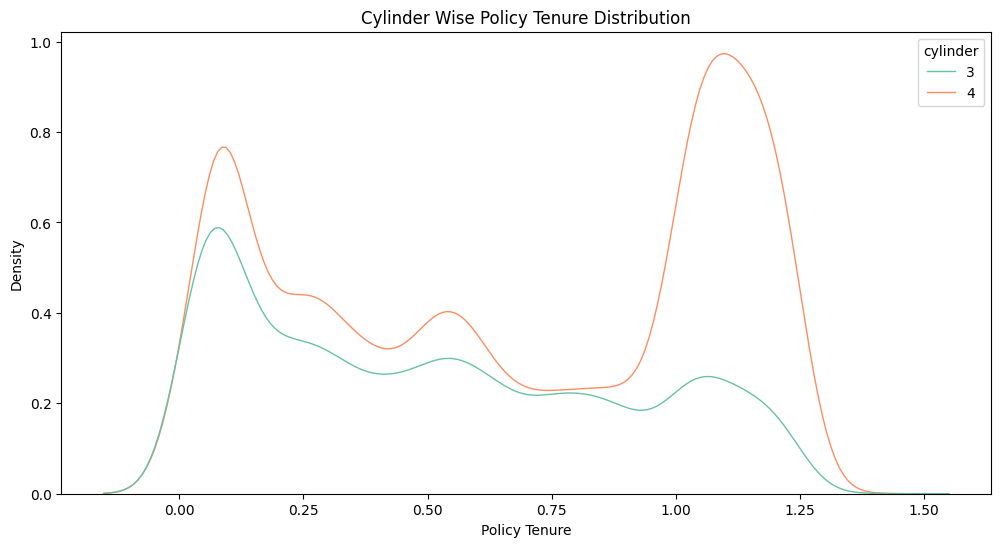

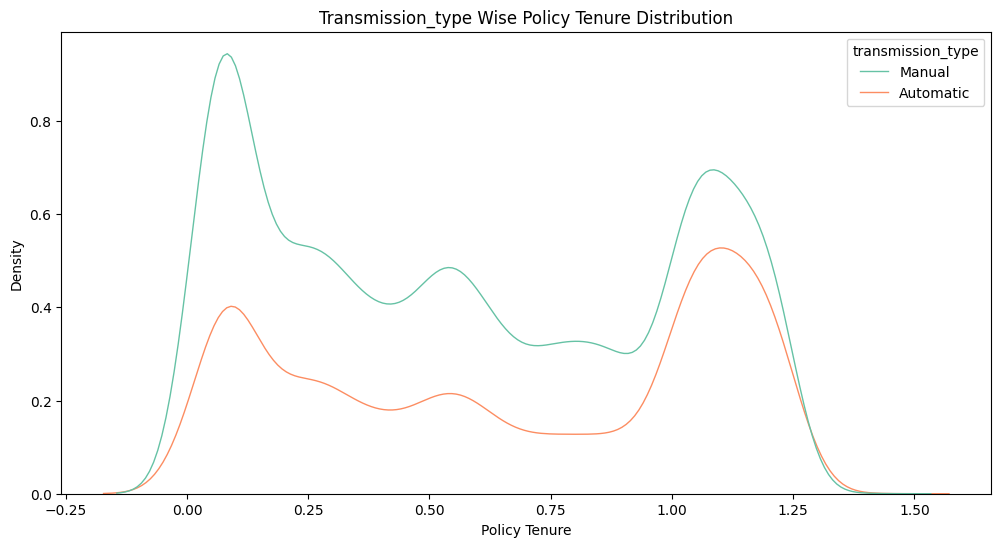

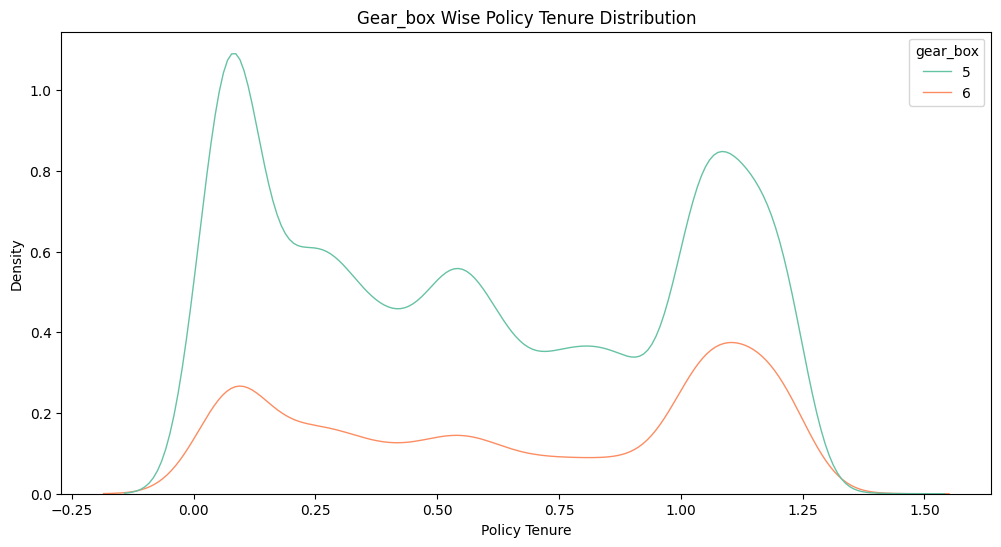

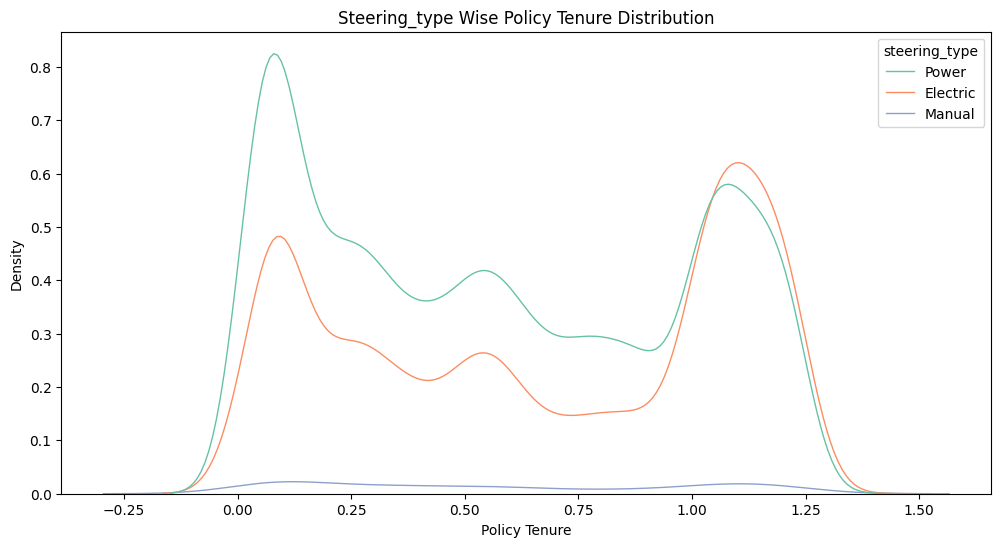

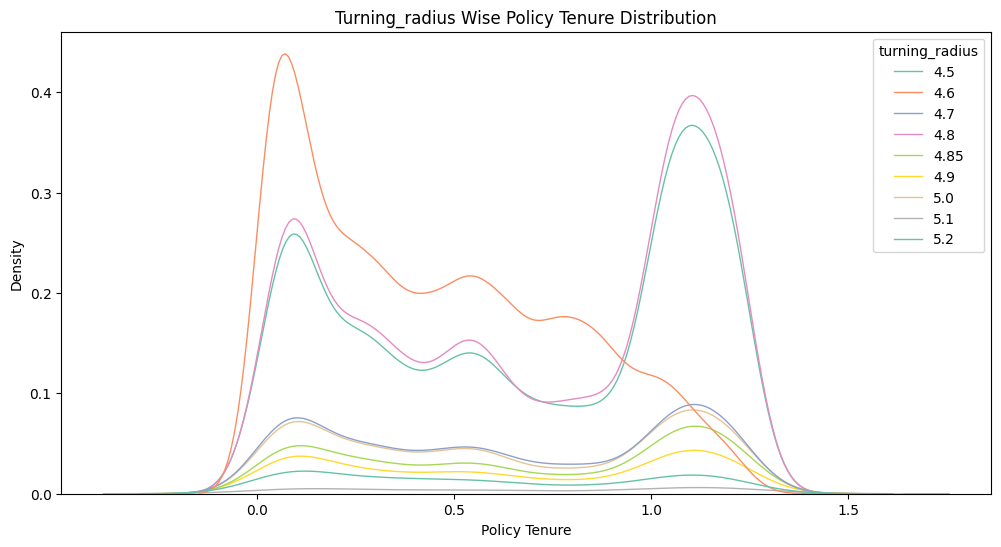

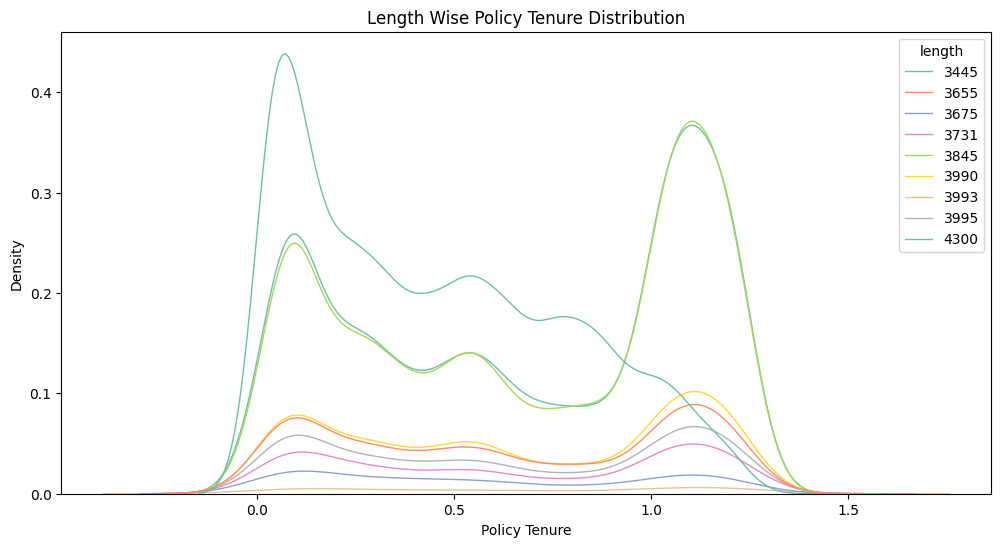

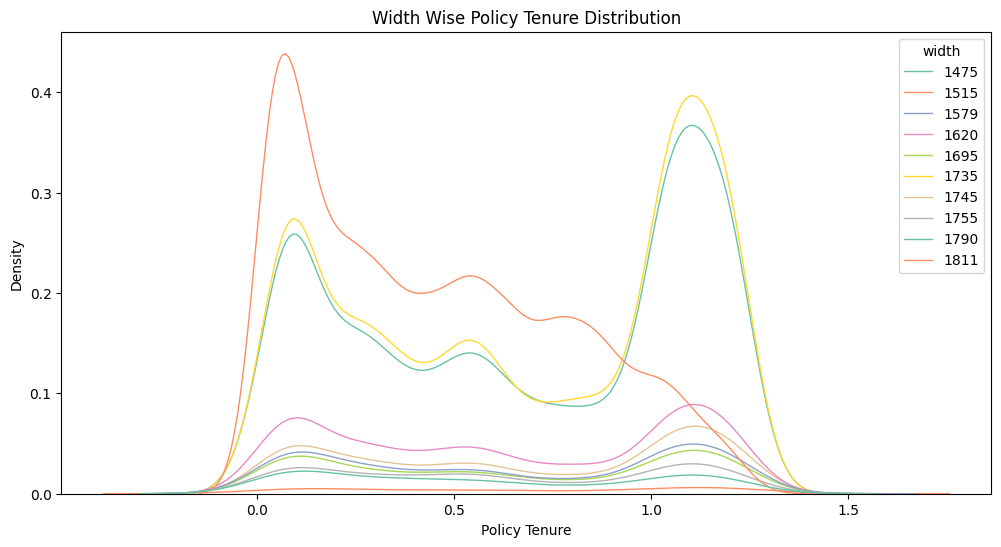

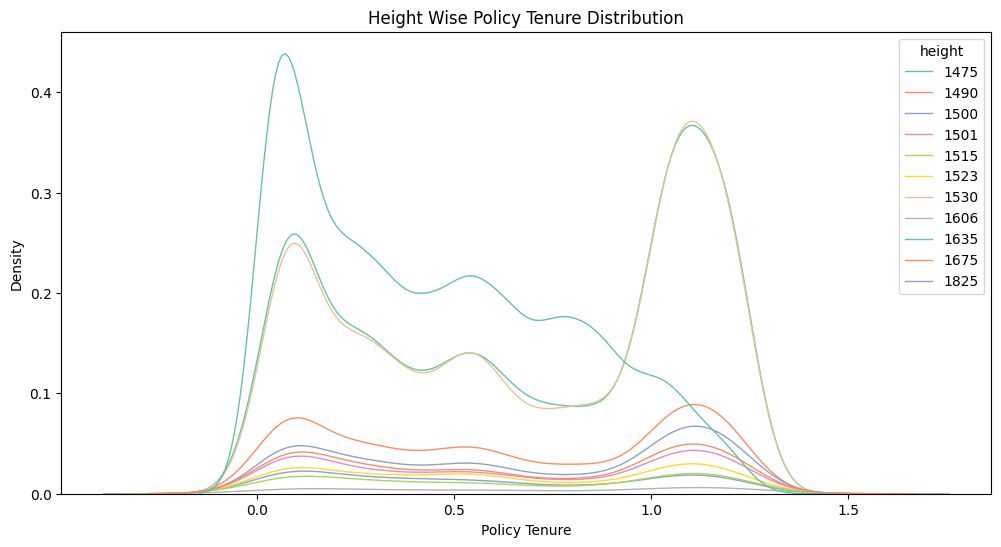

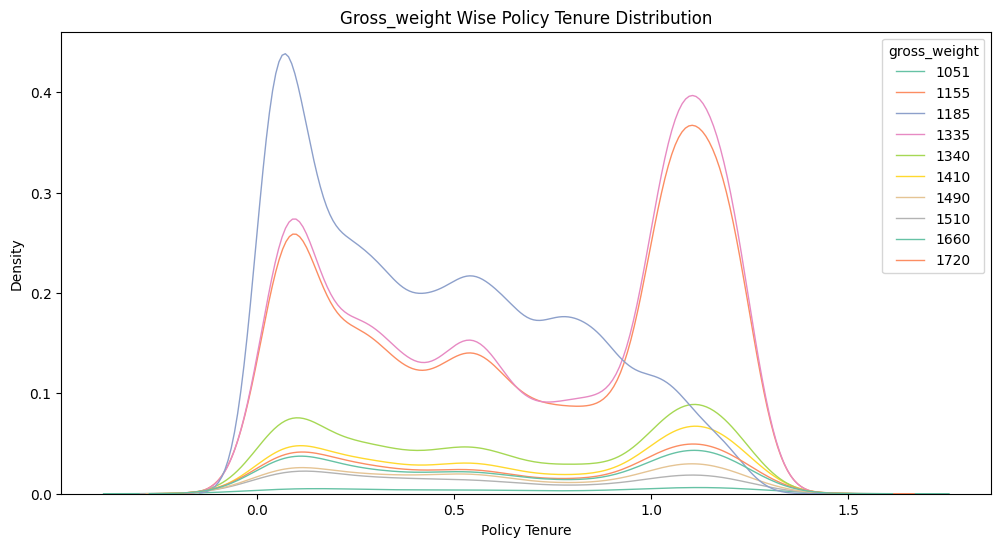

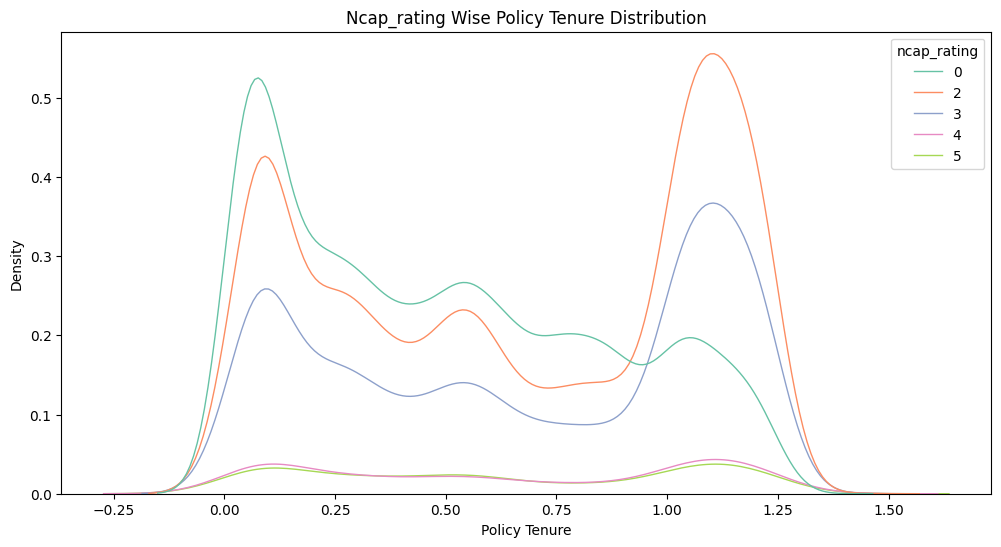

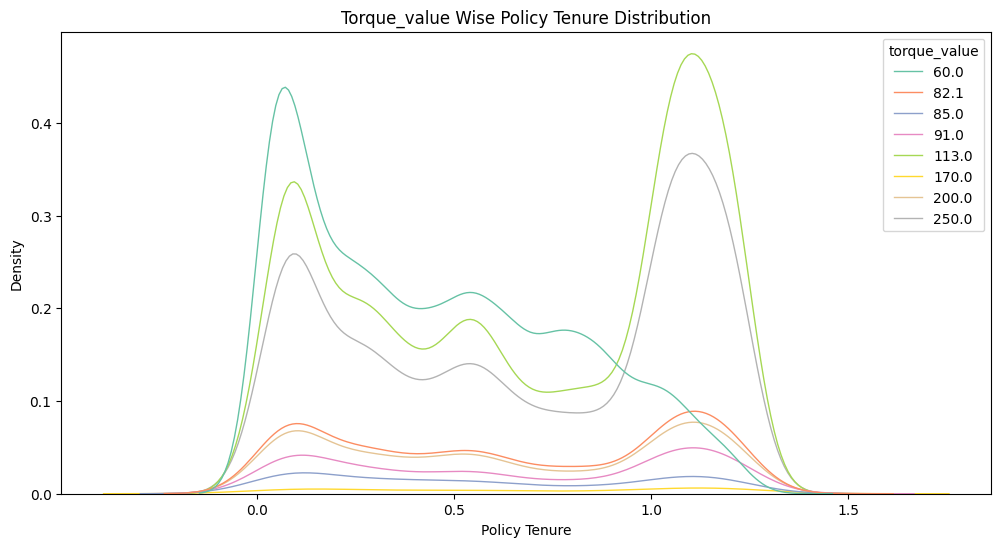

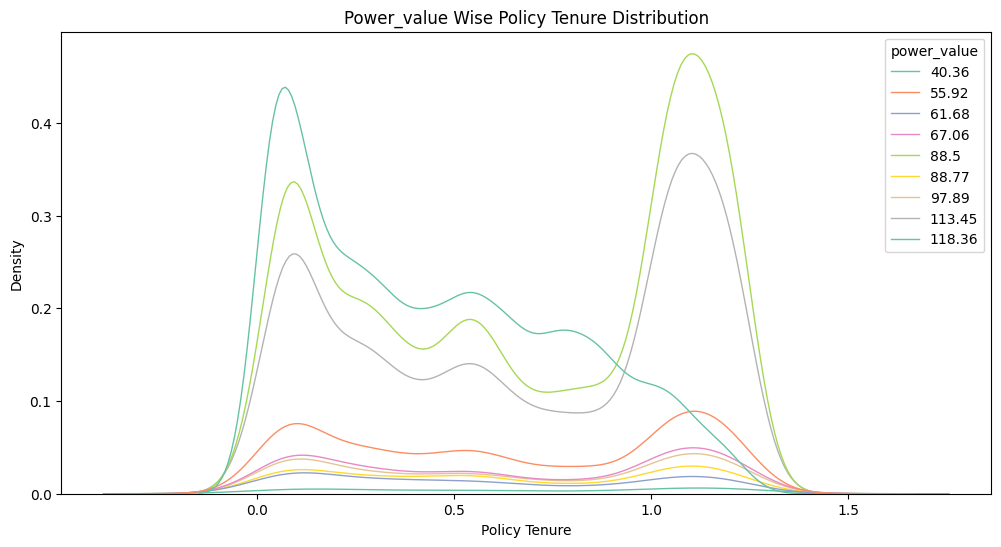

In [24]:
# Loop through each categorical column and plot the kde plot
for column in categorical_col:
    plot_kde(data, 'policy_tenure', column, palette=sns.color_palette('Set2'), plot_size=plot_sizes[0], linewidth=1)

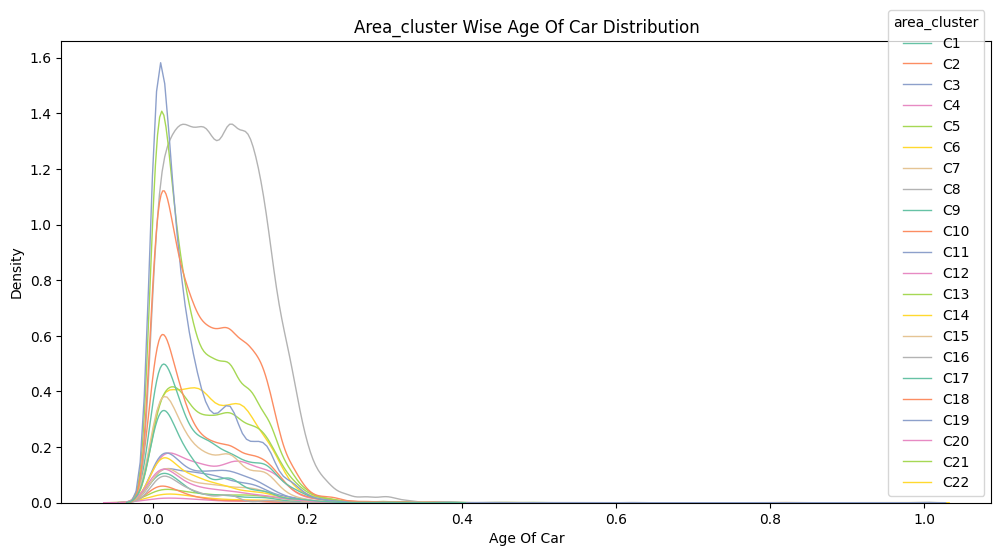

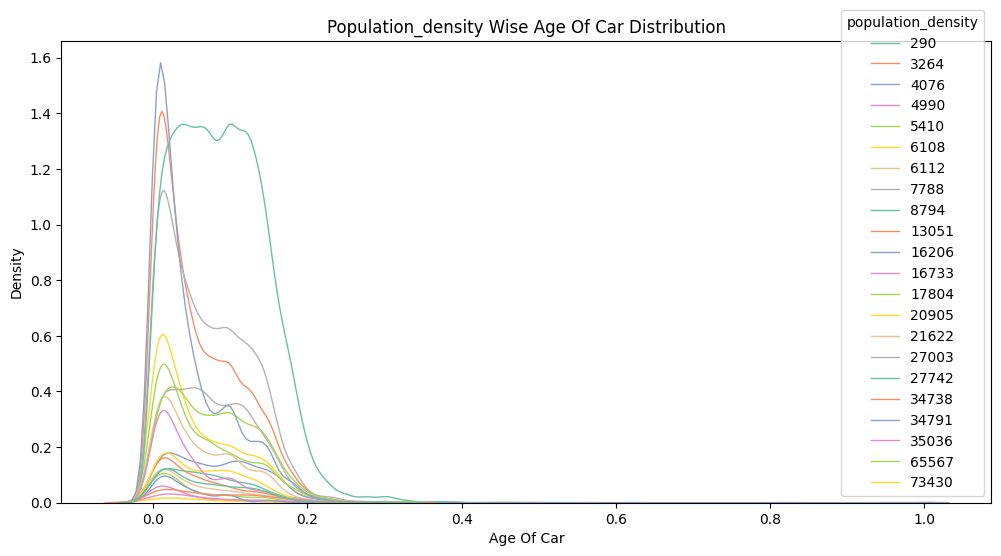

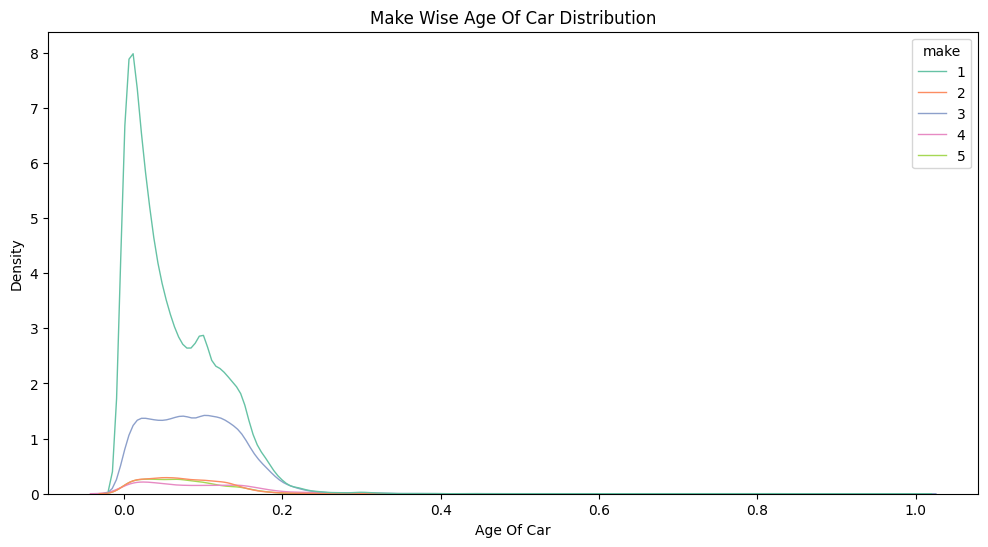

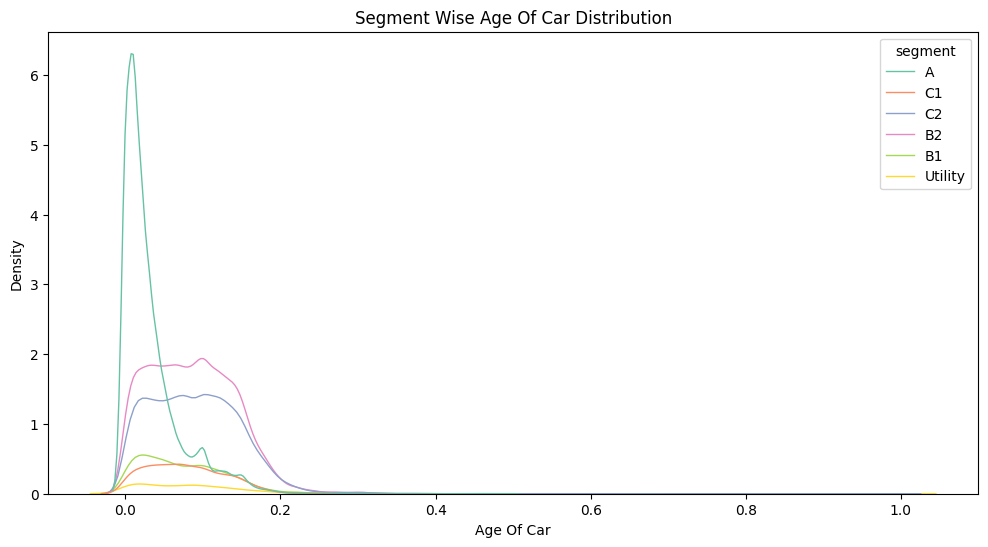

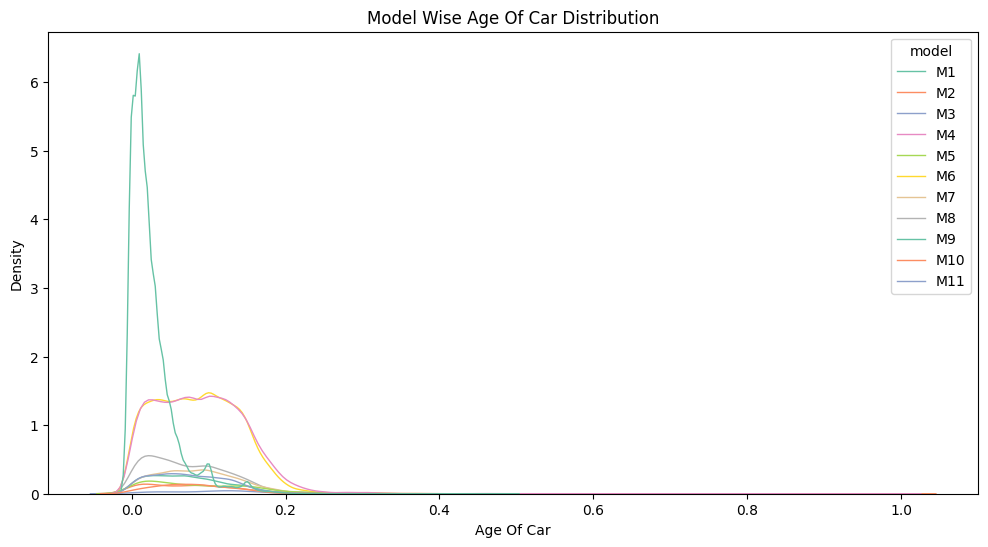

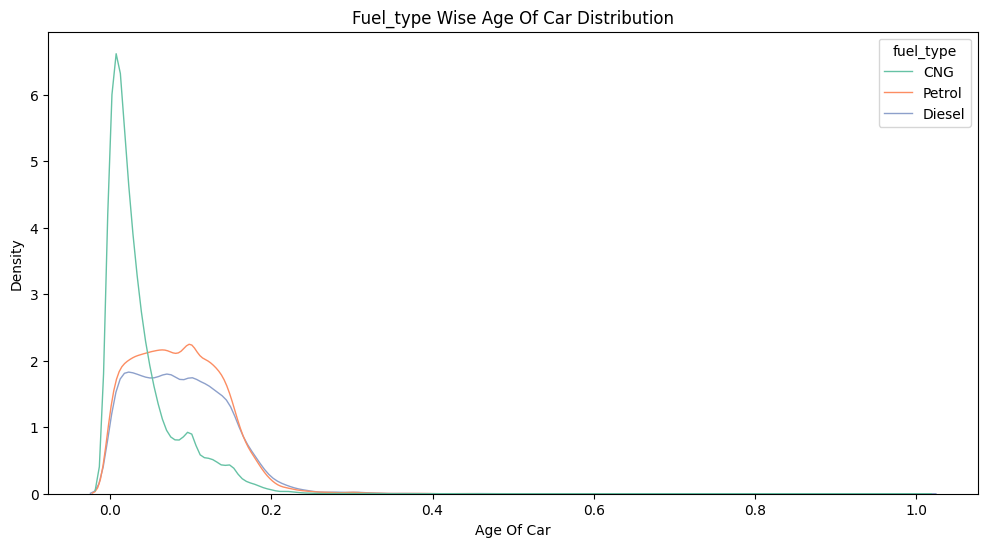

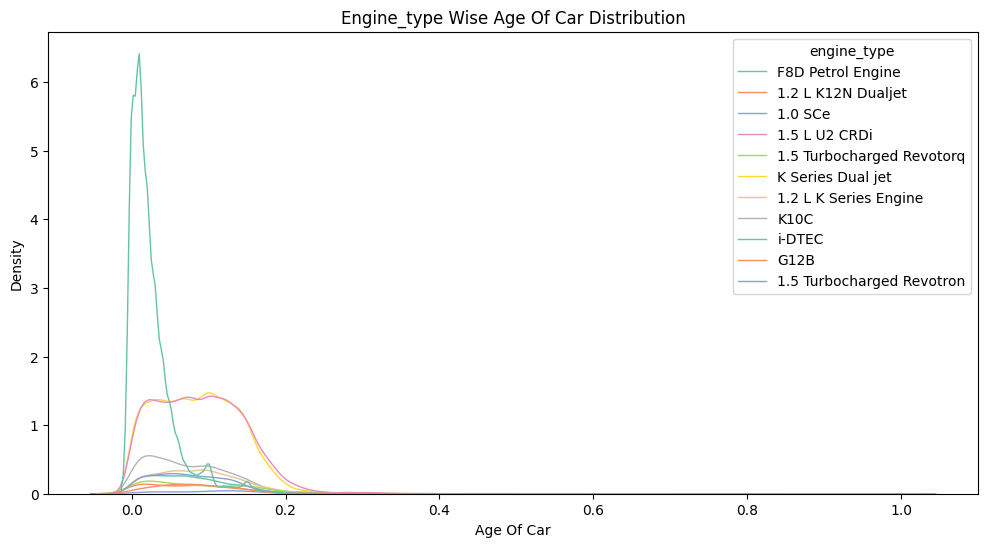

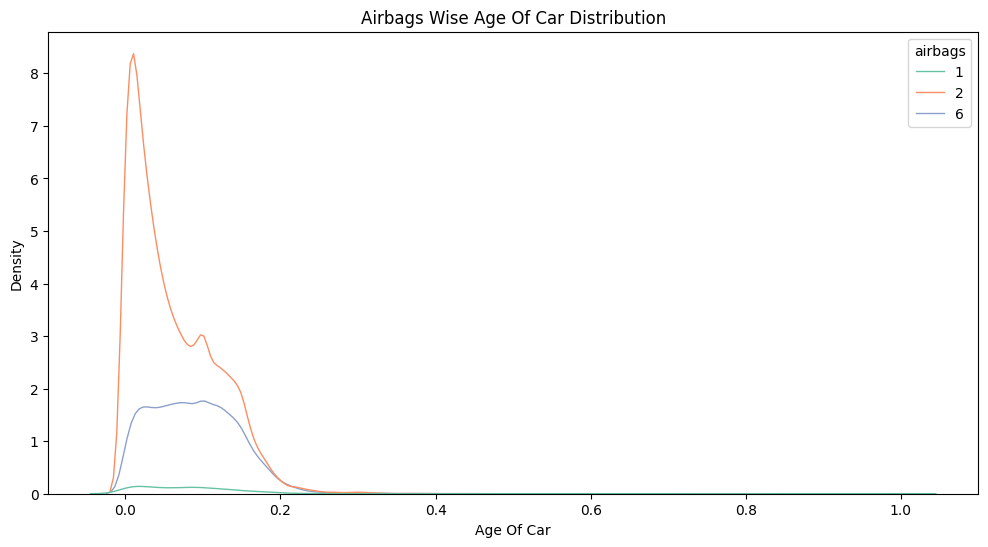

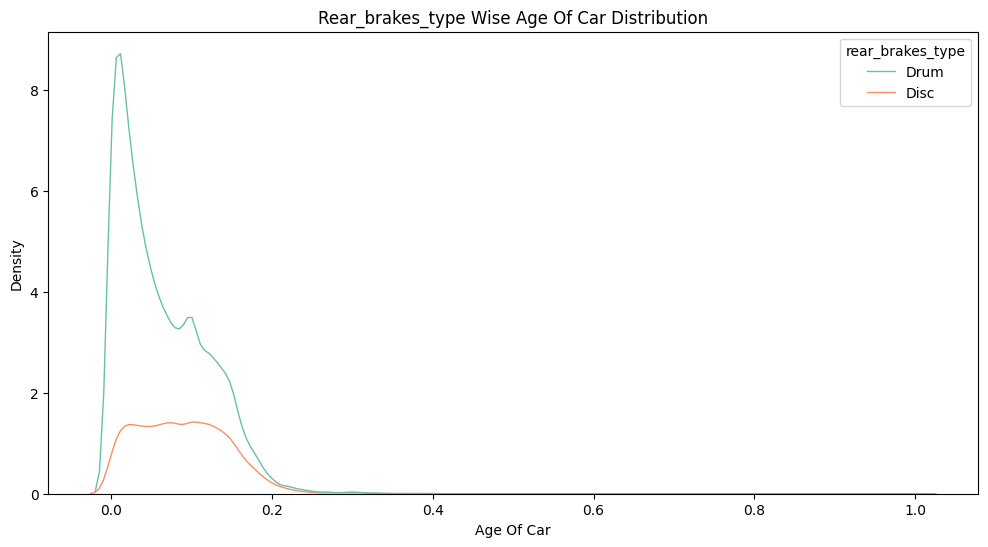

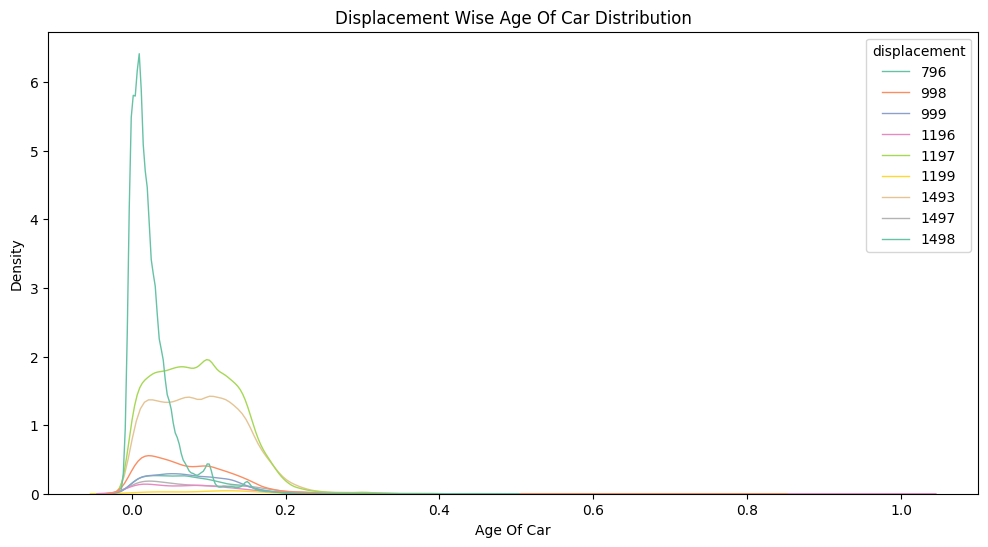

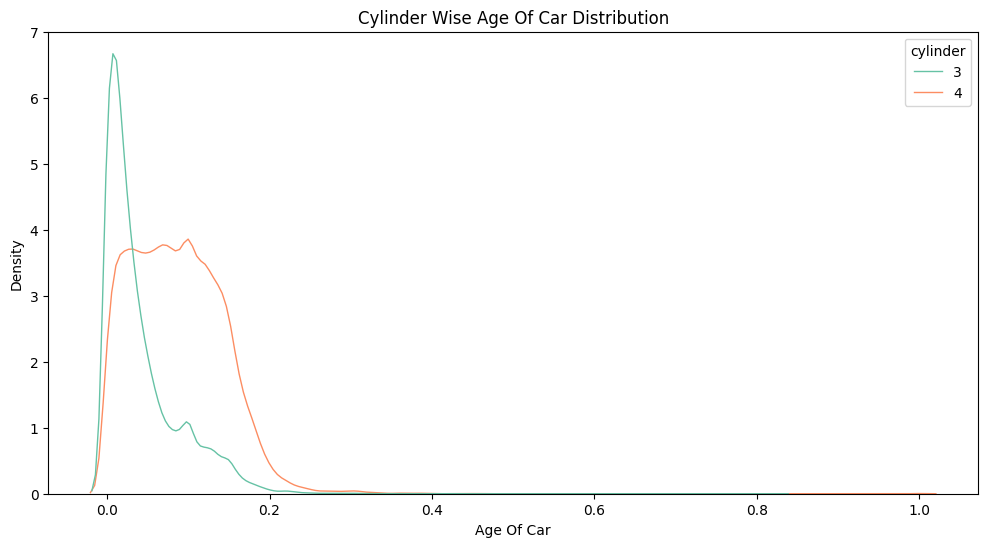

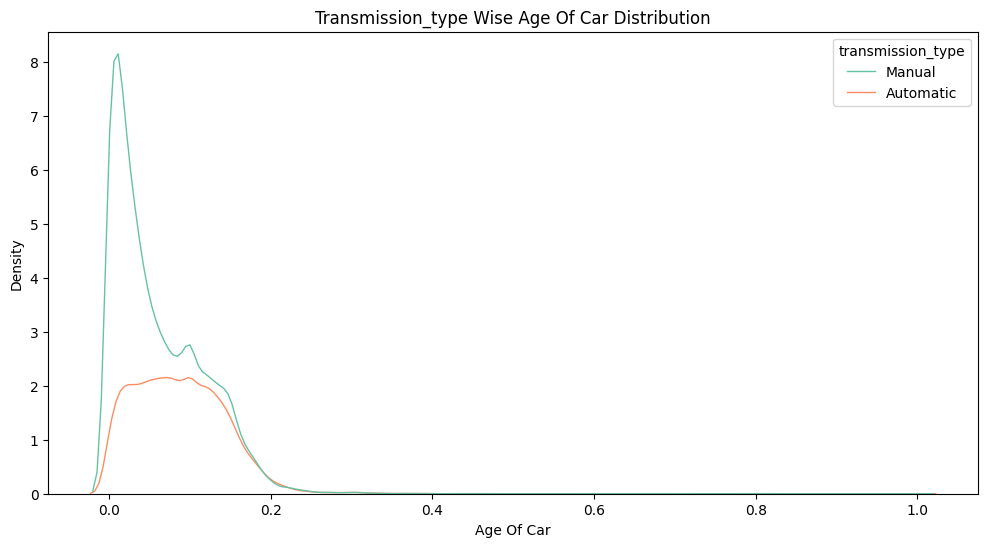

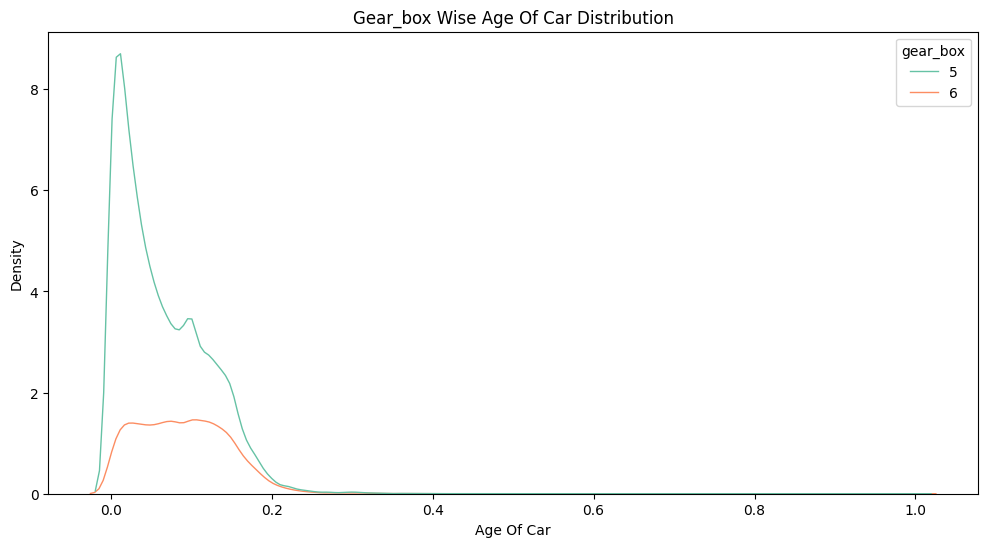

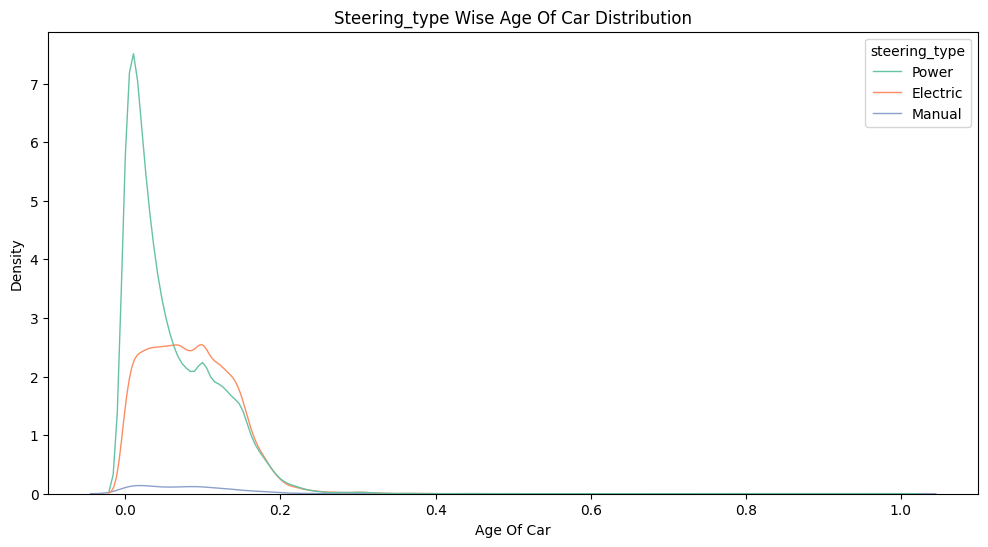

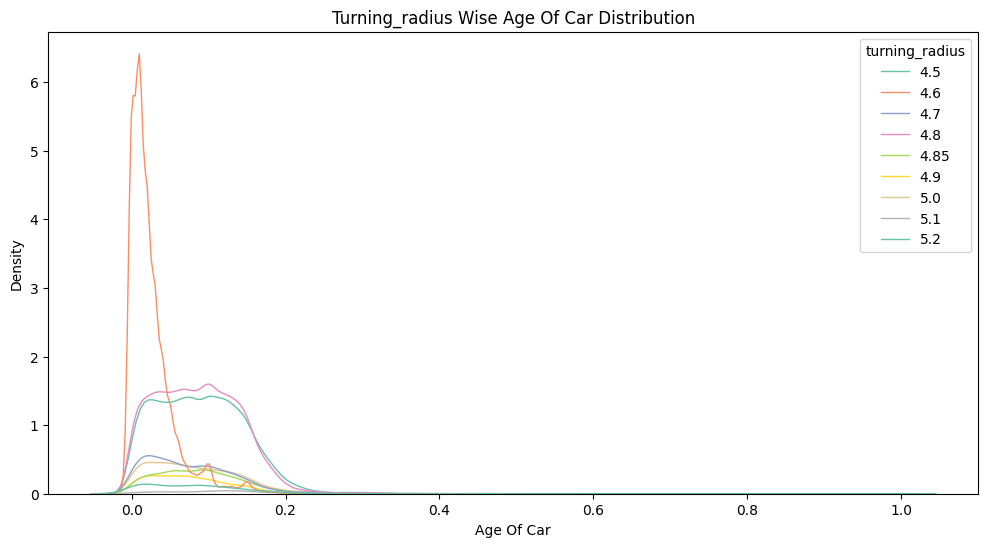

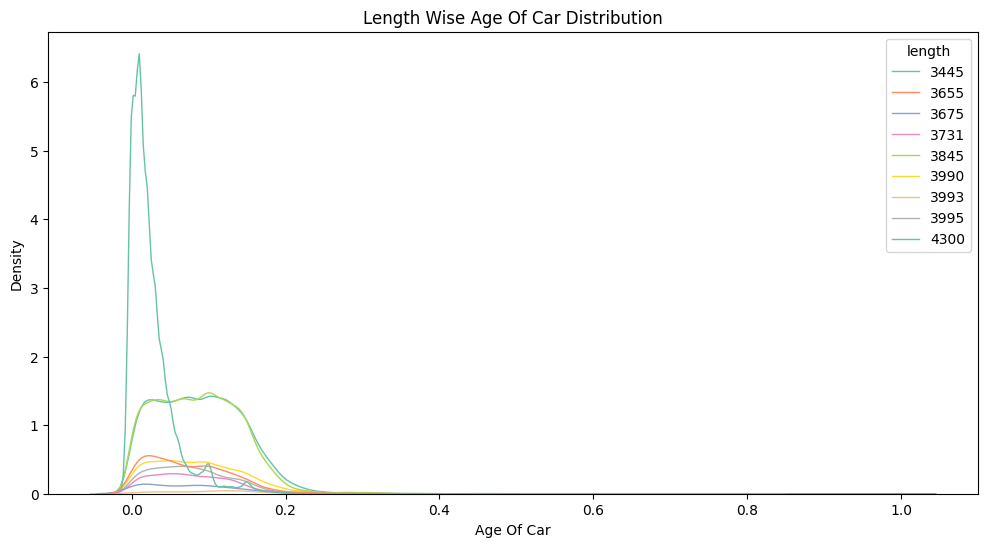

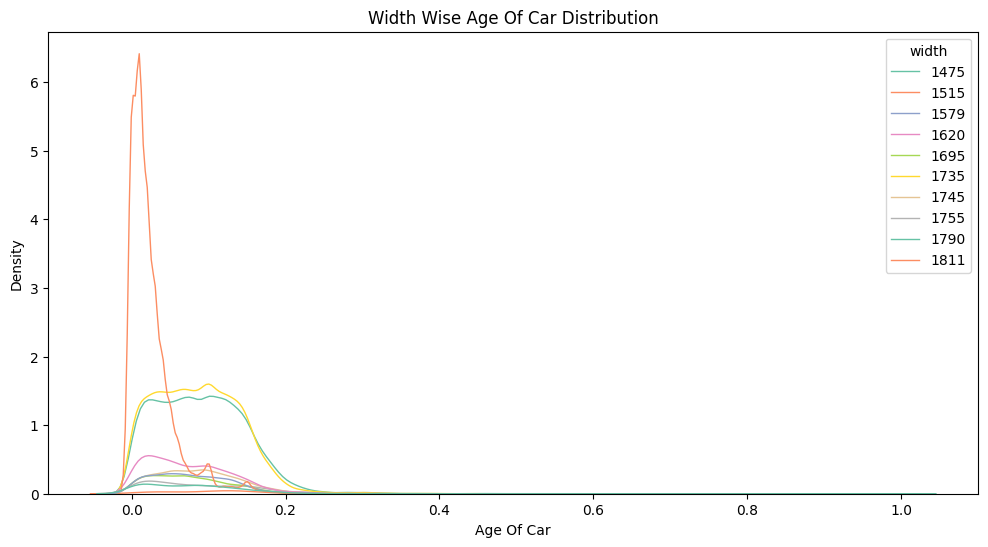

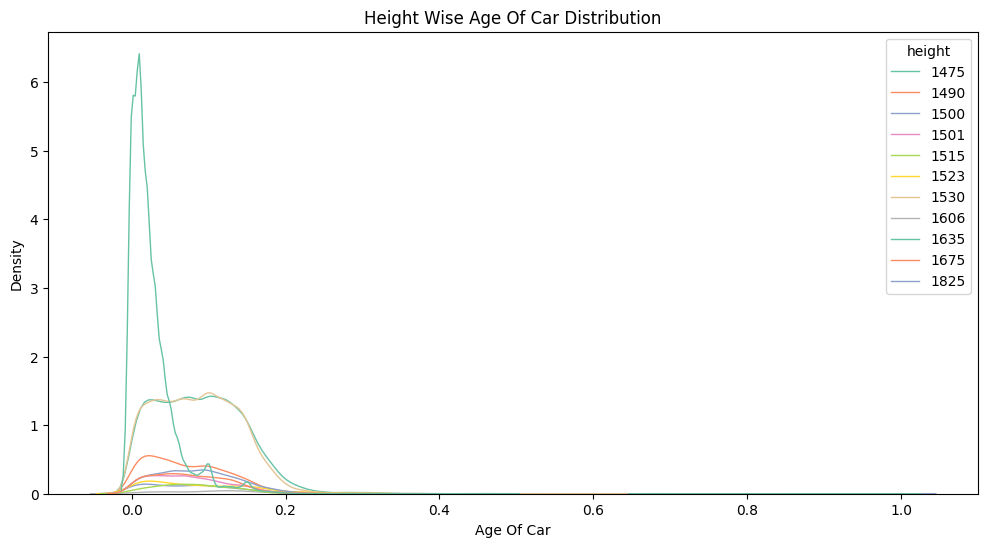

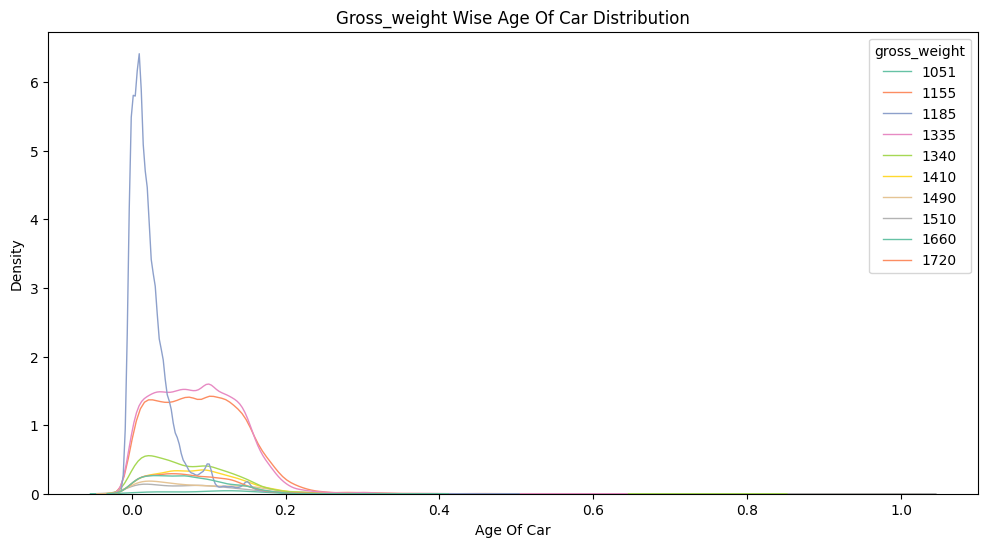

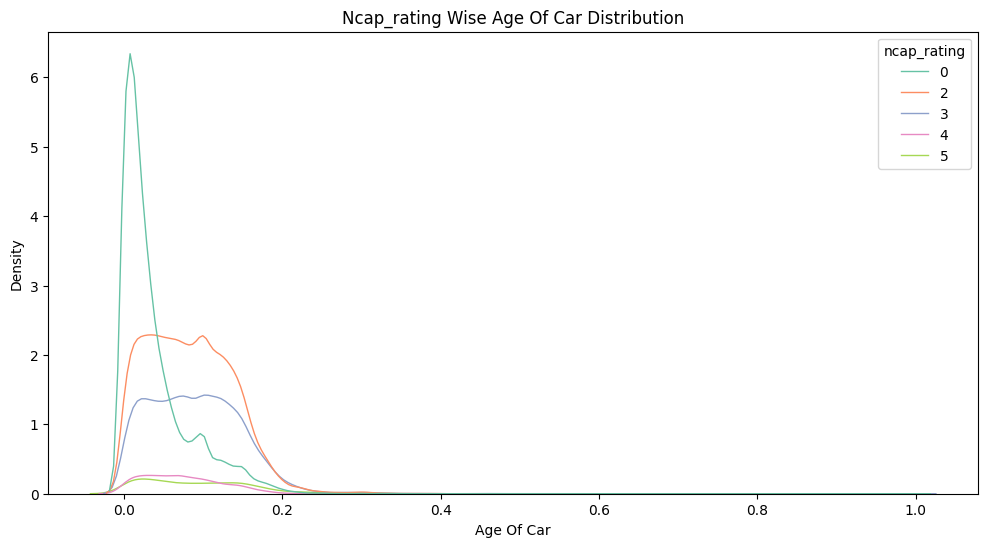

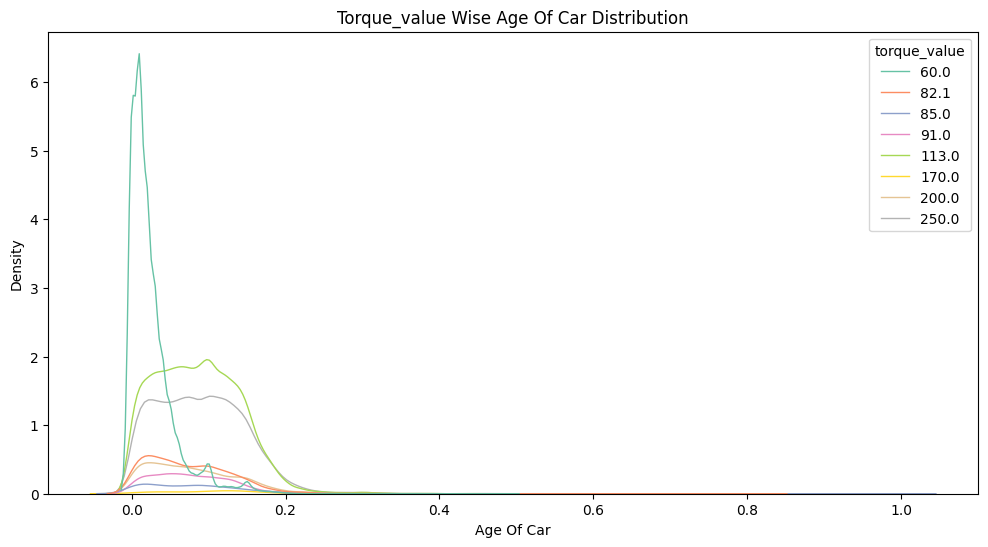

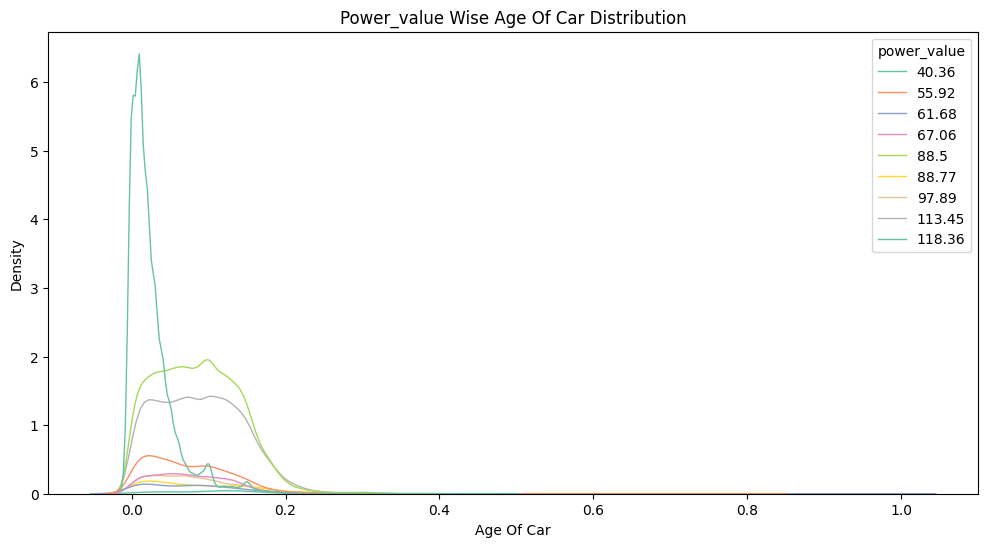

In [25]:
# Loop through each categorical column and plot the kde plot
for column in categorical_col:
    plot_kde(data, 'age_of_car', column, palette=sns.color_palette('Set2'), plot_size=plot_sizes[0], linewidth=1)

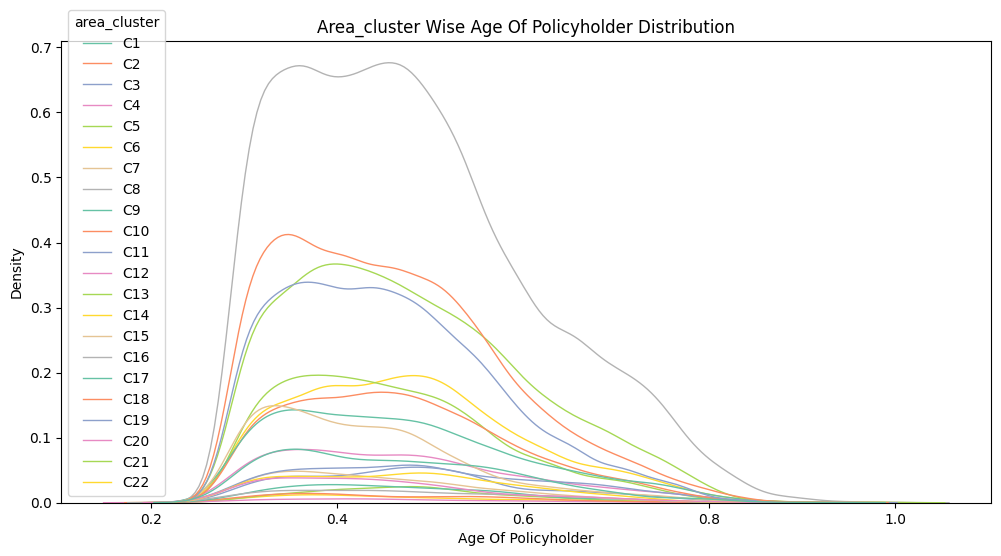

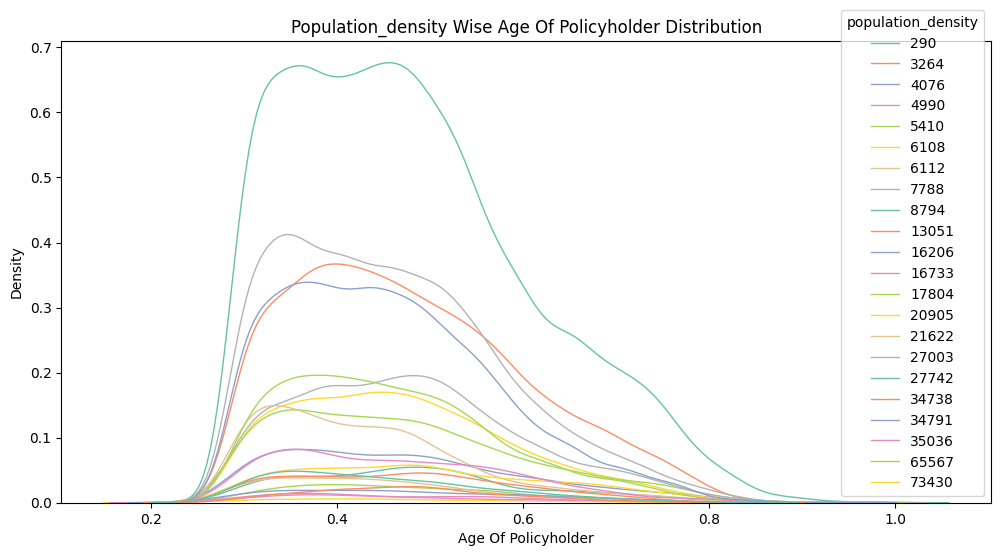

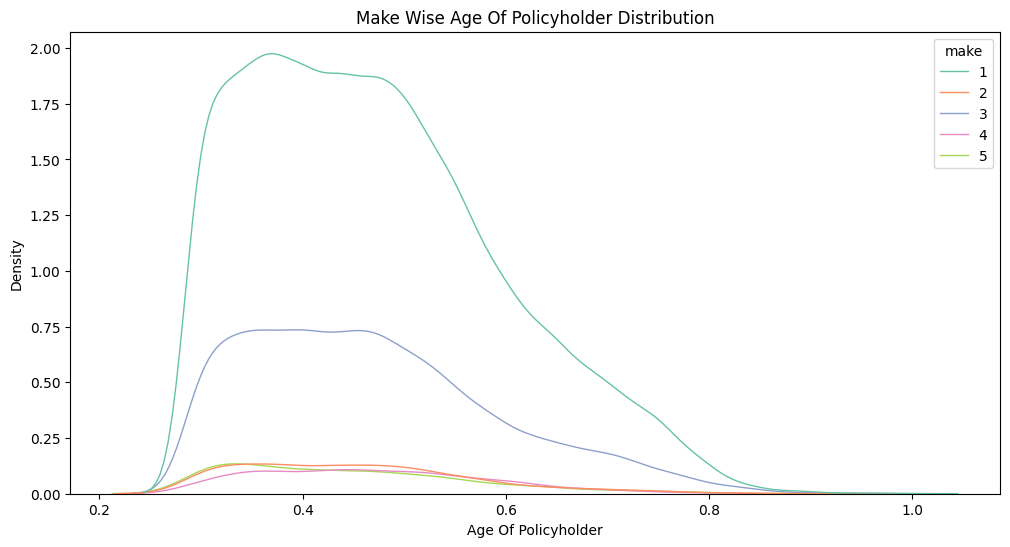

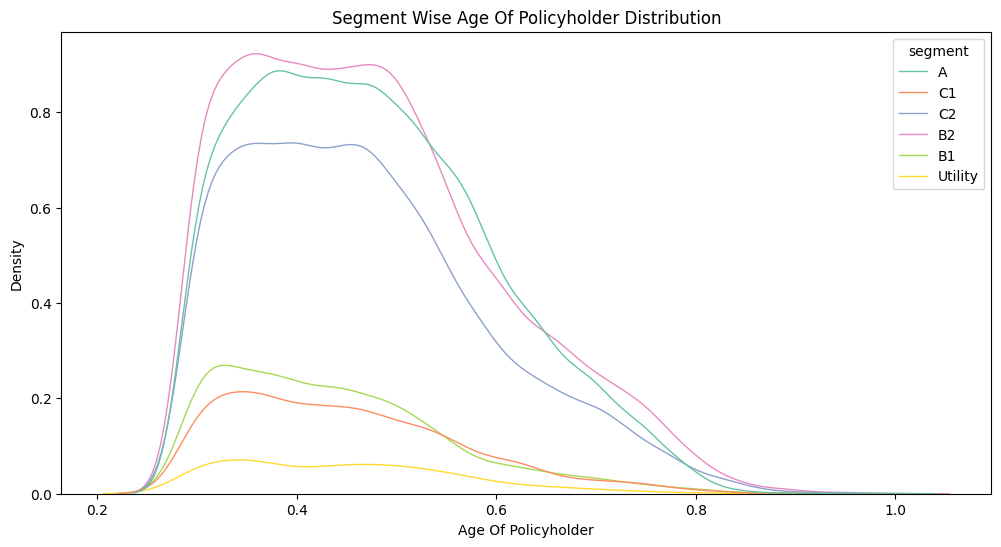

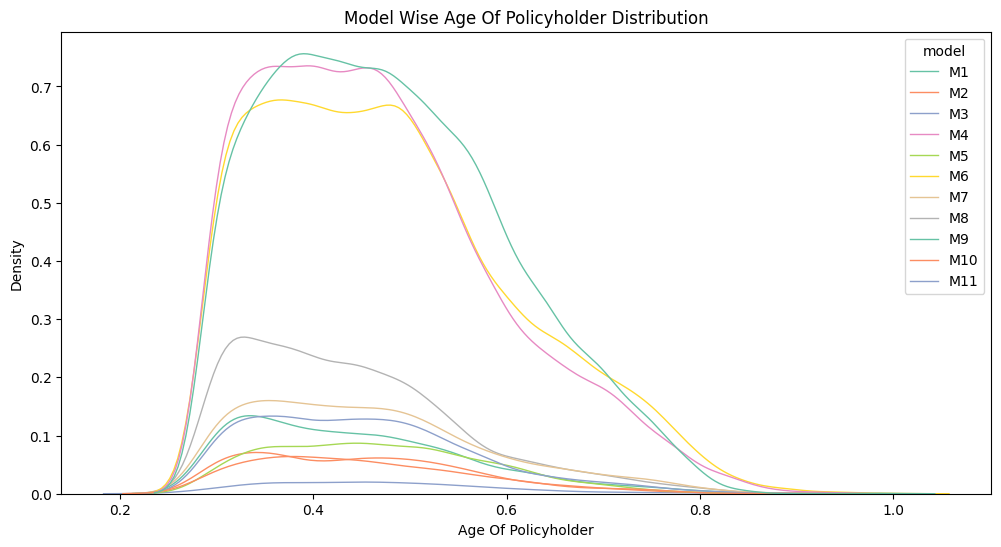

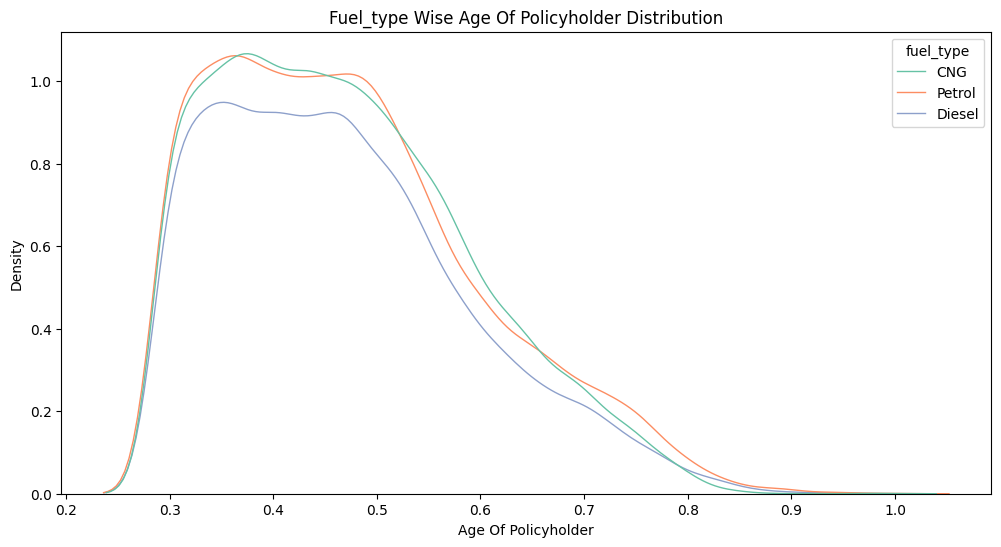

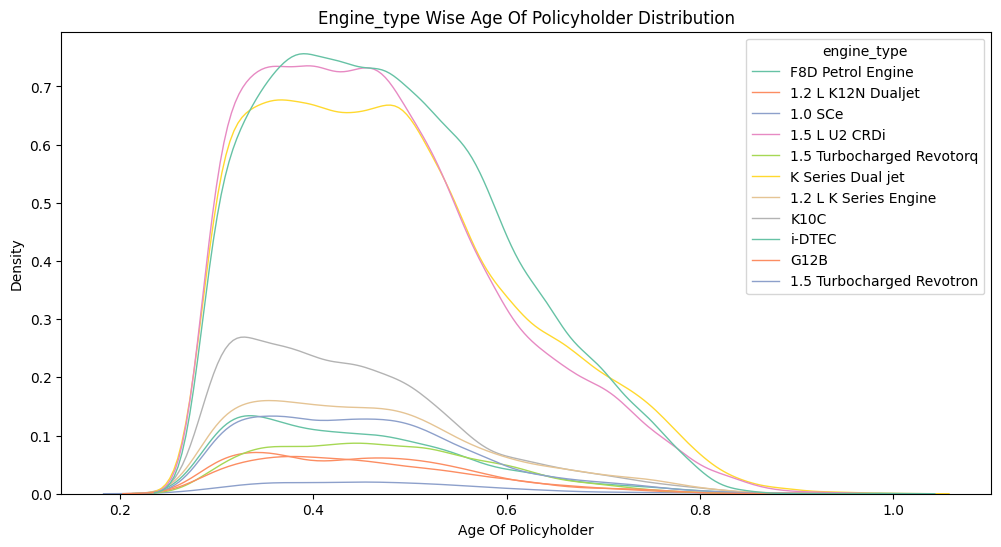

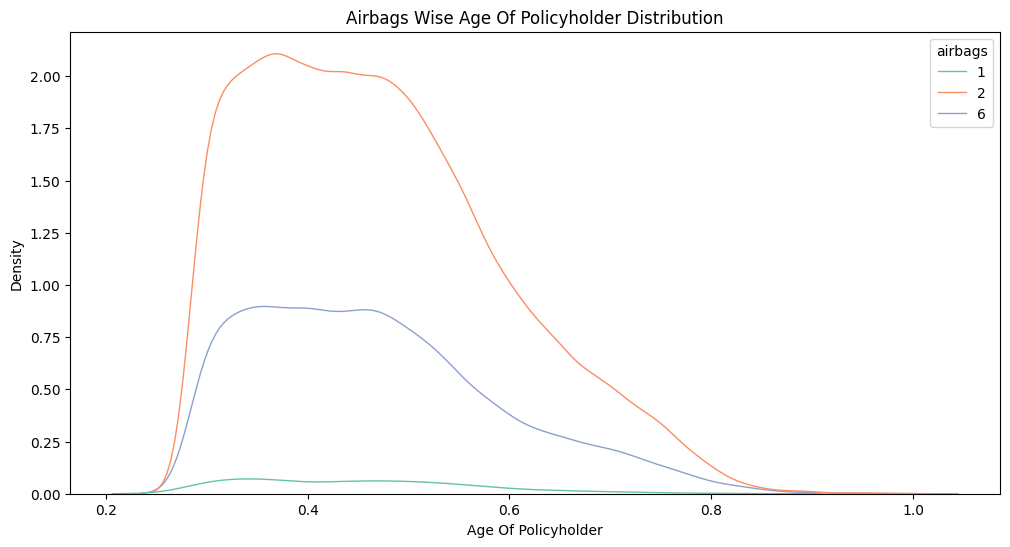

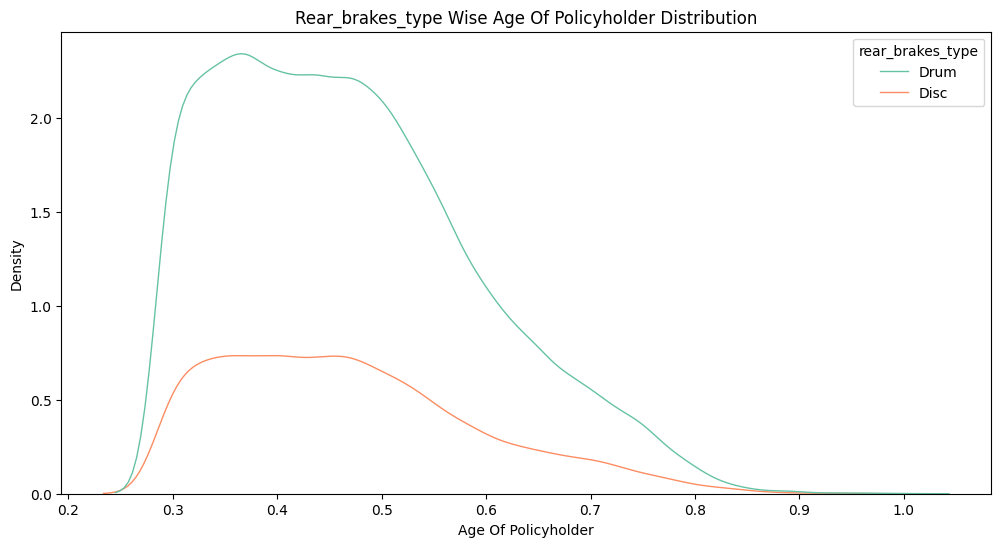

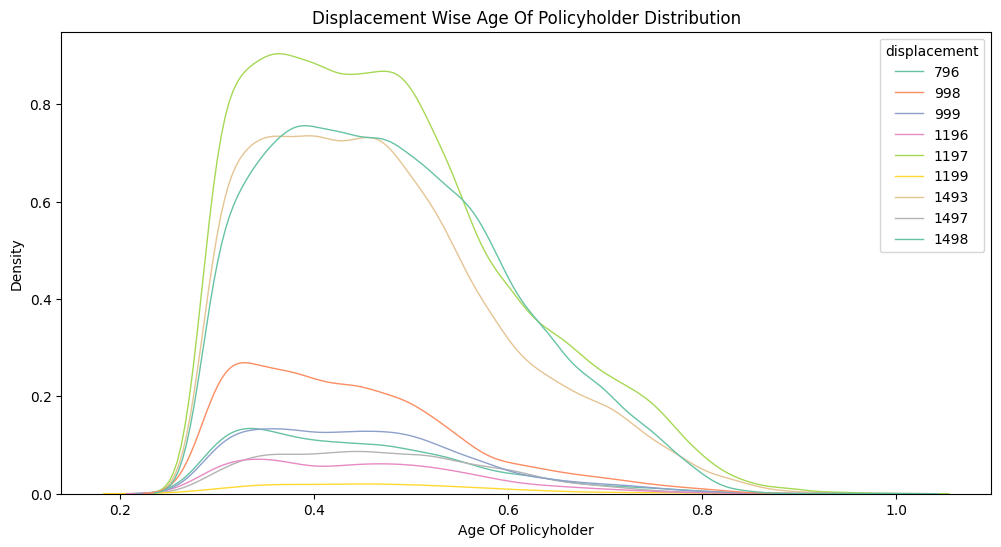

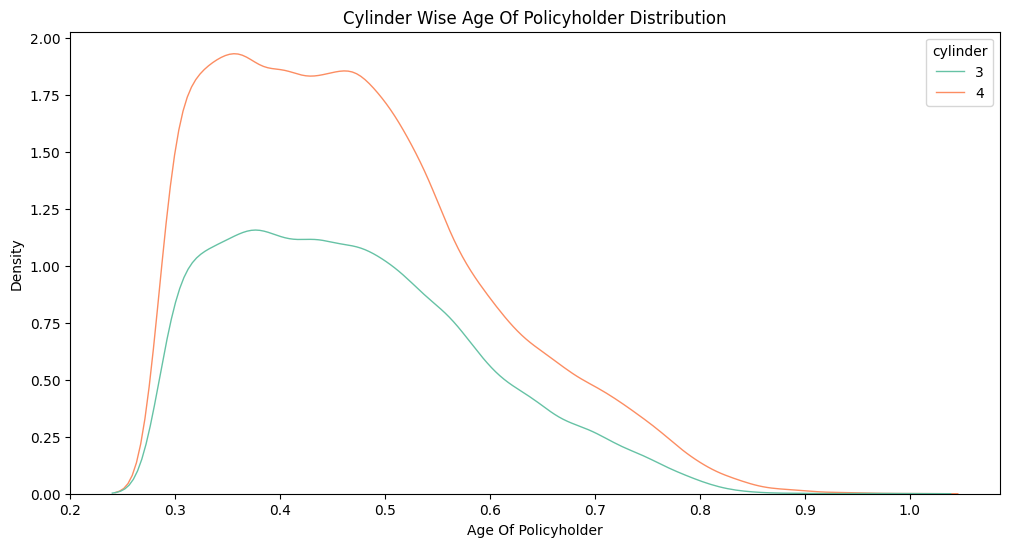

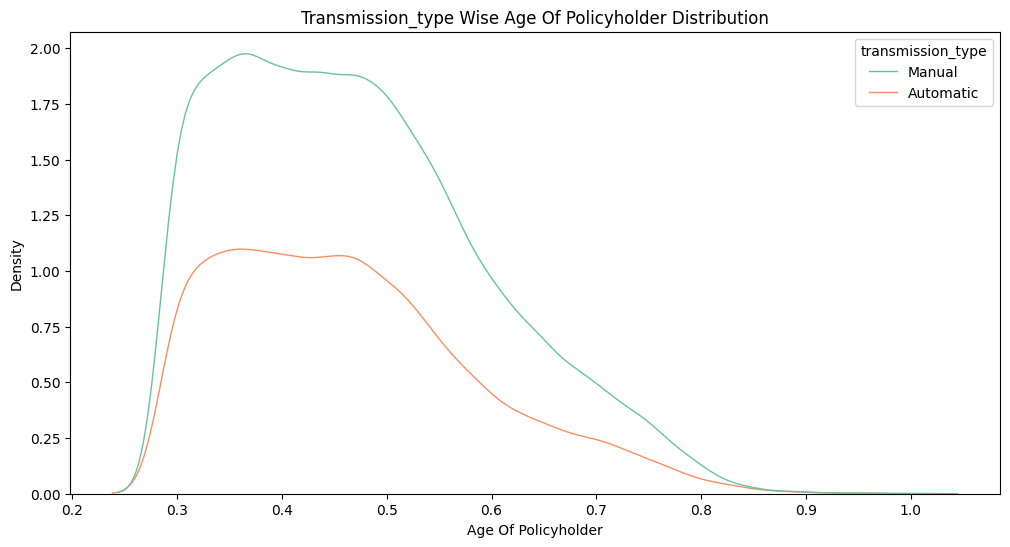

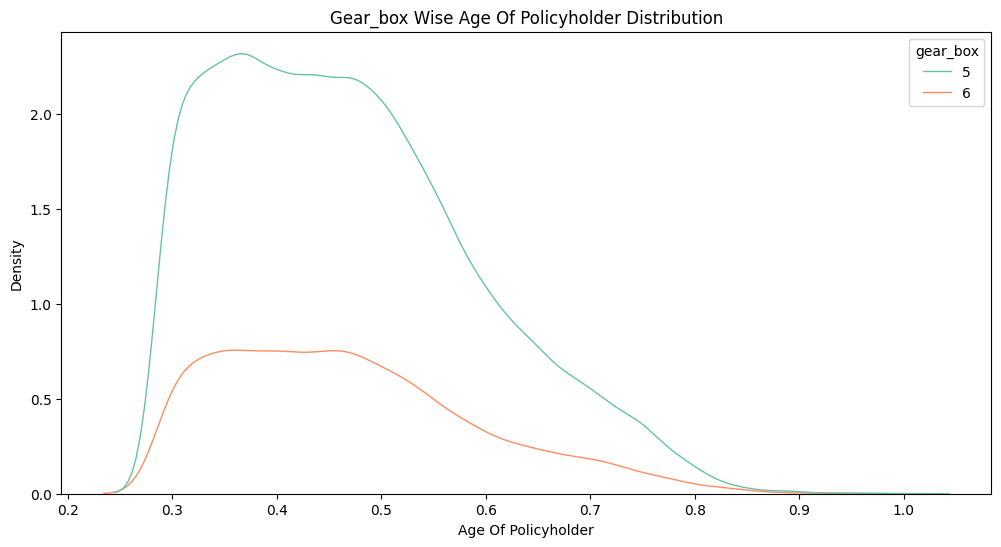

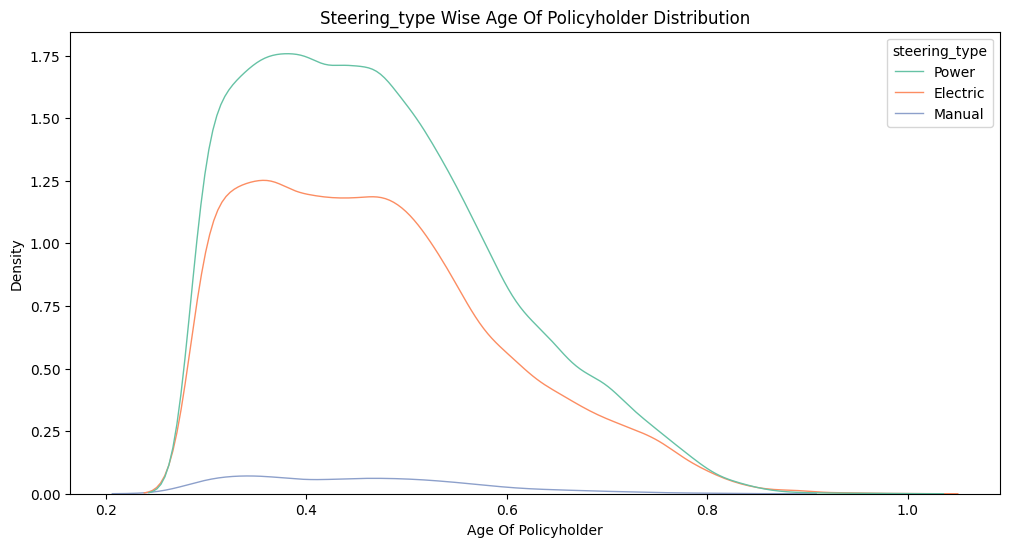

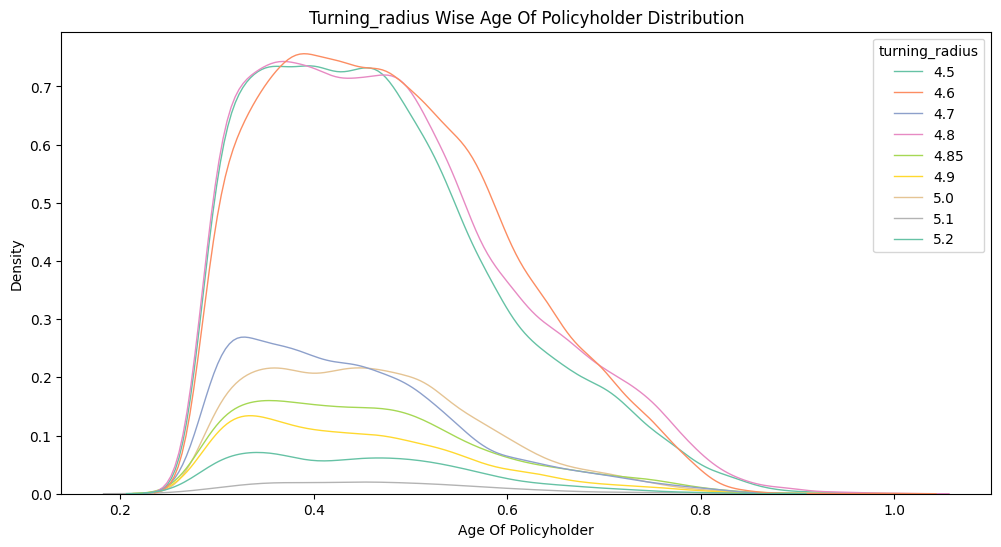

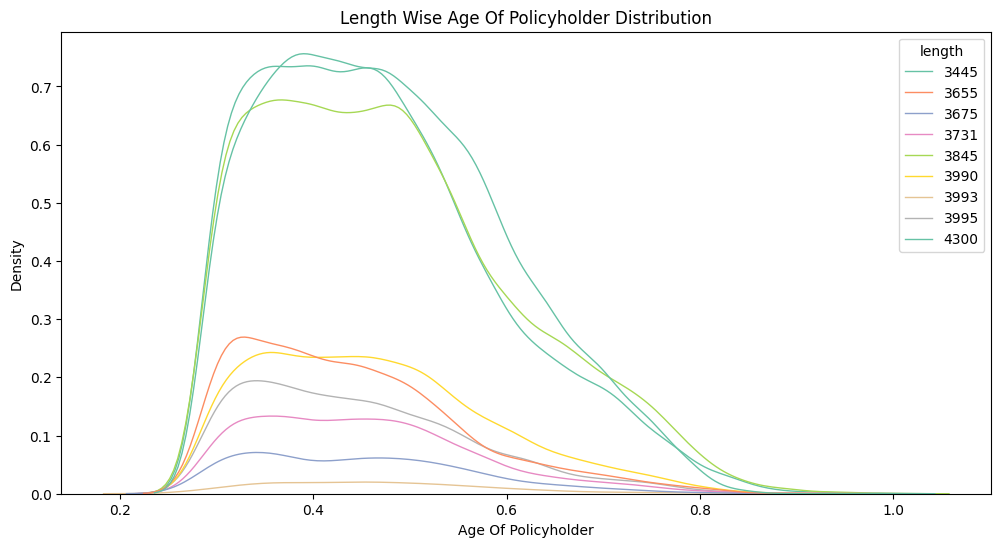

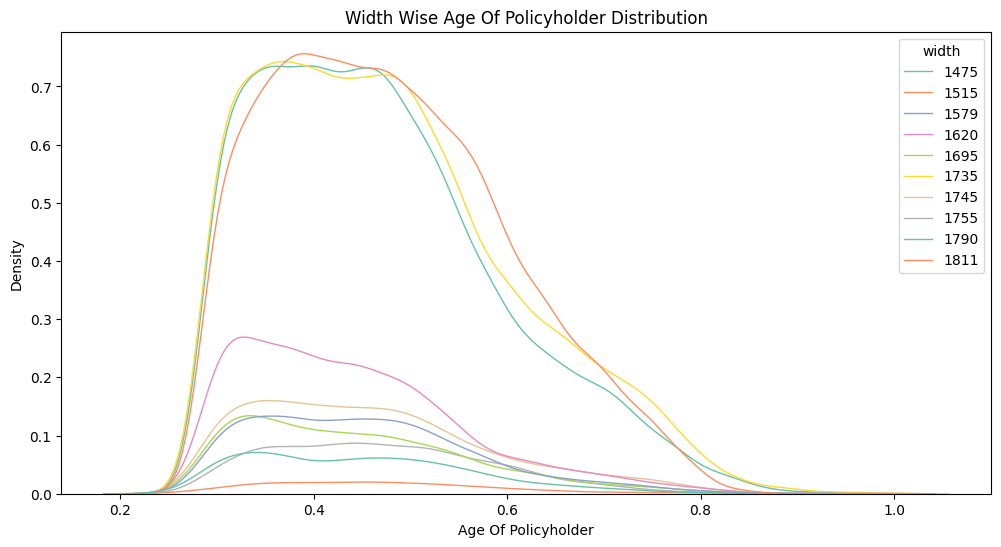

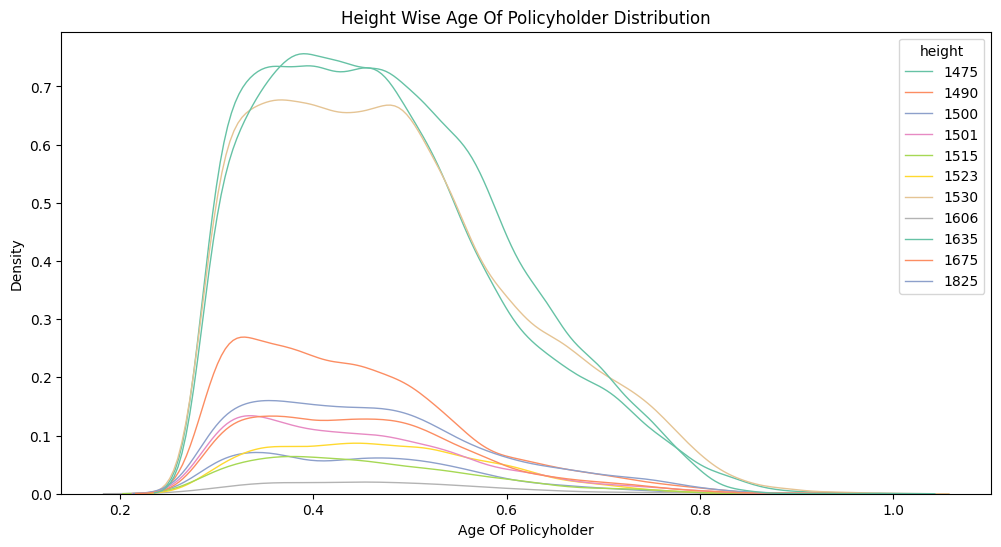

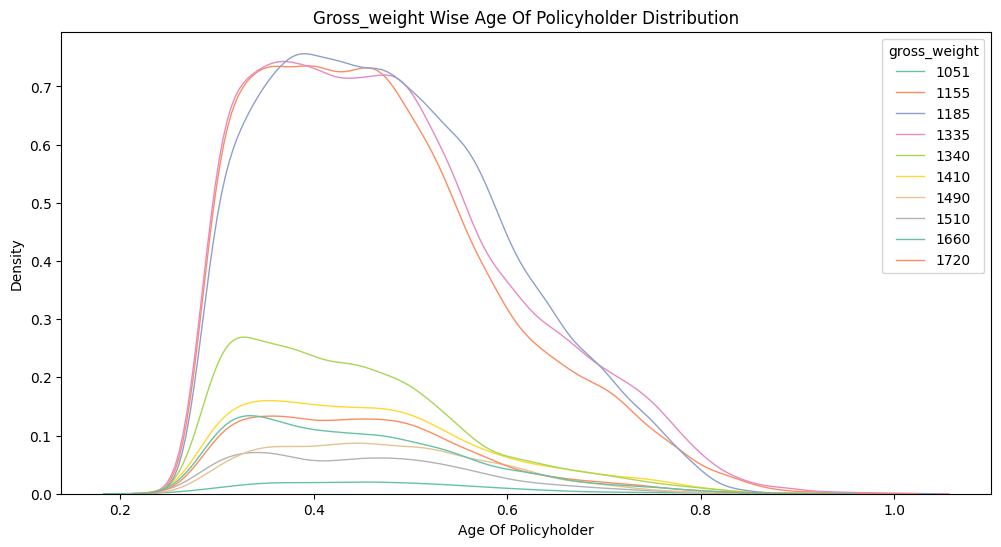

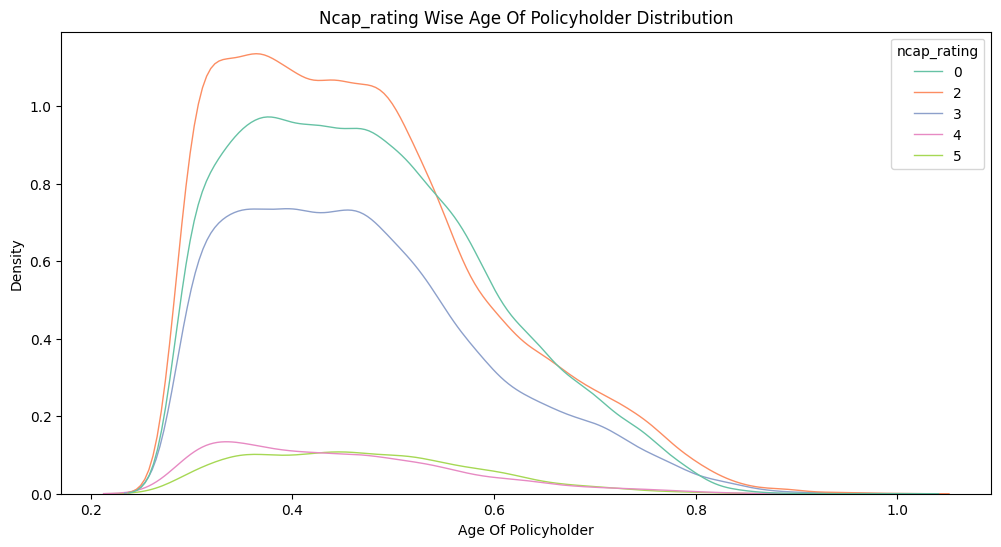

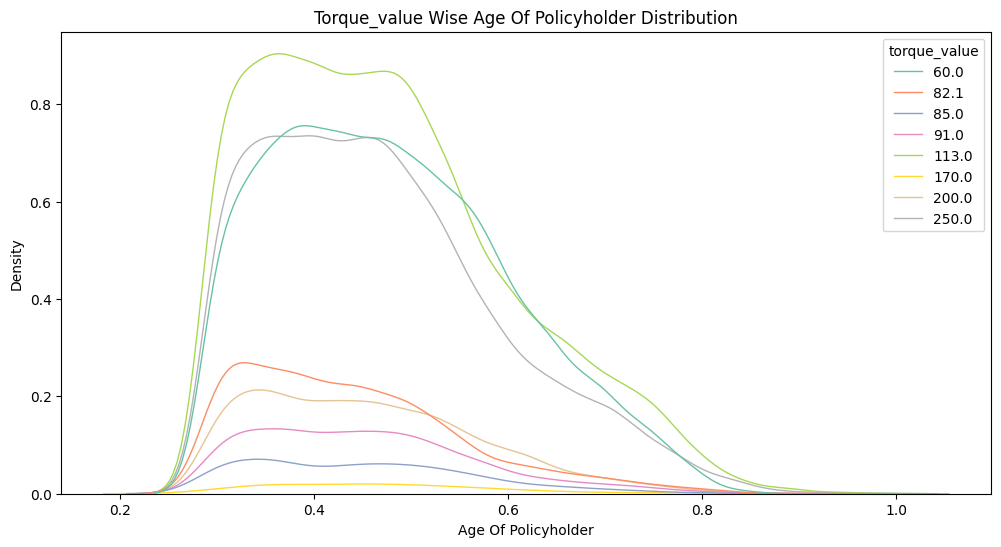

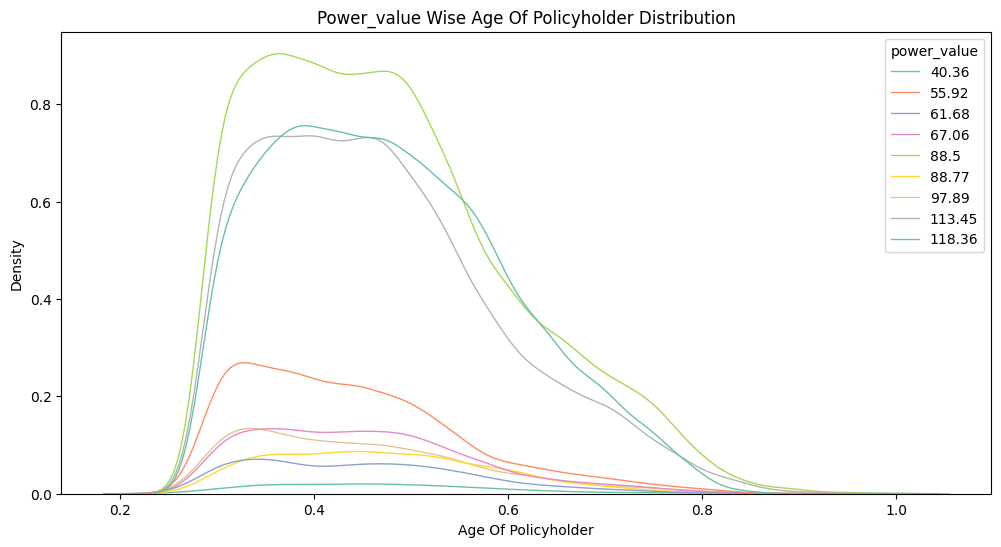

In [26]:
# Loop through each categorical column and plot the kde plot
for column in categorical_col:
    plot_kde(data, 'age_of_policyholder', column, palette=sns.color_palette('Set2'), plot_size=plot_sizes[0], linewidth=1)

In [27]:
# Create a copy of the dataset for preprocessing
data_corr = data.copy()
data2 = data.copy()

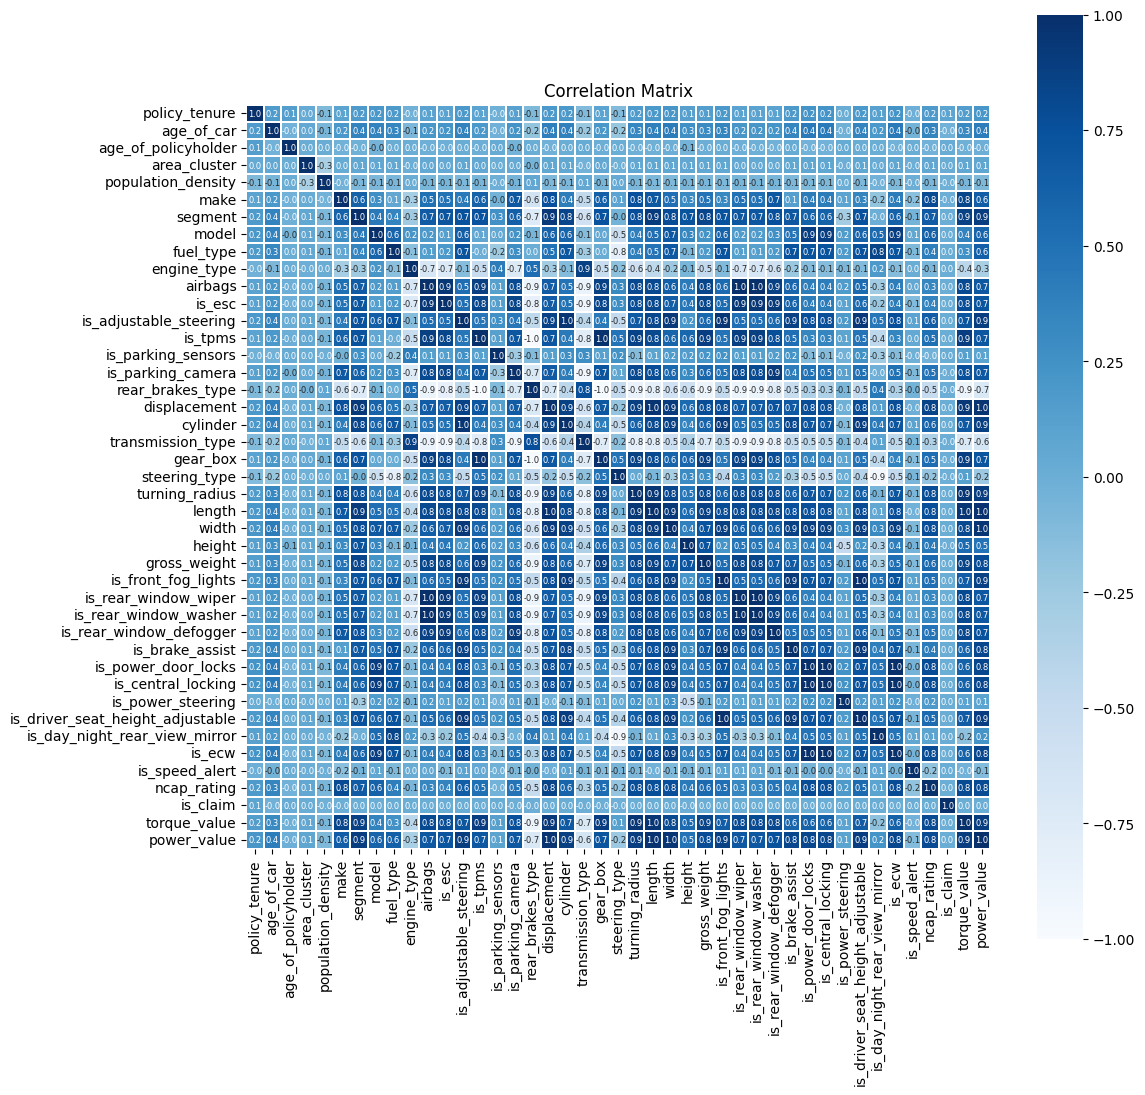

In [28]:
# Label Encoding for categorical variables
for column in data_corr.columns:
    if data_corr[column].dtype == 'object':        
        label_encoder = LabelEncoder()
        data_corr[column] = label_encoder.fit_transform(data_corr[column])

# Calculate the correlation matrix
correlation_matrix = data_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=plot_sizes[1])
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='Blues', square=True, linewidths=.1, annot_kws={"size": 6})
plt.title('Correlation Matrix')
plt.show()

In [29]:
correlated_col = """displacement length airbags is_esc is_rear_window_wiper
is_rear_window_washer is_rear_window_defogger is_adjustable_steering cylinder
width is_front_fog_lights is_driver_seat_height_adjustable rear_brakes_type
gear_box is_parking_camera transmission_type torque_value power_value
is_day_night_rear_view_mirror turning_radius is_brake_assist is_power_door_locks
is_central_locking""".split()

In [30]:
# Drop the correlated columns in place
data2.drop(columns=correlated_col, inplace=True)
print(data2.columns)
print(data2.shape)

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster',
       'population_density', 'make', 'segment', 'model', 'fuel_type',
       'engine_type', 'is_tpms', 'is_parking_sensors', 'steering_type',
       'height', 'gross_weight', 'is_power_steering', 'is_ecw',
       'is_speed_alert', 'ncap_rating', 'is_claim'],
      dtype='object')
(58592, 20)


In [31]:
car_spec_features = """
make segment model fuel_type engine_type airbags is_esc is_adjustable_steering
is_tpms is_parking_sensors is_parking_camera rear_brakes_type displacement
cylinder transmission_type gear_box steering_type turning_radius length
width height gross_weight is_front_fog_lights is_rear_window_wiper
is_rear_window_washer is_rear_window_defogger is_brake_assist is_power_door_locks
is_central_locking is_power_steering is_driver_seat_height_adjustable
is_day_night_rear_view_mirror is_ecw is_speed_alert ncap_rating torque_value power_value
""".split()

In [32]:
# Filter the data to include only models M1 to M11
models_to_check = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11']
filtered_data = data[data['model'].isin(models_to_check)]

# Skip specified columns and recheck consistency
columns_to_skip = ["is_claim", "policy_tenure", "age_of_car", "age_of_policyholder", "area_cluster", "population_density"]
filtered_data = filtered_data.drop(columns=columns_to_skip)

# Check for consistency across features again
consistency_check_filtered = filtered_data.groupby('model').agg(lambda x: x.nunique()).T
inconsistencies_filtered = consistency_check_filtered[consistency_check_filtered.nunique(axis=1) > 1]
print(inconsistencies_filtered)
consistency_check_filtered

Empty DataFrame
Columns: [M1, M10, M11, M2, M3, M4, M5, M6, M7, M8, M9]
Index: []


model                             M1  M10  M11  M2  M3  M4  M5  M6  M7  M8  M9
make                               1    1    1   1   1   1   1   1   1   1   1
segment                            1    1    1   1   1   1   1   1   1   1   1
fuel_type                          1    1    1   1   1   1   1   1   1   1   1
engine_type                        1    1    1   1   1   1   1   1   1   1   1
airbags                            1    1    1   1   1   1   1   1   1   1   1
is_esc                             1    1    1   1   1   1   1   1   1   1   1
is_adjustable_steering             1    1    1   1   1   1   1   1   1   1   1
is_tpms                            1    1    1   1   1   1   1   1   1   1   1
is_parking_sensors                 1    1    1   1   1   1   1   1   1   1   1
is_parking_camera                  1    1    1   1   1   1   1   1   1   1   1
rear_brakes_type                   1    1    1   1   1   1   1   1   1   1   1
displacement                       1    1    1   1   1   1   1   1   1   1   1
cylinder                           1    1    1   1   1   1   1   1   1   1   1
transmission_type                  1    1    1   1   1   1   1   1   1   1   1
gear_box                           1    1    1   1   1   1   1   1   1   1   1
steering_type                      1    1    1   1   1   1   1   1   1   1   1
turning_radius                     1    1    1   1   1   1   1   1   1   1   1
length                             1    1    1   1   1   1   1   1   1   1   1
width                              1    1    1   1   1   1   1   1   1   1   1
height                             1    1    1   1   1   1   1   1   1   1   1
gross_weight                       1    1    1   1   1   1   1   1   1   1   1
is_front_fog_lights                1    1    1   1   1   1   1   1   1   1   1
is_rear_window_wiper               1    1    1   1   1   1   1   1   1   1   1
is_rear_window_washer              1    1    1   1   1   1   1   1   1   1   1
is_rear_window_defogger            1    1    1   1   1   1   1   1   1   1   1
is_brake_assist                    1    1    1   1   1   1   1   1   1   1   1
is_power_door_locks                1    1    1   1   1   1   1   1   1   1   1
is_central_locking                 1    1    1   1   1   1   1   1   1   1   1
is_power_steering                  1    1    1   1   1   1   1   1   1   1   1
is_driver_seat_height_adjustable   1    1    1   1   1   1   1   1   1   1   1
is_day_night_rear_view_mirror      1    1    1   1   1   1   1   1   1   1   1
is_ecw                             1    1    1   1   1   1   1   1   1   1   1
is_speed_alert                     1    1    1   1   1   1   1   1   1   1   1
ncap_rating                        1    1    1   1   1   1   1   1   1   1   1
torque_value                       1    1    1   1   1   1   1   1   1   1   1
power_value                        1    1    1   1   1   1   1   1   1   1   1

In [33]:
# Extract the specifications of each model based on the filtered data
specifications = filtered_data.groupby('model').agg(lambda x: x.mode().iloc[0])
specifications

make  segment fuel_type                engine_type  airbags is_esc  \
model                                                                       
M1        1        A       CNG          F8D Petrol Engine        2     No   
M10       1  Utility       CNG                       G12B        1     No   
M11       4       C1    Petrol  1.5 Turbocharged Revotron        2    Yes   
M2        1       C1    Petrol         1.2 L K12N Dualjet        2    Yes   
M3        2        A    Petrol                    1.0 SCe        2     No   
M4        3       C2    Diesel              1.5 L U2 CRDi        6    Yes   
M5        4       B2    Diesel  1.5 Turbocharged Revotorq        2     No   
M6        1       B2    Petrol          K Series Dual jet        2     No   
M7        1       B2    Petrol      1.2 L K Series Engine        6    Yes   
M8        1       B1       CNG                       K10C        2     No   
M9        5       C1    Diesel                     i-DTEC        2     No   

      is_adjustable_steering is_tpms is_parking_sensors is_parking_camera  \
model                                                                       
M1                        No      No                Yes                No   
M10                       No      No                Yes                No   
M11                       No      No                Yes               Yes   
M2                       Yes      No                Yes               Yes   
M3                        No      No                 No               Yes   
M4                       Yes     Yes                Yes               Yes   
M5                       Yes      No                Yes                No   
M6                       Yes      No                Yes                No   
M7                       Yes      No                Yes               Yes   
M8                        No      No                Yes                No   
M9                       Yes      No                Yes               Yes   

      rear_brakes_type  displacement  cylinder transmission_type  gear_box  \
model                                                                        
M1                Drum           796         3            Manual         5   
M10               Drum          1196         4            Manual         5   
M11               Drum          1199         3            Manual         6   
M2                Drum          1197         4         Automatic         5   
M3                Drum           999         3         Automatic         5   
M4                Disc          1493         4         Automatic         6   
M5                Drum          1497         4            Manual         5   
M6                Drum          1197         4            Manual         5   
M7                Drum          1197         4         Automatic         5   
M8                Drum           998         3            Manual         5   
M9                Drum          1498         4            Manual         5   

      steering_type  turning_radius  length  width  height  gross_weight  \
model                                                                      
M1            Power            4.60    3445   1515    1475          1185   
M10          Manual            4.50    3675   1475    1825          1510   
M11           Power            5.10    3993   1811    1606          1660   
M2         Electric            4.80    3995   1735    1515          1335   
M3         Electric            5.00    3731   1579    1490          1155   
M4            Power            5.20    4300   1790    1635          1720   
M5         Electric            5.00    3990   1755    1523          1490   
M6         Electric            4.80    3845   1735    1530          1335   
M7         Electric            4.85    3990   1745    1500          1410   
M8            Power            4.70    3655   1620    1675          1340   
M9         Electric            4.90    3995   1695    1501          1051   


In [34]:
# Creating copies for model building
df = data2.copy()
df2 = data2.copy()

In [35]:
# Drop the target column to use all other features
Xbase = df.drop(columns=['is_claim'])
ybase = df['is_claim']

# Identify categorical and numerical columns
cat_columns = Xbase.select_dtypes(include=['object']).columns
num_columns = Xbase.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ])

# Fit and transform the entire dataset
Xbase_preprocessed = preprocessor.fit_transform(Xbase)
print("Shape of preprocessed data:", Xbase_preprocessed.shape)
feature_names = preprocessor.get_feature_names_out()

# Convert preprocessed data to a DataFrame
Xbase_preprocessed_df = pd.DataFrame(Xbase_preprocessed.toarray(), columns=feature_names)

# Split the data with stratification
Xbase_train, Xbase_test, ybase_train, ybase_test = train_test_split(Xbase_preprocessed_df, ybase, test_size=0.2, random_state=42, stratify=ybase)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
Xbase_train_resampled, ybase_train_resampled = smote.fit_resample(Xbase_train, ybase_train)

Shape of preprocessed data: (58592, 74)


In [36]:
# Create and train the logistic regression model
logistic_model = LogisticRegression(
    class_weight=None,
    random_state=42,
    max_iter=100,
)
logistic_model.fit(Xbase_train_resampled, ybase_train_resampled)

# Predict and evaluate with the logistic regression model on the test data
ybase_test_pred = logistic_model.predict(Xbase_test)
lr_f2_score = fbeta_score(ybase_test, ybase_test_pred, beta=2)
print(f"Logistic Regression F2 Score: {lr_f2_score:.4f}")
print("Logistic Regression Classification Report:\n", classification_report(ybase_test, ybase_test_pred))

Logistic Regression F2 Score: 0.2475
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.55      0.43     11719
weighted avg       0.89      0.58      0.68     11719



In [37]:
# Split data into features and target variable
X = df.drop(columns=['is_claim'])
y = df['is_claim']

# Identify categorical and numerical columns
cat_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ])

# Fit and transform the entire dataset
X_preprocessed = preprocessor.fit_transform(X)

# Verify the shape of the preprocessed data
print("Shape of preprocessed data:", X_preprocessed.shape)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Convert preprocessed data to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray(), columns=feature_names)

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Shape of preprocessed data: (58592, 74)


In [38]:
# Models to be evaluated
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42)
}

# Fit, predict, and evaluate each model
for name, model in models.items():
    start_time = time.time()
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{name} Training completed in {training_time:.2f} seconds.")
    
    # Predict and evaluate on the test data
    y_test_pred = model.predict(X_test)
    f2_score = fbeta_score(y_test, y_test_pred, beta=2)
    print(f"{name} F2 Score: {f2_score:.4f}")
    print(f"{name} Classification Report:\n", classification_report(y_test, y_test_pred))
    print("\n" + "="*40 + "\n")

Training Decision Tree...
Decision Tree Training completed in 0.91 seconds.
Decision Tree F2 Score: 0.1167
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     10969
           1       0.09      0.13      0.10       750

    accuracy                           0.86     11719
   macro avg       0.51      0.52      0.51     11719
weighted avg       0.88      0.86      0.87     11719



Training Random Forest...
Random Forest Training completed in 11.10 seconds.
Random Forest F2 Score: 0.1094
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     10969
           1       0.09      0.12      0.10       750

    accuracy                           0.87     11719
   macro avg       0.51      0.52      0.51     11719
weighted avg       0.88      0.87      0.88     11719



Training Balanced Random Forest...
Balanced Random 

In [39]:
# Calculate scale_pos_weight
positive_samples_percentage = 6.3968
negative_samples_percentage = 93.6032
scale_pos_weight = negative_samples_percentage / positive_samples_percentage
print(f"Scale Pos Weight: {scale_pos_weight:.4f}")

# Create an instance of CatBoost with scale_pos_weight
catboost_model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)

# Training the CatBoost model
start_time = time.time()
print("Training CatBoost...")
catboost_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
training_time = end_time - start_time
print(f"CatBoost Training completed in {training_time:.2f} seconds.")

# Predict and evaluate on the test data
y_test_pred = catboost_model.predict(X_test)
cb_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
print(f"CatBoost F2 Score: {cb_f2_score:.4f}")
print(f"CatBoost Classification Report:\n", classification_report(y_test, y_test_pred))

Scale Pos Weight: 14.6328
Training CatBoost...
CatBoost Training completed in 11.03 seconds.
CatBoost F2 Score: 0.2796
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.47      0.63     10969
           1       0.08      0.70      0.15       750

    accuracy                           0.48     11719
   macro avg       0.52      0.58      0.39     11719
weighted avg       0.90      0.48      0.60     11719



In [40]:
# Create a custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Create an instance of AdaBoostClassifier with a DecisionTreeClassifier as the base estimator
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'estimator__max_depth': [4, 6],
    'estimator__min_samples_split': [4, 8],
    'estimator__min_samples_leaf': [2, 4]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring=f2_scorer)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation F2 score: {best_score}")

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
ada_y_pred = best_model.predict(X_test)
ada_f2_score = fbeta_score(y_test, ada_y_pred, beta=2)

print(f"Adaboost Test F2 score: {ada_f2_score}")
print(f"Adaboost Classification Report:\n", classification_report(y_test, ada_y_pred))

Best parameters: {'estimator__max_depth': 6, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 4, 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation F2 score: 0.9306827339783522
Adaboost Test F2 score: 0.012890750886239123
Adaboost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     10969
           1       0.08      0.01      0.02       750

    accuracy                           0.93     11719
   macro avg       0.51      0.50      0.49     11719
weighted avg       0.88      0.93      0.90     11719



In [41]:
# Create an instance of GradientBoostingClassifier
gbc = GradientBoostingClassifier()

# Set up the parameter grid for hyperparameter tuning
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [2, 4]
}

# Create an instance of GridSearchCV
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring=f2_scorer)

# Fit the model
grid_search_gbc.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best score
best_params_gbc = grid_search_gbc.best_params_
best_score_gbc = grid_search_gbc.best_score_

print(f"Best parameters for Gradient Boosting: {best_params_gbc}")
print(f"Best cross-validation F2 score for Gradient Boosting: {best_score_gbc}")

# Evaluate the model on the test set
best_model_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_model_gbc.predict(X_test)
test_f2_score_gbc = fbeta_score(y_test, y_pred_gbc, beta=2)

print(f"Test set F2 score for Gradient Boosting: {test_f2_score_gbc}")
print(f"Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gbc))

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}
Best cross-validation F2 score for Gradient Boosting: 0.9205491963167745
Test set F2 score for Gradient Boosting: 0.02557544757033248
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     10969
           1       0.12      0.02      0.04       750

    accuracy                           0.93     11719
   macro avg       0.53      0.51      0.50     11719
weighted avg       0.88      0.93      0.90     11719



In [46]:
# Create an instance of XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [450, 500, 550],
    'learning_rate': [0.5, 1, 1.5],
    'scale_pos_weight': [8, 10, 12],
    'gamma': [0, 0.1, 0.2],
}

# Create an instance of GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring=f2_scorer)

# Fit the model
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print(f"Best parameters for XGBoost: {best_params_xgb}")
print(f"Best cross-validation F2 score for XGBoost: {best_score_xgb}")

# Evaluate the model on the test set
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)
test_f2_score_xgb = fbeta_score(y_test, y_pred_xgb, beta=2)

print(f"Test set F2 score for XGBoost: {test_f2_score_xgb}")
print(f"XGB Classification Report:\n", classification_report(y_test, y_pred_xgb))

Best parameters for XGBoost: {'gamma': 0, 'learning_rate': 1, 'n_estimators': 500, 'scale_pos_weight': 8}
Best cross-validation F2 score for XGBoost: 0.9253317565688212
Test set F2 score for XGBoost: 0.14034253092293053
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     10969
           1       0.10      0.16      0.12       750

    accuracy                           0.85     11719
   macro avg       0.52      0.53      0.52     11719
weighted avg       0.89      0.85      0.87     11719



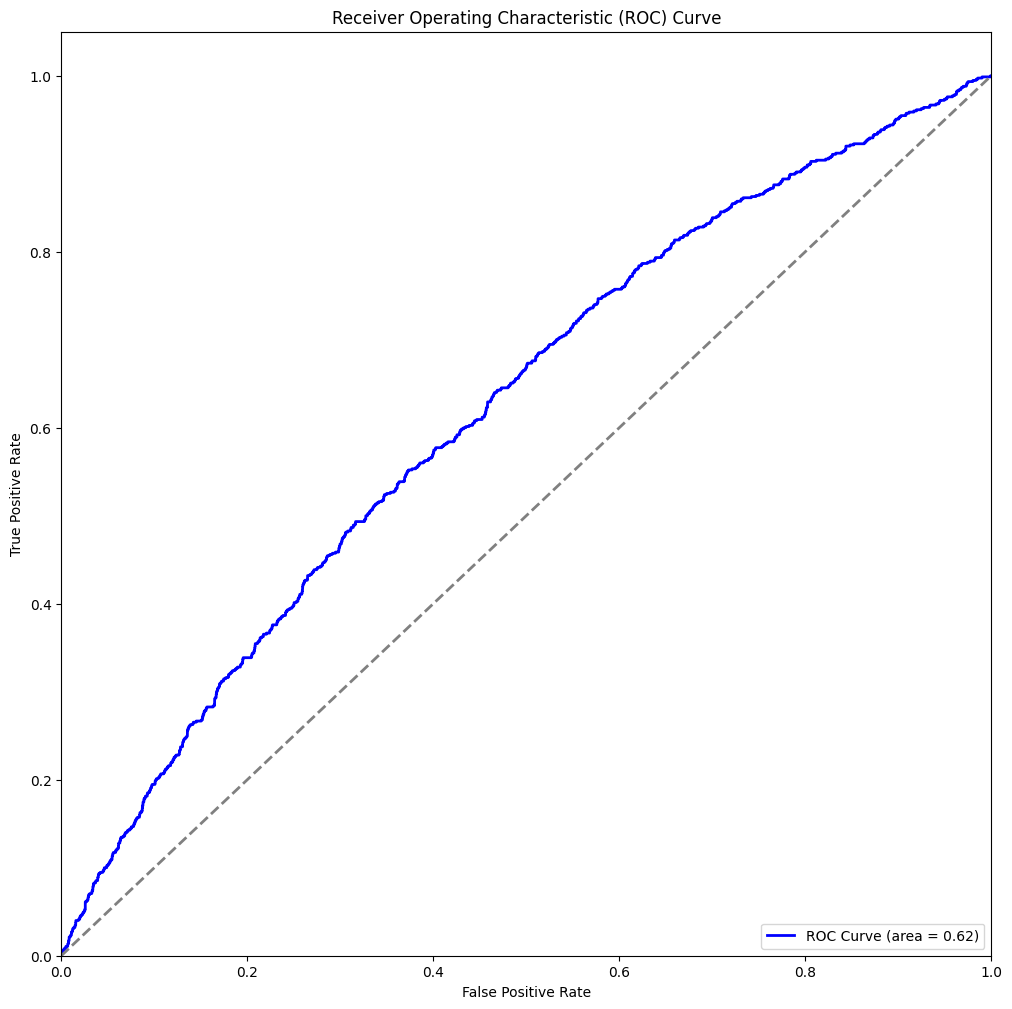

In [53]:
y_test_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Plot ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=plot_sizes[1])
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

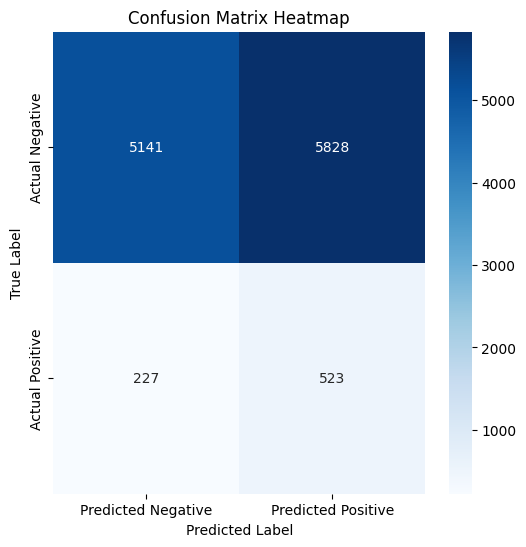

In [50]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()